# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import mannwhitneyu, shapiro


In [2]:
import os
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.1'

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
try:
    from pymer4.models import glm, glmer
except:
    from pymer4.models import glm, glmer
    print("pymer4 is installed.")


Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.
C:\Users\asaf4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rpy2\rinterface\__init__.py:1185: UserWarning: Environment variable "PATH" redefined by R and overriding existing variable. Current: "c:\Users\asaf4\AppData\Local\Microsoft\WindowsApps;c:\Users\asaf4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\Scripts;C:\Python313\Scripts\;C:\Python313\;C:\ffmpeg\bin;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Windows\System32\OpenSSH\;C:\Program Files\dotnet\;C:\Program Files\Git\cmd;C:\Users\asaf4\AppData\Local\Microsoft\WindowsApps;C:\Users\asaf4\AppData\Local\Programs\Microsoft VS Code\bin;C:\Users\asaf4\AppData\Local\Programs\cursor\resources\app\bin;C:\Users\asaf4\AppData\

pymer4 is installed.


In [5]:
import warnings

# Disable SettingWithCopyWarning globally for pandas
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

# Functions

## Plots

In [6]:
def plot_and_standardize_distributions(df, exposure_vars):
    """
    Plot distributions of variables before and after standardization and add standardized columns to dataframe.
    
    Args:
        df (pd.DataFrame): Input dataframe containing the variables to analyze
        exposure_vars (list): List of column names to analyze and standardize
        
    Returns:
        pd.DataFrame: DataFrame with added standardized columns
    """
    # Create figure showing the original distributions of these characteristics
    plt.figure(figsize=(15, 5))
    plt.suptitle('Distribution of Flower Characteristics Before Standardization', fontsize=14, y=1.05)

    # Plot histograms of the raw data
    for i, var in enumerate(exposure_vars):
        plt.subplot(1, len(exposure_vars), i + 1)
        sns.histplot(data=df, x=var, kde=True)
        plt.title(f'{var}')
        plt.xlabel(f'{var} (Original Units)')
        plt.ylabel('Number of Flowers')

    plt.tight_layout()
    plt.show()

    # Standardize the variables to have mean=0 and standard deviation=1
    # This allows comparison between variables measured in different units
    scaler = StandardScaler()
    normalized_cols = [f'{col}_norm_std' for col in exposure_vars]
    df[normalized_cols] = scaler.fit_transform(df[exposure_vars])

    # Create figure showing the standardized distributions
    plt.figure(figsize=(15, 5))
    plt.suptitle('Distribution of Flower Characteristics After Standardization', fontsize=14, y=1.05)

    # Plot histograms of standardized data
    for i, var in enumerate(normalized_cols):
        plt.subplot(1, len(exposure_vars), i + 1)
        sns.histplot(data=df, x=var, kde=True)
        plt.title(f'{exposure_vars[i]}')
        plt.xlabel('Standard Deviations from Mean')
        plt.ylabel('Number of Flowers')
        
        # Add text showing mean and std of original data
        orig_mean = df[exposure_vars[i]].mean()
        orig_std = df[exposure_vars[i]].std()
        plt.text(0.05, 0.95, f'Original Mean: {orig_mean:.2f}\nOriginal Std: {orig_std:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')

    plt.tight_layout()
    plt.show()
    
    return df

In [7]:
def plot_population_treatment_distributions(df, variables_to_plot, population_column='population', treatment_column='treatment', show_stats=False):
    """
    Create box plots, violin plots and print summary statistics for variables across population and treatment groups.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe containing the data
    variables_to_plot : list
        List of variable names to analyze
    population_column : str, optional
        Name of the population column (default: 'population')
    treatment_column : str, optional 
        Name of the treatment column (default: 'treatment')
    show_stats : bool, optional
        Whether to show median and other statistics on the box plots (default: False)
    """
    # Create subplots for each variable, separated by population and treatment
    rows, columns = len(variables_to_plot), 1
    fig, axes = plt.subplots(rows, columns, figsize=(12, 10))
    
    # Convert axes to array if single subplot
    if rows == 1:
        axes = [axes]
    elif rows > 1:
        axes = axes.ravel()

    # Loop through variables and create box plots
    for i, var in enumerate(variables_to_plot):
        # Create box plot with population on x-axis and treatment as hue
        box_plot = sns.boxplot(x=population_column, y=var, hue=treatment_column, data=df, ax=axes[i])
        axes[i].set_title(f'{var} by Population and Treatment')
        axes[i].set_xlabel('Population')
        axes[i].set_ylabel(var)
        
        if show_stats:
            # Calculate and display statistics for each box
            for j, population in enumerate(df[population_column].unique()):
                for k, treatment in enumerate(df[treatment_column].unique()):
                    data = df[(df[population_column] == population) & 
                            (df[treatment_column] == treatment)][var]
                    if len(data) > 0:  # Only add stats if data exists
                        median = data.median()
                        q1 = data.quantile(0.25)
                        q3 = data.quantile(0.75)
                        n = len(data)
                        stats_text = f'n={n}\nmedian={median:.2f}\nQ1={q1:.2f}\nQ3={q3:.2f}'
                        # Position text above each box
                        x_pos = j + (k * 0.8 - 0.4)  # Adjust x position based on box position
                        y_pos = data.mean() 
                        axes[i].text(x_pos, y_pos, stats_text,
                                   horizontalalignment='center',
                                   verticalalignment='bottom')

    plt.tight_layout()
    plt.show()

    # Create violin plots for the same variables
    fig, axes = plt.subplots(rows, columns, figsize=(12, 10))
    
    # Convert axes to array if single subplot
    if rows == 1:
        axes = [axes]
    elif rows > 1:
        axes = axes.ravel()

    for i, var in enumerate(variables_to_plot):
        sns.violinplot(x=population_column, y=var, hue=treatment_column, data=df, ax=axes[i])
        axes[i].set_title(f'{var} by Population and Treatment')
        axes[i].set_xlabel('Population')
        axes[i].set_ylabel(var)

    plt.tight_layout()
    plt.show()

    # Create summary statistics table
    summary_stats = []
    for var in variables_to_plot:
        for pop in df[population_column].unique():
            for treat in df[treatment_column].unique():
                data = df[(df[population_column] == pop) & (df[treatment_column] == treat)][var]
                if len(data) > 0:
                    stats = {
                        'Variable': var,
                        'Population': pop,
                        'Treatment': treat,
                        'Count': len(data),
                        'Mean': data.mean(),
                        'Std': data.std(),
                        'Min': data.min(),
                        'Q1': data.quantile(0.25),
                        'Median': data.median(),
                        'Q3': data.quantile(0.75),
                        'Max': data.max()
                    }
                    summary_stats.append(stats)
    
    # Convert to DataFrame and display
    summary_df = pd.DataFrame(summary_stats)
    display(summary_df.style.format({
        'Mean': '{:.2f}',
        'Std': '{:.2f}',
        'Min': '{:.2f}',
        'Q1': '{:.2f}',
        'Median': '{:.2f}',
        'Q3': '{:.2f}',
        'Max': '{:.2f}'
    }))

In [8]:
def plot_fruit_distribution(df):
    """
    Plot the distribution of fruit presence across treatments and populations.
    
    Args:
        df (pandas.DataFrame): DataFrame containing the columns 'fruit', 'treatment', and 'population'
    """
    # Drop rows where 'fruit' is NaN for visualization purposes
    df_cleaned = df.dropna(subset=['fruit'])

    # Ensure 'fruit' is treated as a categorical variable for plotting
    df_cleaned['fruit'] = df_cleaned['fruit'].astype(int).astype(str)

    # Create the faceted count plot using catplot
    g = sns.catplot(data=df_cleaned, x='treatment', hue='fruit', col='population', 
                    kind='count', height=5, aspect=0.8)
    g.fig.suptitle('Fruit Presence by Treatment and Population', y=1.03)

    # Add numbers on top of each bar
    for ax in g.axes.flat: # Iterate through each subplot
        for p in ax.patches: # Iterate through each bar in the subplot
            if p.get_height() > 0: # Only add text if bar height is greater than 0
                ax.text(p.get_x() + p.get_width() / 2.,    # x-coordinate of text
                        p.get_height(),                   # y-coordinate of text (top of the bar)
                        f'{int(p.get_height())}',         # Text to display (bar height as integer)
                        ha='center',                      # Horizontal alignment
                        va='bottom',                      # Vertical alignment (place text just above the bar)
                        fontsize=9,                       # Font size
                        color='black')                    # Text color

    plt.tight_layout()
    plt.show()

    # Print counts for each combination
    print("Counts grouped by treatment, then population, then fruit:")
    print(df_cleaned.groupby(['treatment', 'population', 'fruit']).size().unstack(fill_value=0))

In [9]:
def plot_top_k_genotypes_boxplot(df, variable_name='flower_size_norm', k=15):
    """
    Create boxplots showing distribution of a variable for top k genotypes by count,
    separated by population and treatment.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing genotype_id and variable to plot
    variable_name : str, default='flower_size_norm'
        Name of variable to plot on y-axis
    k : int, default=15
        Number of top genotypes to include per group
    """
    # Create figure with subplots for each population-treatment combination
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Define the three groups
    groups = [
        ('KUR', 'CONTROL'),
        ('NET', 'CONTROL'),
        ('NET', 'TREATMENT')
    ]
    
    for idx, (pop, treat) in enumerate(groups):
        # Filter data for this population-treatment combination
        df_group = df[(df['population'] == pop) & (df['treatment'] == treat)]
        
        # Get top k genotypes by total count
        genotype_counts = df_group['genotype_id'].value_counts()
        top_k_genotypes = genotype_counts.nlargest(k).index
        
        # Filter data for top k genotypes
        df_topk = df_group[df_group['genotype_id'].isin(top_k_genotypes)]
        
        # Sort genotypes by their total count
        df_topk['genotype_order'] = df_topk['genotype_id'].map(genotype_counts)
        df_topk = df_topk.sort_values('genotype_order', ascending=False)
        
        # Create box plot in corresponding subplot
        if treat == 'TREATMENT':
            sns.boxplot(data=df_topk, x='genotype_id', y=variable_name, ax=axes[idx], color='orange')
        else:
            sns.boxplot(data=df_topk, x='genotype_id', y=variable_name, ax=axes[idx])
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
        axes[idx].set_title(f'{pop} - {treat}')
        axes[idx].set_xlabel('Genotype ID')
        
        # Only show y-label for first subplot
        if idx == 0:
            axes[idx].set_ylabel(variable_name)
        else:
            axes[idx].set_ylabel('')

    plt.suptitle(f'{variable_name} Distribution by Top {k} Genotypes per Group')
    plt.tight_layout()
    plt.show()

In [10]:
def plot_fruit_success_by_genotype(df, k=15):
    """
    Plot stacked bar charts showing fruit success/failure counts for top k genotypes per population-treatment group.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing genotype_id, population, treatment and fruit columns
    k : int, default=15
        Number of top genotypes to include per group
    """
    # Create figure with subplots for each population-treatment combination
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Define the three groups
    groups = [
        ('KUR', 'CONTROL'),
        ('NET', 'CONTROL'), 
        ('NET', 'TREATMENT')
    ]

    for idx, (pop, treat) in enumerate(groups):
        # Filter data for this population-treatment combination
        df_group = df[(df['population'] == pop) & (df['treatment'] == treat)]
        
        # Get top k genotypes for this group
        top_k_genotypes = df_group['genotype_id'].value_counts().nlargest(k).index
        
        # Filter data for top k genotypes
        df_topk = df_group[df_group['genotype_id'].isin(top_k_genotypes)]
        
        # Calculate fruit success/failure counts per genotype
        fruit_counts = df_topk.groupby(['genotype_id', 'fruit']).size().unstack(fill_value=0)
        
        # Sort by total count descending
        total_counts = fruit_counts.sum(axis=1)
        fruit_counts = fruit_counts.loc[total_counts.sort_values(ascending=False).index]
        
        # Create stacked bar plot
        fruit_counts.plot(kind='bar', stacked=True, ax=axes[idx], 
                         color=['orange', 'C0'], # 0=orange, 1=default blue
                         width=0.8)
        
        axes[idx].set_title(f'{pop} - {treat}')
        axes[idx].set_xlabel('Genotype ID')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
        
        # Only show y-label for first subplot
        if idx == 0:
            axes[idx].set_ylabel('Count')
        else:
            axes[idx].set_ylabel('')
            
        # Add legend
        axes[idx].legend(['No Fruit', 'Has Fruit'])

    plt.suptitle(f'Fruit Success Distribution by Top {k} Genotypes per Group')
    plt.tight_layout()
    plt.show()


## Relative Fitness and Set Calculations

In [11]:
def calculate_per_genotype_metrics(df):
    """
    Calculate seed set and fruit set per genotype according to the formulas:
    - Seed Set = ΣSeed Count / ΣFruit Count (average seeds per fruit for fruiting flowers)
    - Fruit Set = ΣFruit Count / ΣFlowers (proportion of flowers that developed fruit)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with columns: genotype_id, fruit, seed
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with genotype-level metrics
    """
    
    # Group by genotype and calculate the required metrics
    genotype_stats = df.groupby('genotype_id').agg({
        'fruit': ['count', 'sum'],  # count = total flowers, sum = total fruits
        'seed': 'sum'  # sum = total seeds
    }).round(4)
    
    # Flatten column names
    genotype_stats.columns = ['total_flowers', 'total_fruits', 'total_seeds']
    
    # Calculate Seed Set (average seeds per fruit for fruiting flowers only)
    # Only calculate for genotypes that have at least one fruit
    genotype_stats['seed_set'] = genotype_stats.apply(
        lambda row: row['total_seeds'] / row['total_fruits'] if row['total_fruits'] > 0 else 0, 
        axis=1
    ).round(4)
    
    # Calculate Fruit Set (proportion of flowers that developed fruit)
    genotype_stats['fruit_set'] = (genotype_stats['total_fruits'] / genotype_stats['total_flowers']).round(4)
    
    # Reset index to make genotype_id a column
    genotype_stats = genotype_stats.reset_index()
    
    # Add additional grouping variables if they exist in the data
    if 'population' in df.columns:
        pop_treatment = df.groupby('genotype_id')[['population', 'treatment']].first().reset_index()
        genotype_stats = genotype_stats.merge(pop_treatment, on='genotype_id', how='left')
    
    # Reorder columns for better presentation
    column_order = ['genotype_id']
    if 'population' in genotype_stats.columns:
        column_order.extend(['population', 'treatment'])
    column_order.extend(['total_flowers', 'total_fruits', 'total_seeds', 'seed_set', 'fruit_set'])
    
    genotype_stats = genotype_stats[column_order]
    
    return genotype_stats

In [12]:
def calculate_relative_fitness(genotype_metrics):
    """
    Calculate relative fruit fitness and relative seed fitness for each genotype 
    within their population-treatment subset.
    
    Relative Fitness = (Individual Performance) / (Mean Performance in Subset)
    
    Parameters:
    -----------
    genotype_metrics : pandas.DataFrame
        DataFrame with genotype-level metrics including seed_set and fruit_set
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added relative fitness columns
    """
    
    # Create a copy to avoid modifying the original
    df_fitness = genotype_metrics.copy()
    
    # Calculate mean performance for each population-treatment subset
    subset_means = df_fitness.groupby(['population', 'treatment']).agg({
        'seed_set': 'mean',
        'fruit_set': 'mean'
    }).reset_index()
    subset_means.columns = ['population', 'treatment', 'mean_seed_set_subset', 'mean_fruit_set_subset']
    
    # Merge subset means back to the main dataframe
    df_fitness = df_fitness.merge(subset_means, on=['population', 'treatment'], how='left')
    
    # Calculate relative fitness metrics
    # Relative Seed Fitness = Individual Seed Set / Mean Seed Set in Subset
    df_fitness['relative_seed_fitness'] = (df_fitness['seed_set'] / df_fitness['mean_seed_set_subset']).round(4)
    
    # Relative Fruit Fitness = Individual Fruit Set / Mean Fruit Set in Subset  
    df_fitness['relative_fruit_fitness'] = (df_fitness['fruit_set'] / df_fitness['mean_fruit_set_subset']).round(4)
    
    # Handle cases where subset mean is 0 (avoid division by zero)
    df_fitness['relative_seed_fitness'] = df_fitness['relative_seed_fitness'].fillna(0)
    df_fitness['relative_fruit_fitness'] = df_fitness['relative_fruit_fitness'].fillna(0)
    
    # Replace infinite values with 0 (in case of division by 0)
    df_fitness['relative_seed_fitness'] = df_fitness['relative_seed_fitness'].replace([np.inf, -np.inf], 0)
    df_fitness['relative_fruit_fitness'] = df_fitness['relative_fruit_fitness'].replace([np.inf, -np.inf], 0)
    
    return df_fitness

## Statistical Test

In [13]:
def group_summary_stats(
    group1_data, 
    group2_data, 
    variable_name="fruit set", 
    group1_name="Group 1", 
    group2_name="Group 2"
):
    """
    Print summary statistics and normality tests for a variable in two groups.

    Parameters:
        group1_data (array-like): Data for first group.
        group2_data (array-like): Data for second group.
        variable_name (str): Name of the variable being compared (e.g., "fruit set", "fruit count", "seed set").
        group1_name (str): Name for first group (default: "Group 1").
        group2_name (str): Name for second group (default: "Group 2").
    """
    print(f"WILCOXON RANK-SUM TEST: {group2_name} vs {group1_name}")
    print("=" * 60)
    print(f"Testing if {variable_name} differs between {group2_name} and {group1_name} groups")
    print()

    print(f"{group1_name} group: n = {len(group1_data)} samples")
    print(f"{group2_name} group: n = {len(group2_data)} samples")
    print()

    # Display basic statistics for each group
    print("DESCRIPTIVE STATISTICS:")
    print("-" * 30)
    print(f"{group1_name}:")
    print(f"  Mean: {np.mean(group1_data):.4f}")
    print(f"  Median: {np.median(group1_data):.4f}")
    print(f"  Std Dev: {np.std(group1_data, ddof=1):.4f}")
    print(f"  Min: {np.min(group1_data):.4f}")
    print(f"  Max: {np.max(group1_data):.4f}")
    print()

    print(f"{group2_name}:")
    print(f"  Mean: {np.mean(group2_data):.4f}")
    print(f"  Median: {np.median(group2_data):.4f}")
    print(f"  Std Dev: {np.std(group2_data, ddof=1):.4f}")
    print(f"  Min: {np.min(group2_data):.4f}")
    print(f"  Max: {np.max(group2_data):.4f}")
    print()

    # Check for normality (to justify using non-parametric test)
    print("NORMALITY TESTS (Shapiro-Wilk):")
    print("-" * 30)

    if len(group1_data) >= 3:
        stat_control, p_control = shapiro(group1_data)
        print(f"{group1_name}: Statistic = {stat_control:.4f}, p-value = {p_control:.4f}")
        if p_control < 0.05:
            print("  → Data is NOT normally distributed (p < 0.05)")
        else:
            print("  → Data appears normally distributed (p ≥ 0.05)")
    else:
        print(f"{group1_name}: Sample too small for normality test")

    if len(group2_data) >= 3:
        stat_treatment, p_treatment = shapiro(group2_data)
        print(f"{group2_name}: Statistic = {stat_treatment:.4f}, p-value = {p_treatment:.4f}")
        if p_treatment < 0.05:
            print("  → Data is NOT normally distributed (p < 0.05)")
        else:
            print("  → Data appears normally distributed (p ≥ 0.05)")
    else:
        print(f"{group2_name}: Sample too small for normality test")

    print()
    print(f"Note: Wilcoxon test is appropriate for {variable_name} regardless of normality")
    print()

In [14]:
def wilcoxon_group_analysis(
    group1_data, group2_data, 
    variable_label="Value", 
    group1_name="NET CONTROL", 
    group2_name="NET TREATMENT",
    alternative = 'two-sided'

):
    """
    Perform Wilcoxon rank-sum test (Mann-Whitney U test) between two groups
    for any variable (fruit set, seed set, etc.), print results, effect size, and group comparison.

    Parameters:
        group1_data (array-like): Data for group 1 (e.g., control).
        group2_data (array-like): Data for group 2 (e.g., treatment).
        variable_label (str): Name of the variable being compared (e.g., "fruit set", "seed set").
        group1_name (str): Name for group 1 (default: "NET CONTROL").
        group2_name (str): Name for group 2 (default: "NET TREATMENT").
    """
    print(f"WILCOXON RANK-SUM TEST RESULTS for {variable_label.upper()}:")
    print("-" * 40)

    # Perform the test
    statistic, p_value = mannwhitneyu(group1_data, group2_data, alternative=alternative)

    print(f"Test Statistic (U): {statistic}")
    print(f"P-value: {p_value:.6f}")
    print()

    # Interpret the results
    alpha = 0.05
    print(f"Significance level (α): {alpha}")
    print()

    if p_value < alpha:
        print("🚨 RESULT: SIGNIFICANT DIFFERENCE")
        print(f"   P-value ({p_value:.6f}) < α ({alpha})")
        print("   → Reject the null hypothesis")
        print(f"   → There IS a significant difference in {variable_label} between {group2_name} and {group1_name}")
    else:
        print("✅ RESULT: NO SIGNIFICANT DIFFERENCE")
        print(f"   P-value ({p_value:.6f}) ≥ α ({alpha})")
        print("   → Fail to reject the null hypothesis")
        print(f"   → There is NO significant difference in {variable_label} between {group2_name} and {group1_name}")

    print()

    # Effect size calculation (rank-biserial correlation)
    n1, n2 = len(group1_data), len(group2_data)
    max_u = n1 * n2
    effect_size = 1 - (2 * statistic) / max_u

    print("EFFECT SIZE:")
    print("-" * 15)
    print(f"Rank-biserial correlation: {effect_size:.4f}")
    print("Interpretation:")
    if abs(effect_size) < 0.1:
        print("  → Negligible effect size")
    elif abs(effect_size) < 0.3:
        print("  → Small effect size")
    elif abs(effect_size) < 0.5:
        print("  → Medium effect size")
    else:
        print("  → Large effect size")

    print()

    # Which group has higher median value?
    median1 = np.median(group1_data)
    median2 = np.median(group2_data)

    print("GROUP COMPARISON:")
    print("-" * 20)
    print(f"{group1_name} median {variable_label}: {median1:.4f}")
    print(f"{group2_name} median {variable_label}: {median2:.4f}")

    if median2 > median1:
        difference = median2 - median1
        print(f"{group2_name} has higher median {variable_label} (+{difference:.4f})")
    elif median1 > median2:
        difference = median1 - median2
        print(f"{group1_name} has higher median {variable_label} (+{difference:.4f})")
    else:
        print(f"Both groups have the same median {variable_label}")

## Display R models

In [15]:
def display_model_summary(r_summary):
    # Display the conditional (main) part of the model
    cond_matrix = r_summary.rx2("coefficients").rx2("cond")
    print("Conditional model coefficients (COUNT part):")
    print(cond_matrix)
    cond_df = r_matrix_to_dataframe(cond_matrix)

    # tidy up column headers if you like
    cond_df.columns = ["term", "Estimate", "Std_Error", "z_value", "p_value"]

    print(cond_df.head())

    ran_df  = _to_df(r_summary.rx2("varcor"))  # random-effects σ²

    print("\nFixed effects – COUNT (negative-binomial) part")
    display(cond_df)
    print(cond_df)
    print("\nRandom-effect variances")
    display(ran_df)
    print(ran_df)

# Load Data

## Loading

In [125]:
csv_output_path = r'..\data\2024\Data_Per_flower_2024_final.csv'
df = pd.read_csv(csv_output_path)
df.drop(columns=['seed_weight'],inplace=True)
df

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower_size,tunnel_length,entr_length,entr_height,tunnel_volume_cm,bp_area,fruit,seed
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0
1,2,2024-02-07,1,NET,BROWN,N185,185.1,SUPP,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,298,2024-03-13,36,KUR,BLUE,K222,222.3,CONTROL,51.4,46.9,1.095949,24.1066,24.6,12.2,8.0,2.400960,6.464,NaN,NaN
298,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.913460,5.452,0.0,0.0
299,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0
300,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,1.164436,31.8507,30.7,13.5,5.8,2.403810,7.456,0.0,0.0


- Talk with Prittee about treatment in Yavne

In [126]:
df = df.drop(df[(df['population']=='KUR') & (df['treatment']=='SUPP')].index)
df

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower_size,tunnel_length,entr_length,entr_height,tunnel_volume_cm,bp_area,fruit,seed
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0
1,2,2024-02-07,1,NET,BROWN,N185,185.1,SUPP,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,298,2024-03-13,36,KUR,BLUE,K222,222.3,CONTROL,51.4,46.9,1.095949,24.1066,24.6,12.2,8.0,2.400960,6.464,NaN,NaN
298,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.913460,5.452,0.0,0.0
299,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0
300,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,1.164436,31.8507,30.7,13.5,5.8,2.403810,7.456,0.0,0.0


In [127]:
# Rename columns to include units
df = df.rename(columns={
    'Flower_size': 'Flower Size (cm^2)',
    'tunnel_volume_cm': 'Tunnel Volume (cm^3)', 
    'bp_area': 'Black Patch Area (cm^2)'
})
df

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower Size (cm^2),tunnel_length,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0
1,2,2024-02-07,1,NET,BROWN,N185,185.1,SUPP,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,298,2024-03-13,36,KUR,BLUE,K222,222.3,CONTROL,51.4,46.9,1.095949,24.1066,24.6,12.2,8.0,2.400960,6.464,NaN,NaN
298,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.913460,5.452,0.0,0.0
299,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0
300,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,1.164436,31.8507,30.7,13.5,5.8,2.403810,7.456,0.0,0.0


In [128]:
# Rename SUPP to TREATMENT in treatment column
df['treatment'] = df['treatment'].replace('SUPP', 'TREATMENT')

df.value_counts(['population','treatment'])

population  treatment
KUR         CONTROL      171
NET         CONTROL       81
            TREATMENT     47
Name: count, dtype: int64

In [129]:
genotype_stats = df.groupby('genotype_id').agg({
    'fruit': ['count', 'sum'],  # count = total flowers, sum = total fruits
    'seed': 'sum'  # sum = total seeds
}).round(4)


genotype_stats.columns = ['total_flowers', 'total_fruits', 'total_seeds']

genotype_stats

,total_flowers,total_fruits,total_seeds
genotype_id,,,
K135,1,1.0,8.0
K136,2,0.0,0.0
K139,1,1.0,19.0
K140,5,4.0,117.0
K142,1,0.0,0.0
...,...,...,...
N234,1,0.0,0.0
N900,1,0.0,0.0
N902,1,1.0,6.0


In [130]:
# Add total_flowers to the df for each level by its genotype_id
genotype_total_flowers = df.groupby('genotype_id')['fruit'].count().rename('total_flowers')
df = df.merge(genotype_total_flowers, on='genotype_id', how='left')
df


,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower Size (cm^2),tunnel_length,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,total_flowers
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0,1
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0,1
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0,3
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0,3
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,298,2024-03-13,36,KUR,BLUE,K222,222.3,CONTROL,51.4,46.9,1.095949,24.1066,24.6,12.2,8.0,2.400960,6.464,NaN,NaN,0
295,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.913460,5.452,0.0,0.0,2
296,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0,5
297,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,1.164436,31.8507,30.7,13.5,5.8,2.403810,7.456,0.0,0.0,6


## Missing Values

In [131]:
df_na = df[df.isna().any(axis=1)]
df_na[['population', 'genotype_id', 'treatment', 'Flower Size (cm^2)', 'Black Patch Area (cm^2)', 'Tunnel Volume (cm^3)', 'fruit', 'seed']].style.highlight_null(color='yellow').set_properties(**{'text-align': 'center'})

,population,genotype_id,treatment,Flower Size (cm^2),Black Patch Area (cm^2),Tunnel Volume (cm^3),fruit,seed
19,NET,N187,CONTROL,62.013100,7.956000,nan,0.000000,0.000000
38,NET,N190,CONTROL,44.118300,6.774000,3.611496,1.000000,nan
83,NET,N196,TREATMENT,55.272000,8.540000,4.355472,1.000000,nan
92,NET,N198,TREATMENT,64.616000,8.425000,2.948670,1.000000,nan
93,NET,N198,TREATMENT,65.521800,14.897000,3.656832,1.000000,nan
103,NET,N111,TREATMENT,36.838500,9.997000,nan,0.000000,0.000000
114,NET,N188,CONTROL,74.181900,6.784000,4.466880,1.000000,nan
188,KUR,K187,CONTROL,44.742600,8.642000,nan,0.000000,0.000000
242,KUR,K197,CONTROL,39.433800,6.156000,nan,1.000000,23.000000
265,KUR,K159,CONTROL,28.229600,7.046000,nan,0.000000,0.000000


In [132]:
# Drop rows with any missing values and display the resulting DataFrame
df = df.dropna()
df


,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower Size (cm^2),tunnel_length,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,total_flowers
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0,1
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0,1
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0,3
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0,3
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,295,2024-03-07,30,KUR,RED,K221,221.4,CONTROL,66.8,54.7,1.221207,36.5396,31.8,11.9,7.8,2.951676,7.885,0.0,0.0,6
295,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.913460,5.452,0.0,0.0,2
296,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0,5
297,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,1.164436,31.8507,30.7,13.5,5.8,2.403810,7.456,0.0,0.0,6


## Scaling Covariates
- Scale for each population

In [133]:
df_net = df[df['population'] == 'NET']
df_net

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower Size (cm^2),tunnel_length,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,total_flowers
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0,1
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0,1
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0,3
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0,3
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,2024-03-06,29,NET,BLUE,N090,90.1,CONTROL,75.5,60.9,1.239737,45.9795,36.3,9.9,5.1,1.832787,7.489,1.0,34.0,1
124,125,2024-03-06,29,NET,BLUE,N098,98.1,TREATMENT,70.5,65.2,1.081288,45.9660,34.3,10.8,6.9,2.556036,10.928,1.0,2.0,1
125,126,2024-03-06,29,NET,BLUE,N103,103.1,TREATMENT,56.7,54.1,1.048059,30.6747,31.6,10.1,6.2,1.978792,11.095,1.0,39.0,1
126,127,2024-03-06,29,NET,BLUE,N199,199.2,CONTROL,75.0,53.5,1.401869,40.1250,32.6,11.3,7.4,2.726012,9.072,0.0,0.0,2


In [134]:
df_net.columns

Index(['S.No.', 'date', 'day', 'population', 'area', 'genotype_id',
       'Flower_id', 'treatment', 'length_mm', 'width_mm', 'ratio_len_wid',
       'Flower Size (cm^2)', 'tunnel_length', 'entr_length', 'entr_height',
       'Tunnel Volume (cm^3)', 'Black Patch Area (cm^2)', 'fruit', 'seed',
       'total_flowers'],
      dtype='object')

In [135]:
exposure_vars = ['Flower Size (cm^2)', 'Tunnel Volume (cm^3)', 'Black Patch Area (cm^2)','total_flowers']


In [136]:
df_net[exposure_vars]

,Flower Size (cm^2),Tunnel Volume (cm^3),Black Patch Area (cm^2),total_flowers
0,81.9890,4.279209,8.166,1
1,64.8480,3.040128,7.224,1
2,68.5125,4.469580,7.652,3
3,64.5075,2.610160,7.958,3
4,67.6161,4.061904,5.656,5
...,...,...,...,...
123,45.9795,1.832787,7.489,1
124,45.9660,2.556036,10.928,1
125,30.6747,1.978792,11.095,1
126,40.1250,2.726012,9.072,2


In [137]:
# Standardize the exposure variables for the NET population
scaler = StandardScaler()
df_net[['flower_size_std', 'tunnel_vol_std', 'bp_area_std','total_flowers_std']] = scaler.fit_transform(df_net[exposure_vars])


In [138]:
df_kur = df[df['population'] == 'KUR']
df_kur

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower Size (cm^2),tunnel_length,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,total_flowers
128,132,2024-02-08,2,KUR,BROWN,K211,211.1,CONTROL,74.8,61.2,1.222222,45.7776,27.5,13.1,9.7,3.494425,7.462,0.0,0.0,3
129,133,2024-02-08,2,KUR,Yellow,K212,212.1,CONTROL,81.3,64.6,1.258514,52.5198,31.0,11.3,9.8,3.432940,7.169,1.0,8.0,3
130,134,2024-02-08,2,KUR,Yellow,K212,212.2,CONTROL,78.2,69.8,1.120344,54.5836,30.1,12.4,6.2,2.314088,6.742,1.0,22.0,3
131,135,2024-02-08,2,KUR,Yellow,K212,212.3,CONTROL,72.9,70.3,1.036984,51.2487,30.1,15.5,10.1,4.712155,9.647,0.0,0.0,3
132,136,2024-02-08,2,KUR,Yellow,K213,213.1,CONTROL,63.8,54.2,1.177122,34.5796,28.7,13.8,9.4,3.722964,5.505,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,295,2024-03-07,30,KUR,RED,K221,221.4,CONTROL,66.8,54.7,1.221207,36.5396,31.8,11.9,7.8,2.951676,7.885,0.0,0.0,6
295,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.913460,5.452,0.0,0.0,2
296,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0,5
297,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,1.164436,31.8507,30.7,13.5,5.8,2.403810,7.456,0.0,0.0,6


In [139]:

# Standardize the variables to have mean=0 and standard deviation=1
# This allows comparison between variables measured in different units
scaler = StandardScaler()
exposure_vars = ['Flower Size (cm^2)', 'Tunnel Volume (cm^3)', 'Black Patch Area (cm^2)']
df_kur[['flower_size_std', 'tunnel_vol_std', 'bp_area_std']] = scaler.fit_transform(df_kur[exposure_vars])
df_kur


,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,...,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,total_flowers,flower_size_std,tunnel_vol_std,bp_area_std
128,132,2024-02-08,2,KUR,BROWN,K211,211.1,CONTROL,74.8,61.2,...,13.1,9.7,3.494425,7.462,0.0,0.0,3,0.762696,0.063725,-0.152376
129,133,2024-02-08,2,KUR,Yellow,K212,212.1,CONTROL,81.3,64.6,...,11.3,9.8,3.432940,7.169,1.0,8.0,3,1.666022,0.007340,-0.332824
130,134,2024-02-08,2,KUR,Yellow,K212,212.2,CONTROL,78.2,69.8,...,12.4,6.2,2.314088,6.742,1.0,22.0,3,1.942532,-1.018695,-0.595798
131,135,2024-02-08,2,KUR,Yellow,K212,212.3,CONTROL,72.9,70.3,...,15.5,10.1,4.712155,9.647,0.0,0.0,3,1.495719,1.180436,1.193287
132,136,2024-02-08,2,KUR,Yellow,K213,213.1,CONTROL,63.8,54.2,...,13.8,9.4,3.722964,5.505,0.0,0.0,2,-0.737623,0.273305,-1.357622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,295,2024-03-07,30,KUR,RED,K221,221.4,CONTROL,66.8,54.7,...,11.9,7.8,2.951676,7.885,0.0,0.0,6,-0.475020,-0.434000,0.108135
295,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,...,11.0,8.2,2.913460,5.452,0.0,0.0,2,0.206809,-0.469045,-1.390262
296,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,...,10.9,9.7,2.368352,8.919,1.0,13.0,5,-3.238203,-0.968933,0.744938
297,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,...,13.5,5.8,2.403810,7.456,0.0,0.0,6,-1.103243,-0.936416,-0.156071


In [140]:
# # Merge the standardized NET and KUR dataframes back together
# df = pd.concat([df_net, df_kur], ignore_index=True)
# df


## Calculating SeedSet FruitSet

In [141]:
genotype_stats = df.groupby('genotype_id').agg({
    'fruit': ['count', 'sum'],  # count = total flowers, sum = total fruits
    'seed': 'sum'  # sum = total seeds
}).round(4)


genotype_stats.columns = ['total_flowers', 'total_fruits', 'total_seeds']
# Reset index to make genotype_id a column
genotype_stats = genotype_stats.reset_index()

genotype_stats

,genotype_id,total_flowers,total_fruits,total_seeds
0,K135,1,1.0,8.0
1,K136,2,0.0,0.0
2,K139,1,1.0,19.0
3,K140,5,4.0,117.0
4,K142,1,0.0,0.0
...,...,...,...,...
88,N234,1,0.0,0.0
89,N900,1,0.0,0.0
90,N902,1,1.0,6.0
91,N906,1,0.0,0.0


In [142]:
genotype_stats['total_flowers'].describe()

count    93.000000
mean      3.075269
std       2.667178
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      13.000000
Name: total_flowers, dtype: float64

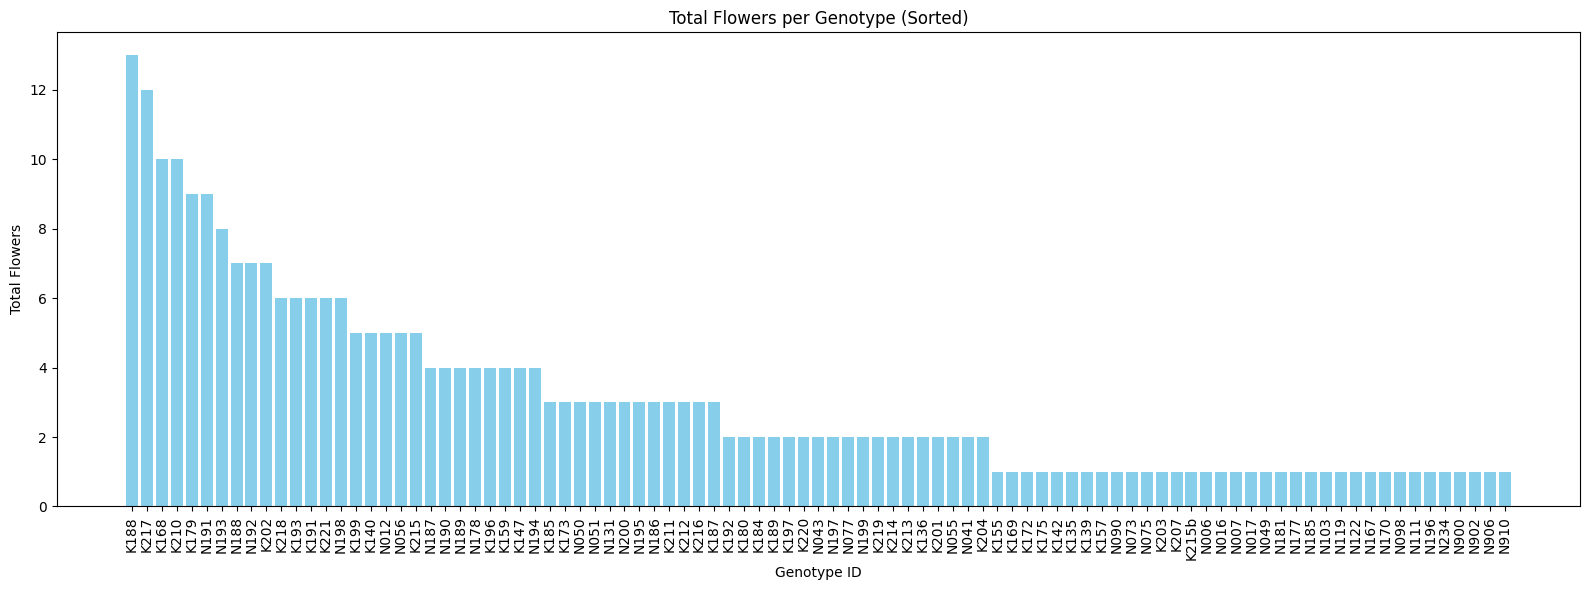

In [143]:
import matplotlib.pyplot as plt

# Sort genotype_stats by total_flowers in descending order for better visualization
sorted_stats = genotype_stats.sort_values('total_flowers', ascending=False)

plt.figure(figsize=(16, 6))
plt.bar(sorted_stats['genotype_id'], sorted_stats['total_flowers'], color='skyblue')
plt.xlabel('Genotype ID')
plt.ylabel('Total Flowers')
plt.title('Total Flowers per Genotype (Sorted)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [144]:
genotype_stats['seed_set'] = genotype_stats.apply(
    lambda row: row['total_seeds'] / row['total_fruits'] if row['total_fruits'] > 0 else 0, 
    axis=1
).round(4)

In [145]:
# Calculate Fruit Set (proportion of flowers that developed fruit)
genotype_stats['fruit_set'] = (genotype_stats['total_fruits'] / genotype_stats['total_flowers']).round(4)

# Reset index to make genotype_id a column
genotype_stats = genotype_stats.reset_index()
genotype_stats

,index,genotype_id,total_flowers,total_fruits,total_seeds,seed_set,fruit_set
0,0,K135,1,1.0,8.0,8.00,1.0
1,1,K136,2,0.0,0.0,0.00,0.0
2,2,K139,1,1.0,19.0,19.00,1.0
3,3,K140,5,4.0,117.0,29.25,0.8
4,4,K142,1,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...
88,88,N234,1,0.0,0.0,0.00,0.0
89,89,N900,1,0.0,0.0,0.00,0.0
90,90,N902,1,1.0,6.0,6.00,1.0
91,91,N906,1,0.0,0.0,0.00,0.0


In [146]:
# Add additional grouping variables if they exist in the data
if 'population' in df.columns:
    pop_treatment = df.groupby('genotype_id')[['population', 'treatment']].first().reset_index()
    genotype_stats = genotype_stats.merge(pop_treatment, on='genotype_id', how='left')

# Reorder columns for better presentation
column_order = ['genotype_id']
if 'population' in genotype_stats.columns:
    column_order.extend(['population', 'treatment'])
column_order.extend(['total_flowers', 'total_fruits', 'total_seeds', 'seed_set', 'fruit_set'])

genotype_stats = genotype_stats[column_order]
genotype_stats

,genotype_id,population,treatment,total_flowers,total_fruits,total_seeds,seed_set,fruit_set
0,K135,KUR,CONTROL,1,1.0,8.0,8.00,1.0
1,K136,KUR,CONTROL,2,0.0,0.0,0.00,0.0
2,K139,KUR,CONTROL,1,1.0,19.0,19.00,1.0
3,K140,KUR,CONTROL,5,4.0,117.0,29.25,0.8
4,K142,KUR,CONTROL,1,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...
88,N234,NET,CONTROL,1,0.0,0.0,0.00,0.0
89,N900,NET,CONTROL,1,0.0,0.0,0.00,0.0
90,N902,NET,TREATMENT,1,1.0,6.0,6.00,1.0
91,N906,NET,CONTROL,1,0.0,0.0,0.00,0.0


In [147]:
#Values > 1.0 = Above average performance within their group
#Values < 1.0 = Below average performance within their group
#Values = 1.0 = Average performance within their group

genotype_fitness = calculate_relative_fitness(genotype_stats)
genotype_fitness

,genotype_id,population,treatment,total_flowers,total_fruits,total_seeds,seed_set,fruit_set,mean_seed_set_subset,mean_fruit_set_subset,relative_seed_fitness,relative_fruit_fitness
0,K135,KUR,CONTROL,1,1.0,8.0,8.00,1.0,14.324444,0.461213,0.5585,2.1682
1,K136,KUR,CONTROL,2,0.0,0.0,0.00,0.0,14.324444,0.461213,0.0000,0.0000
2,K139,KUR,CONTROL,1,1.0,19.0,19.00,1.0,14.324444,0.461213,1.3264,2.1682
3,K140,KUR,CONTROL,5,4.0,117.0,29.25,0.8,14.324444,0.461213,2.0420,1.7346
4,K142,KUR,CONTROL,1,0.0,0.0,0.00,0.0,14.324444,0.461213,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
88,N234,NET,CONTROL,1,0.0,0.0,0.00,0.0,15.975307,0.499352,0.0000,0.0000
89,N900,NET,CONTROL,1,0.0,0.0,0.00,0.0,15.975307,0.499352,0.0000,0.0000
90,N902,NET,TREATMENT,1,1.0,6.0,6.00,1.0,12.807143,0.619733,0.4685,1.6136
91,N906,NET,CONTROL,1,0.0,0.0,0.00,0.0,15.975307,0.499352,0.0000,0.0000


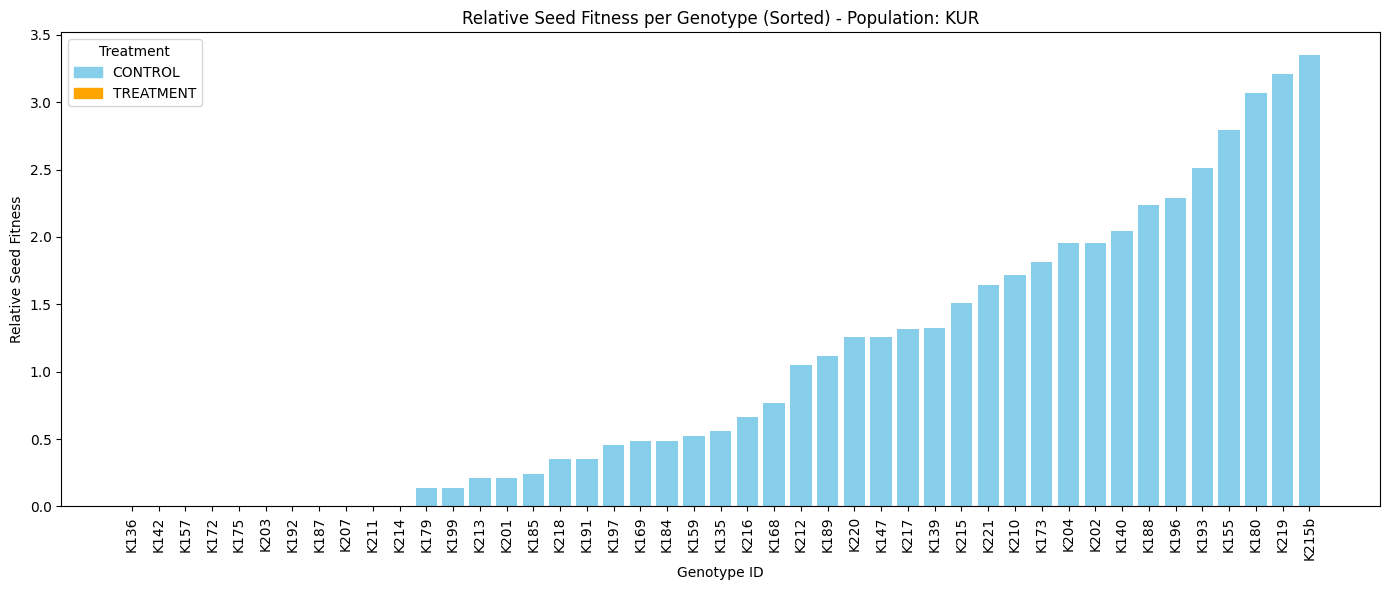

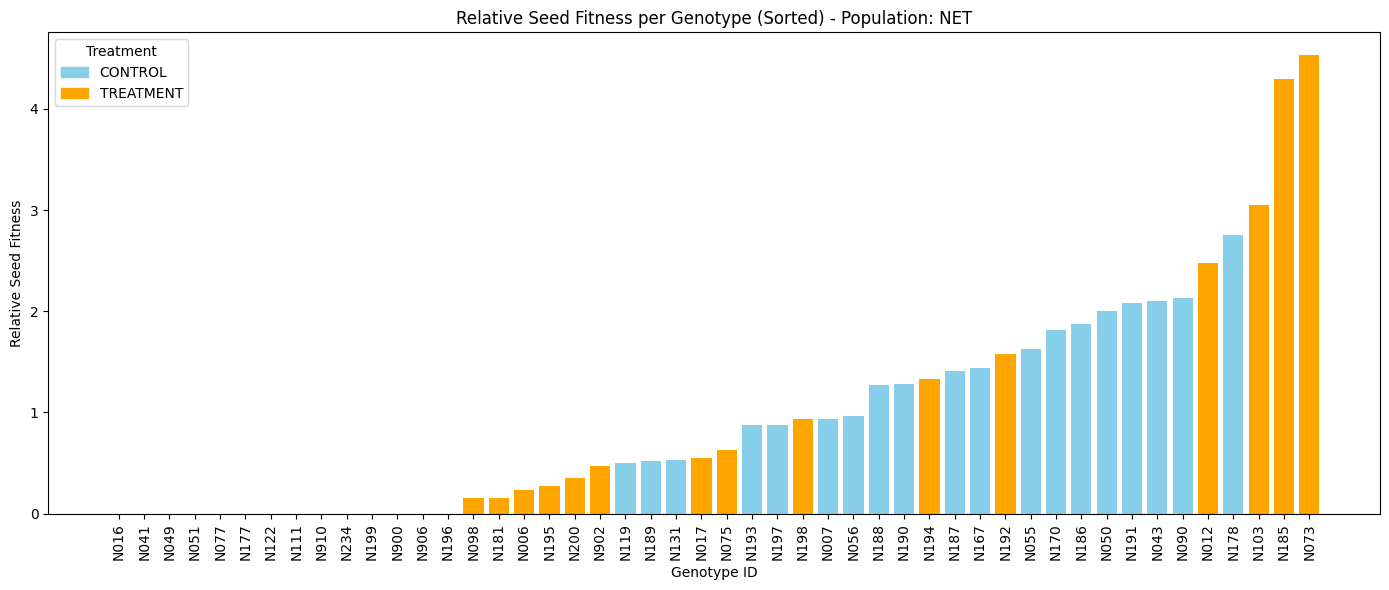

In [148]:
import matplotlib.pyplot as plt

# Ensure population and treatment columns exist
if 'population' not in genotype_fitness.columns or 'treatment' not in genotype_fitness.columns:
    raise ValueError("genotype_fitness must have 'population' and 'treatment' columns for subsetting and coloring.")

# Define colors for treatments
treatment_colors = {
    'CONTROL': 'skyblue',
    'TREATMENT': 'orange'
}

# Get unique populations
populations = genotype_fitness['population'].unique()

# Plot for each population
for pop in populations:
    subset = genotype_fitness[genotype_fitness['population'] == pop]
    # Sort by relative_seed_fitness
    sorted_subset = subset.sort_values(by='relative_seed_fitness', ascending=True)
    # Get colors for each bar based on treatment
    bar_colors = sorted_subset['treatment'].map(treatment_colors).fillna('gray')
    
    plt.figure(figsize=(14, 6))
    plt.bar(sorted_subset['genotype_id'], sorted_subset['relative_seed_fitness'], color=bar_colors)
    plt.xlabel('Genotype ID')
    plt.ylabel('Relative Seed Fitness')
    plt.title(f'Relative Seed Fitness per Genotype (Sorted) - Population: {pop}')
    plt.xticks(rotation=90)
    # Add legend for treatments
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in treatment_colors.values()]
    labels = list(treatment_colors.keys())
    plt.legend(handles, labels, title='Treatment')
    plt.tight_layout()
    plt.show()


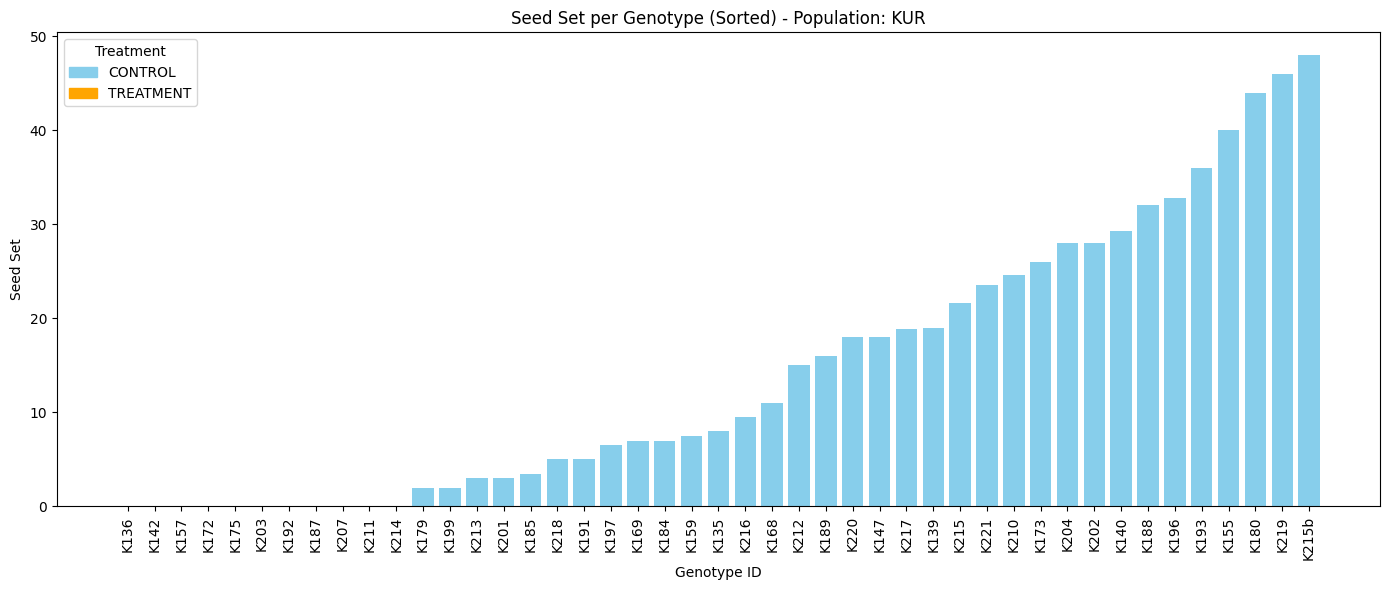

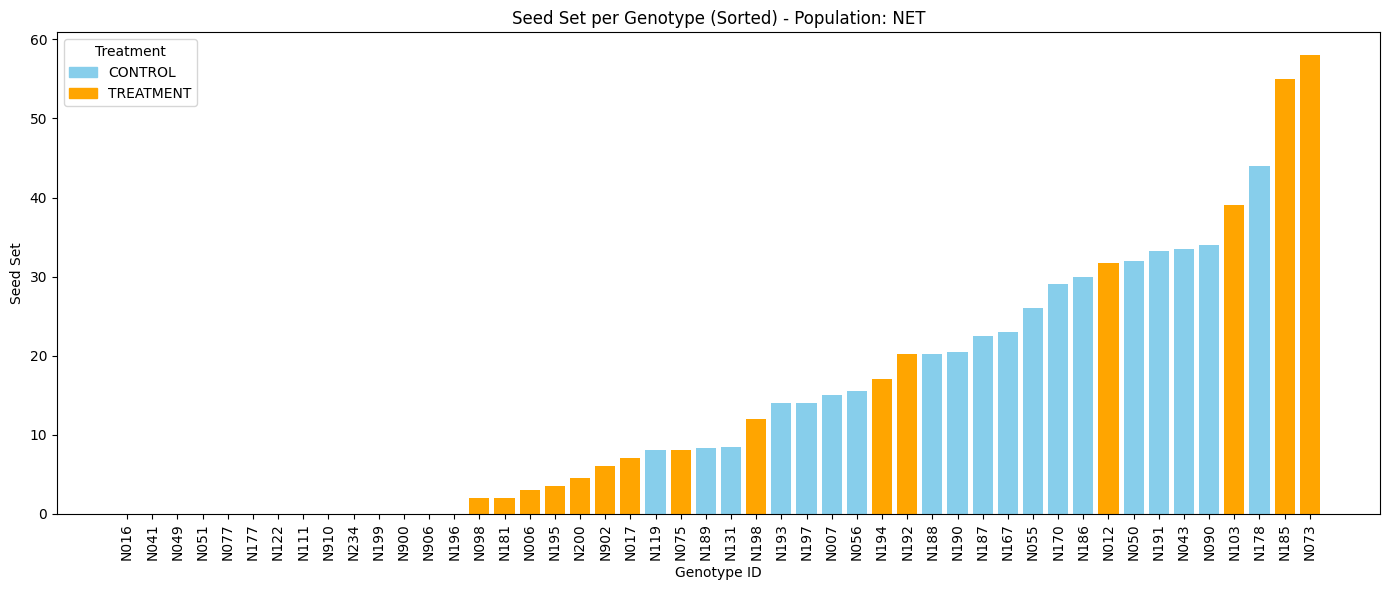

In [149]:
import matplotlib.pyplot as plt

# Ensure population and treatment columns exist
if 'population' not in genotype_fitness.columns or 'treatment' not in genotype_fitness.columns:
    raise ValueError("genotype_fitness must have 'population' and 'treatment' columns for subsetting and coloring.")

# Define colors for treatments
treatment_colors = {
    'CONTROL': 'skyblue',
    'TREATMENT': 'orange'
}

# Get unique populations
populations = genotype_fitness['population'].unique()

# Plot for each population
for pop in populations:
    subset = genotype_fitness[genotype_fitness['population'] == pop]
    # Sort by seed_set
    sorted_subset = subset.sort_values(by='seed_set', ascending=True)
    # Get colors for each bar based on treatment
    bar_colors = sorted_subset['treatment'].map(treatment_colors).fillna('gray')
    
    plt.figure(figsize=(14, 6))
    plt.bar(sorted_subset['genotype_id'], sorted_subset['seed_set'], color=bar_colors)
    plt.xlabel('Genotype ID')
    plt.ylabel('Seed Set')
    plt.title(f'Seed Set per Genotype (Sorted) - Population: {pop}')
    plt.xticks(rotation=90)
    # Add legend for treatments
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in treatment_colors.values()]
    labels = list(treatment_colors.keys())
    plt.legend(handles, labels, title='Treatment')
    plt.tight_layout()
    plt.show()


# EDA
- In protocol.ipynb

# Hypotehsis

## Wilcoxon Test Analysis




### What is a Wilcoxon Test?

The **Wilcoxon rank-sum test** (also known as the Mann-Whitney U test) is a non-parametric statistical test used to compare two independent groups. It's particularly useful when:

1. **Data doesn't meet normality assumptions** - The test doesn't require data to be normally distributed
2. **Small sample sizes** - Works well even with small groups
3. **Ordinal or continuous data** - Can handle ranked or continuous measurements
4. **Robust to outliers** - Less sensitive to extreme values than t-tests

**How it works:**
- Ranks all observations from both groups together
- Compares the sum of ranks between the two groups
- Tests if the distributions are significantly different

**Null Hypothesis (H₀):** The two groups have the same distribution (no difference)
**Alternative Hypothesis (H₁):** The two groups have different distributions

**When to use:**
- Comparing two independent groups
- Non-normal data
- Alternative to independent t-test when assumptions aren't met

### Logistic Regression On treatment

In [41]:
df

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower Size (cm^2),tunnel_length,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,total_flowers
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0,1
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0,1
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0,3
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0,3
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,295,2024-03-07,30,KUR,RED,K221,221.4,CONTROL,66.8,54.7,1.221207,36.5396,31.8,11.9,7.8,2.951676,7.885,0.0,0.0,6
295,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.913460,5.452,0.0,0.0,2
296,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0,5
297,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,1.164436,31.8507,30.7,13.5,5.8,2.403810,7.456,0.0,0.0,6


In [42]:
net = df[df['population'] == 'NET'][['treatment','fruit']].dropna().copy()
net['fruit'] = (net['fruit'] > 0).astype(int)
net['treatment'] = pd.Categorical(net['treatment'], categories=['CONTROL','TREATMENT'])
net

,treatment,fruit
0,CONTROL,1
1,TREATMENT,1
2,CONTROL,1
3,CONTROL,0
4,CONTROL,0
...,...,...
123,CONTROL,1
124,TREATMENT,1
125,TREATMENT,1
126,CONTROL,0


In [43]:
m_fruit = smf.logit('fruit ~ C(treatment)', data=net).fit(disp=False)
param = 'C(treatment)[T.TREATMENT]'
or_fruit = float(np.exp(m_fruit.params[param]))
p_fruit = float(m_fruit.pvalues[param])
print(f'Fruit ~ Treatment (NET): OR(SUPP vs TREATMENT) = {or_fruit:.3f}, p-value = {p_fruit:.4g}')



Fruit ~ Treatment (NET): OR(SUPP vs TREATMENT) = 1.867, p-value = 0.1113


In [45]:
# # Fruitset ~ Treatment (Netanya, per-genotype 2024; aggregated binomial)
# g = pd.read_csv('Iris/data/2024/Per_genotype_2024.csv')
# g_net = g[g['Population'] == 'NET'][['Treatment','total_flower','Total_fruit']].dropna().copy()
# g_net = g_net[g_net['total_flower'] > 0]
# g_net['prop'] = g_net['Total_fruit'] / g_net['total_flower']
# g_net['Treatment'] = pd.Categorical(g_net['Treatment'], categories=['CONTROL','SUPP'])

# m_fs = smf.glm('prop ~ C(Treatment)', data=g_net,
#                family=sm.families.Binomial(),
#                freq_weights=g_net['total_flower']).fit()
# param_fs = 'C(Treatment)[T.SUPP]'
# or_fs = float(np.exp(m_fs.params[param_fs]))
# p_fs = float(m_fs.pvalues[param_fs])
# print(f'Fruitset ~ Treatment (NET): OR(SUPP vs CONTROL) = {or_fs:.3f}, p-value = {p_fs:.4g}')

## Pollinator limitation
- H0: P_Fruit_treatment <= P_Fruit_control
- H1: P_Fruit_treatment > P__Fruit_control


### Flower level 
- Can't use statistical test that assumes i.i.d (not valid)

In [46]:
df_net = df[df['population'] == 'NET']
df_net

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower Size (cm^2),tunnel_length,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,total_flowers
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0,1
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0,1
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0,3
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0,3
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,2024-03-06,29,NET,BLUE,N090,90.1,CONTROL,75.5,60.9,1.239737,45.9795,36.3,9.9,5.1,1.832787,7.489,1.0,34.0,1
124,125,2024-03-06,29,NET,BLUE,N098,98.1,TREATMENT,70.5,65.2,1.081288,45.9660,34.3,10.8,6.9,2.556036,10.928,1.0,2.0,1
125,126,2024-03-06,29,NET,BLUE,N103,103.1,TREATMENT,56.7,54.1,1.048059,30.6747,31.6,10.1,6.2,1.978792,11.095,1.0,39.0,1
126,127,2024-03-06,29,NET,BLUE,N199,199.2,CONTROL,75.0,53.5,1.401869,40.1250,32.6,11.3,7.4,2.726012,9.072,0.0,0.0,2


In [47]:
contingency_table = pd.crosstab(df_net['treatment'], df_net['fruit'])
contingency_table

fruit,0.0,1.0
treatment,,
CONTROL,39,39
TREATMENT,15,28


In [48]:
from scipy.stats import fisher_exact, chi2_contingency, norm

fisher_odds_ratio, fisher_p_value = fisher_exact(contingency_table, alternative='greater')
print(f"The odds ratio is {fisher_odds_ratio} and the p-value is {fisher_p_value}")

The odds ratio is 1.8666666666666667 and the p-value is 0.07879617183397791


In [49]:
# Perform Chi-square test
chi2_stat, chi2_p_value, dof, expected = chi2_contingency(contingency_table)
print(f"The chi-square statistic is {chi2_stat} and the p-value is {chi2_p_value}")

The chi-square statistic is 1.9879098058043443 and the p-value is 0.15855959921414572


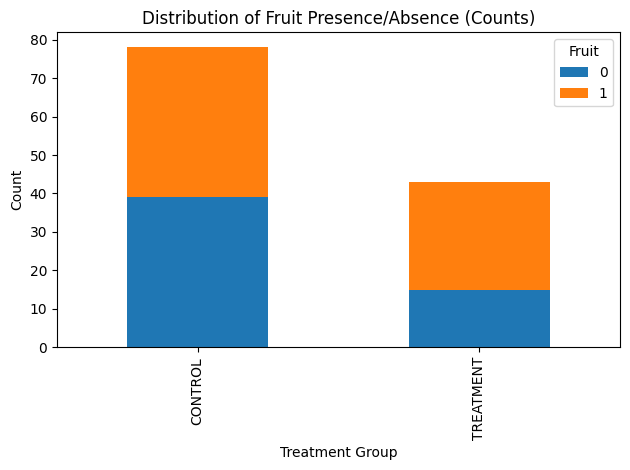

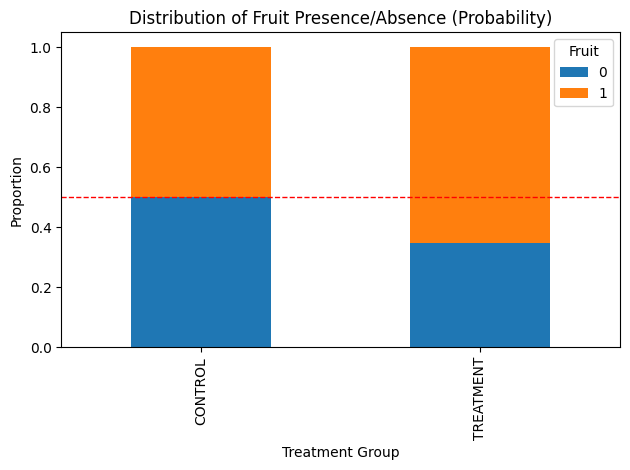

In [50]:
import matplotlib.pyplot as plt

# Plot the contingency table as a stacked bar plot (counts)
ax1 = contingency_table.plot(kind='bar', stacked=True)
plt.title('Distribution of Fruit Presence/Absence (Counts)')
plt.ylabel('Count')
plt.xlabel('Treatment Group')
plt.legend(title='Fruit', labels=['0', '1'])
plt.tight_layout()
plt.show()

# Also show as probability (proportion)
contingency_table_prob = contingency_table.div(contingency_table.sum(axis=1), axis=0)
ax2 = contingency_table_prob.plot(kind='bar', stacked=True)
plt.title('Distribution of Fruit Presence/Absence (Probability)')
plt.ylabel('Proportion')
plt.xlabel('Treatment Group')
plt.legend(title='Fruit', labels=['0', '1'])
plt.axhline(0.5, color='red', linestyle='--', linewidth=1, label='0.5')
plt.tight_layout()
plt.show()

### Genotype level
- Wilcoxson the fruit set

In [51]:
genotype_stats

,genotype_id,population,treatment,total_flowers,total_fruits,total_seeds,seed_set,fruit_set
0,K135,KUR,CONTROL,1,1.0,8.0,8.00,1.0
1,K136,KUR,CONTROL,2,0.0,0.0,0.00,0.0
2,K139,KUR,CONTROL,1,1.0,19.0,19.00,1.0
3,K140,KUR,CONTROL,5,4.0,117.0,29.25,0.8
4,K142,KUR,CONTROL,1,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...
88,N234,NET,CONTROL,1,0.0,0.0,0.00,0.0
89,N900,NET,CONTROL,1,0.0,0.0,0.00,0.0
90,N902,NET,TREATMENT,1,1.0,6.0,6.00,1.0
91,N906,NET,CONTROL,1,0.0,0.0,0.00,0.0


In [52]:
net_control = genotype_stats[(genotype_stats['population'] == 'NET') & (genotype_stats['treatment'] == 'CONTROL')]['fruit_set'].values
net_treatment = genotype_stats[(genotype_stats['population'] == 'NET') & (genotype_stats['treatment'] == 'TREATMENT')]['fruit_set'].values
kur = genotype_stats[(genotype_stats['population'] == 'KUR')]['fruit_set'].values


C:\Users\asaf4\AppData\Local\Temp\ipykernel_8988\2809898617.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([net_control, net_treatment,kur], labels=["NET CONTROL", "NET TREATMENT", "KUR"])


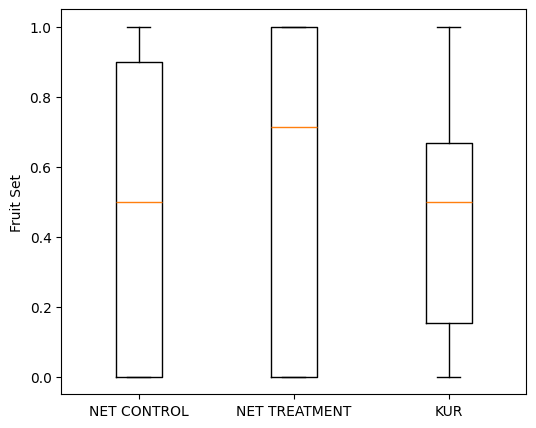

In [53]:
plt.figure(figsize=(6, 5))
plt.boxplot([net_control, net_treatment,kur], labels=["NET CONTROL", "NET TREATMENT", "KUR"])
plt.ylabel("Fruit Set")
# plt.title("Boxplot of Fruit Total: NET CONTROL vs NET TREATMENT")
plt.show()


In [54]:
group_summary_stats(net_control, net_treatment, variable_name="fruit set", group1_name="NET CONTROL", group2_name="NET TREATMENT")

WILCOXON RANK-SUM TEST: NET TREATMENT vs NET CONTROL
Testing if fruit set differs between NET TREATMENT and NET CONTROL groups

NET CONTROL group: n = 27 samples
NET TREATMENT group: n = 21 samples

DESCRIPTIVE STATISTICS:
------------------------------
NET CONTROL:
  Mean: 0.4994
  Median: 0.5000
  Std Dev: 0.3950
  Min: 0.0000
  Max: 1.0000

NET TREATMENT:
  Mean: 0.6197
  Median: 0.7143
  Std Dev: 0.4283
  Min: 0.0000
  Max: 1.0000

NORMALITY TESTS (Shapiro-Wilk):
------------------------------
NET CONTROL: Statistic = 0.8555, p-value = 0.0015
  → Data is NOT normally distributed (p < 0.05)
NET TREATMENT: Statistic = 0.7561, p-value = 0.0002
  → Data is NOT normally distributed (p < 0.05)

Note: Wilcoxon test is appropriate for fruit set regardless of normality



In [55]:
wilcoxon_group_analysis(
    net_control, net_treatment, 
    variable_label="fruit set", 
    group1_name="NET CONTROL", 
    group2_name="NET TREATMENT",
    alternative="less"
)

WILCOXON RANK-SUM TEST RESULTS for FRUIT SET:
----------------------------------------
Test Statistic (U): 230.0
P-value: 0.127474

Significance level (α): 0.05

✅ RESULT: NO SIGNIFICANT DIFFERENCE
   P-value (0.127474) ≥ α (0.05)
   → Fail to reject the null hypothesis
   → There is NO significant difference in fruit set between NET TREATMENT and NET CONTROL

EFFECT SIZE:
---------------
Rank-biserial correlation: 0.1887
Interpretation:
  → Small effect size

GROUP COMPARISON:
--------------------
NET CONTROL median fruit set: 0.5000
NET TREATMENT median fruit set: 0.7143
NET TREATMENT has higher median fruit set (+0.2143)


### Checking the total_fruits instead of fruit set 
- Still not significant

In [56]:
net_control = genotype_stats[(genotype_stats['population'] == 'NET') & (genotype_stats['treatment'] == 'CONTROL')]['total_fruits'].values
net_treatment = genotype_stats[(genotype_stats['population'] == 'NET') & (genotype_stats['treatment'] == 'TREATMENT')]['total_fruits'].values


C:\Users\asaf4\AppData\Local\Temp\ipykernel_8988\4207166432.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([net_control, net_treatment], labels=["NET CONTROL", "NET TREATMENT"])


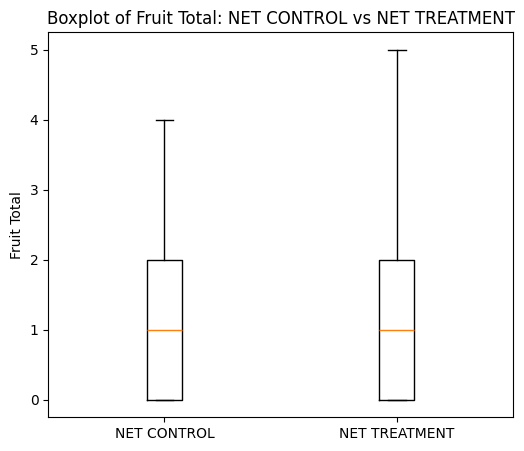

In [57]:
plt.figure(figsize=(6, 5))
plt.boxplot([net_control, net_treatment], labels=["NET CONTROL", "NET TREATMENT"])
plt.ylabel("Fruit Total")
plt.title("Boxplot of Fruit Total: NET CONTROL vs NET TREATMENT")
plt.show()


In [58]:
group_summary_stats(net_control, net_treatment, variable_name="total_fruits", group1_name="NET CONTROL", group2_name="NET TREATMENT")

WILCOXON RANK-SUM TEST: NET TREATMENT vs NET CONTROL
Testing if total_fruits differs between NET TREATMENT and NET CONTROL groups

NET CONTROL group: n = 27 samples
NET TREATMENT group: n = 21 samples

DESCRIPTIVE STATISTICS:
------------------------------
NET CONTROL:
  Mean: 1.4444
  Median: 1.0000
  Std Dev: 1.3681
  Min: 0.0000
  Max: 4.0000

NET TREATMENT:
  Mean: 1.3333
  Median: 1.0000
  Std Dev: 1.4259
  Min: 0.0000
  Max: 5.0000

NORMALITY TESTS (Shapiro-Wilk):
------------------------------
NET CONTROL: Statistic = 0.8469, p-value = 0.0010
  → Data is NOT normally distributed (p < 0.05)
NET TREATMENT: Statistic = 0.7925, p-value = 0.0005
  → Data is NOT normally distributed (p < 0.05)

Note: Wilcoxon test is appropriate for total_fruits regardless of normality



In [59]:
wilcoxon_group_analysis(
    net_control, net_treatment, 
    variable_label="fruit total", 
    group1_name="NET CONTROL", 
    group2_name="NET TREATMENT",
    alternative="less"
)

WILCOXON RANK-SUM TEST RESULTS for FRUIT TOTAL:
----------------------------------------
Test Statistic (U): 301.0
P-value: 0.651533

Significance level (α): 0.05

✅ RESULT: NO SIGNIFICANT DIFFERENCE
   P-value (0.651533) ≥ α (0.05)
   → Fail to reject the null hypothesis
   → There is NO significant difference in fruit total between NET TREATMENT and NET CONTROL

EFFECT SIZE:
---------------
Rank-biserial correlation: -0.0617
Interpretation:
  → Negligible effect size

GROUP COMPARISON:
--------------------
NET CONTROL median fruit total: 1.0000
NET TREATMENT median fruit total: 1.0000
Both groups have the same median fruit total


## Pollen limitation
- H0: Seed_treatment <= Seed_control
- H1: Seed_treatment > Seed_control


### Flower level - not valid (not i.i.d)
- Wilcoxson the seed count

In [60]:
df_net

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower Size (cm^2),tunnel_length,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,total_flowers
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0,1
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0,1
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0,3
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0,3
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,2024-03-06,29,NET,BLUE,N090,90.1,CONTROL,75.5,60.9,1.239737,45.9795,36.3,9.9,5.1,1.832787,7.489,1.0,34.0,1
124,125,2024-03-06,29,NET,BLUE,N098,98.1,TREATMENT,70.5,65.2,1.081288,45.9660,34.3,10.8,6.9,2.556036,10.928,1.0,2.0,1
125,126,2024-03-06,29,NET,BLUE,N103,103.1,TREATMENT,56.7,54.1,1.048059,30.6747,31.6,10.1,6.2,1.978792,11.095,1.0,39.0,1
126,127,2024-03-06,29,NET,BLUE,N199,199.2,CONTROL,75.0,53.5,1.401869,40.1250,32.6,11.3,7.4,2.726012,9.072,0.0,0.0,2


In [61]:
net_control = df_net[df_net['treatment'] == 'CONTROL']['seed'].values
net_treatment = df_net[df_net['treatment'] == 'TREATMENT']['seed'].values

In [62]:
kur_control = df[df['population'] == 'KUR']['seed'].values
kur_control

array([ 0.,  8., 22.,  0.,  0.,  3.,  0.,  0.,  0., 29.,  0., 12.,  0.,
       21.,  0., 48.,  0., 34., 60., 40.,  0.,  8.,  0.,  0.,  0.,  0.,
        3.,  9.,  0., 13.,  7., 22.,  0., 16.,  0.,  0., 30.,  0.,  0.,
       15., 15., 34., 12.,  7.,  0.,  0.,  0., 44.,  0.,  0.,  0.,  0.,
        0.,  8., 11.,  0., 24.,  7.,  0.,  0.,  0.,  0., 26., 42.,  0.,
        0.,  0.,  0.,  0.,  1., 40.,  0.,  0.,  0.,  2.,  0.,  7.,  0.,
       44.,  0., 22.,  0., 39., 26.,  0.,  0.,  0., 32.,  0.,  0.,  0.,
        0.,  0.,  2.,  0.,  5.,  7.,  2.,  0.,  0.,  6.,  8.,  0.,  0.,
        4.,  2., 14.,  3.,  0.,  0.,  8.,  9.,  0.,  2., 19.,  0., 12.,
        0., 60., 48.,  3., 18., 32.,  0.,  0., 34.,  0.,  0.,  0.,  0.,
        0., 28., 16.,  5.,  2.,  0.,  0.,  0.,  0., 20.,  0.,  0., 12.,
        2.,  0.,  0.,  0., 11., 15.,  0.,  0.,  0.,  0., 46.,  0., 18.,
        0., 29., 18.,  0.,  0.,  0., 13.,  0.,  0.])

C:\Users\asaf4\AppData\Local\Temp\ipykernel_8988\855801598.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([net_control, net_treatment], labels=["NET CONTROL", "NET TREATMENT"])


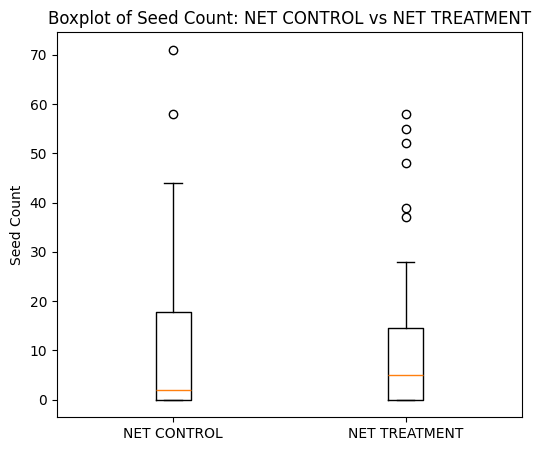

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.boxplot([net_control, net_treatment], labels=["NET CONTROL", "NET TREATMENT"])
plt.ylabel("Seed Count")
plt.title("Boxplot of Seed Count: NET CONTROL vs NET TREATMENT")
plt.show()


C:\Users\asaf4\AppData\Local\Temp\ipykernel_8988\4046858130.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([net_control, net_treatment,kur_control], labels=["NET CONTROL", "NET TREATMENT","KUR CONTROL"])


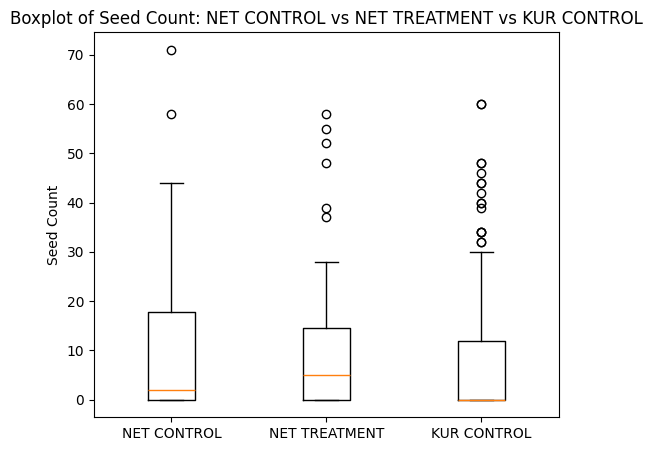

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.boxplot([net_control, net_treatment,kur_control], labels=["NET CONTROL", "NET TREATMENT","KUR CONTROL"])
plt.ylabel("Seed Count")
plt.title("Boxplot of Seed Count: NET CONTROL vs NET TREATMENT vs KUR CONTROL")
plt.show()


In [65]:
group_summary_stats(net_control, net_treatment, variable_name="seed count", group1_name="NET CONTROL", group2_name="NET TREATMENT")

WILCOXON RANK-SUM TEST: NET TREATMENT vs NET CONTROL
Testing if seed count differs between NET TREATMENT and NET CONTROL groups

NET CONTROL group: n = 78 samples
NET TREATMENT group: n = 43 samples

DESCRIPTIVE STATISTICS:
------------------------------
NET CONTROL:
  Mean: 10.5897
  Median: 2.0000
  Std Dev: 14.8319
  Min: 0.0000
  Max: 71.0000

NET TREATMENT:
  Mean: 11.7674
  Median: 5.0000
  Std Dev: 16.8280
  Min: 0.0000
  Max: 58.0000

NORMALITY TESTS (Shapiro-Wilk):
------------------------------
NET CONTROL: Statistic = 0.7518, p-value = 0.0000
  → Data is NOT normally distributed (p < 0.05)
NET TREATMENT: Statistic = 0.7242, p-value = 0.0000
  → Data is NOT normally distributed (p < 0.05)

Note: Wilcoxon test is appropriate for seed count regardless of normality



In [66]:
wilcoxon_group_analysis(
    net_control, net_treatment, 
    variable_label="seed count", 
    group1_name="NET CONTROL", 
    group2_name="NET TREATMENT",
    alternative="less"
)

WILCOXON RANK-SUM TEST RESULTS for SEED COUNT:
----------------------------------------
Test Statistic (U): 1562.0
P-value: 0.257939

Significance level (α): 0.05

✅ RESULT: NO SIGNIFICANT DIFFERENCE
   P-value (0.257939) ≥ α (0.05)
   → Fail to reject the null hypothesis
   → There is NO significant difference in seed count between NET TREATMENT and NET CONTROL

EFFECT SIZE:
---------------
Rank-biserial correlation: 0.0686
Interpretation:
  → Negligible effect size

GROUP COMPARISON:
--------------------
NET CONTROL median seed count: 2.0000
NET TREATMENT median seed count: 5.0000
NET TREATMENT has higher median seed count (+3.0000)


### Genotype level
- Wilcoxson the seed set
- seed set = #seeds in the geontype / #of fruits in the genotype

In [67]:
net_control = genotype_stats[(genotype_stats['population'] == 'NET') & (genotype_stats['treatment'] == 'CONTROL')]['seed_set'].values
net_treatment = genotype_stats[(genotype_stats['population'] == 'NET') & (genotype_stats['treatment'] == 'TREATMENT')]['seed_set'].values
kur = genotype_stats[(genotype_stats['population'] == 'KUR')]['seed_set'].values

C:\Users\asaf4\AppData\Local\Temp\ipykernel_8988\1483830517.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([net_control, net_treatment,kur], labels=["NET CONTROL", "NET TREATMENT","KUR"])


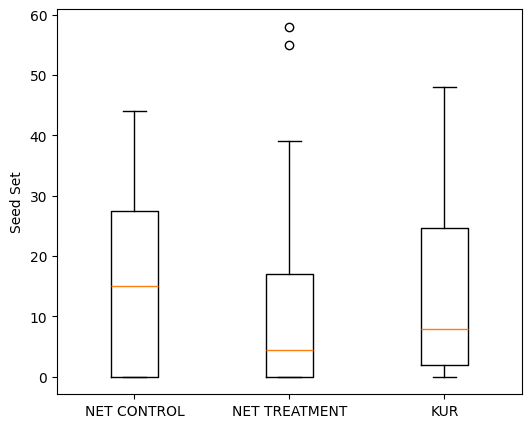

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.boxplot([net_control, net_treatment,kur], labels=["NET CONTROL", "NET TREATMENT","KUR"])
plt.ylabel("Seed Set")
# plt.title("Boxplot of Seed Set: NET CONTROL vs NET TREATMENT")
plt.show()


In [69]:
group_summary_stats(net_control, net_treatment, variable_name="seed set", group1_name="NET CONTROL", group2_name="NET TREATMENT")

WILCOXON RANK-SUM TEST: NET TREATMENT vs NET CONTROL
Testing if seed set differs between NET TREATMENT and NET CONTROL groups

NET CONTROL group: n = 27 samples
NET TREATMENT group: n = 21 samples

DESCRIPTIVE STATISTICS:
------------------------------
NET CONTROL:
  Mean: 15.9753
  Median: 15.0000
  Std Dev: 13.5854
  Min: 0.0000
  Max: 44.0000

NET TREATMENT:
  Mean: 12.8071
  Median: 4.5000
  Std Dev: 18.0459
  Min: 0.0000
  Max: 58.0000

NORMALITY TESTS (Shapiro-Wilk):
------------------------------
NET CONTROL: Statistic = 0.9069, p-value = 0.0193
  → Data is NOT normally distributed (p < 0.05)
NET TREATMENT: Statistic = 0.7303, p-value = 0.0001
  → Data is NOT normally distributed (p < 0.05)

Note: Wilcoxon test is appropriate for seed set regardless of normality



In [70]:
wilcoxon_group_analysis(
    net_control, net_treatment, 
    variable_label="seed set", 
    group1_name="NET CONTROL", 
    group2_name="NET TREATMENT",
    alternative="less"
)

WILCOXON RANK-SUM TEST RESULTS for SEED SET:
----------------------------------------
Test Statistic (U): 335.5
P-value: 0.865401

Significance level (α): 0.05

✅ RESULT: NO SIGNIFICANT DIFFERENCE
   P-value (0.865401) ≥ α (0.05)
   → Fail to reject the null hypothesis
   → There is NO significant difference in seed set between NET TREATMENT and NET CONTROL

EFFECT SIZE:
---------------
Rank-biserial correlation: -0.1834
Interpretation:
  → Small effect size

GROUP COMPARISON:
--------------------
NET CONTROL median seed set: 15.0000
NET TREATMENT median seed set: 4.5000
NET CONTROL has higher median seed set (+10.5000)


### Compare Seed total

In [71]:
net_control = genotype_stats[(genotype_stats['population'] == 'NET') & (genotype_stats['treatment'] == 'CONTROL')]['total_seeds'].values
net_treatment = genotype_stats[(genotype_stats['population'] == 'NET') & (genotype_stats['treatment'] == 'TREATMENT')]['total_seeds'].values

C:\Users\asaf4\AppData\Local\Temp\ipykernel_8988\3117700364.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([net_control, net_treatment], labels=["NET CONTROL", "NET TREATMENT"])


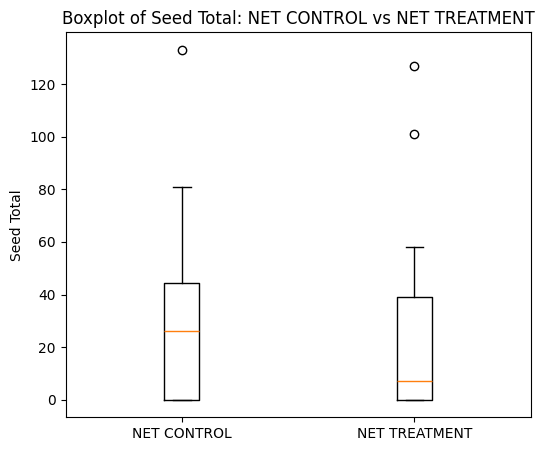

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.boxplot([net_control, net_treatment], labels=["NET CONTROL", "NET TREATMENT"])
plt.ylabel("Seed Total")
plt.title("Boxplot of Seed Total: NET CONTROL vs NET TREATMENT")
plt.show()


In [73]:
group_summary_stats(net_control, net_treatment, variable_name="Total Seeds", group1_name="NET CONTROL", group2_name="NET TREATMENT")

WILCOXON RANK-SUM TEST: NET TREATMENT vs NET CONTROL
Testing if Total Seeds differs between NET TREATMENT and NET CONTROL groups

NET CONTROL group: n = 27 samples
NET TREATMENT group: n = 21 samples

DESCRIPTIVE STATISTICS:
------------------------------
NET CONTROL:
  Mean: 30.5926
  Median: 26.0000
  Std Dev: 31.5647
  Min: 0.0000
  Max: 133.0000

NET TREATMENT:
  Mean: 24.0952
  Median: 7.0000
  Std Dev: 35.9192
  Min: 0.0000
  Max: 127.0000

NORMALITY TESTS (Shapiro-Wilk):
------------------------------
NET CONTROL: Statistic = 0.8591, p-value = 0.0018
  → Data is NOT normally distributed (p < 0.05)
NET TREATMENT: Statistic = 0.7161, p-value = 0.0000
  → Data is NOT normally distributed (p < 0.05)

Note: Wilcoxon test is appropriate for Total Seeds regardless of normality



In [74]:
wilcoxon_group_analysis(
    net_control, net_treatment, 
    variable_label="seed total", 
    group1_name="NET CONTROL", 
    group2_name="NET TREATMENT",
    alternative="less"
)

WILCOXON RANK-SUM TEST RESULTS for SEED TOTAL:
----------------------------------------
Test Statistic (U): 326.0
P-value: 0.817267

Significance level (α): 0.05

✅ RESULT: NO SIGNIFICANT DIFFERENCE
   P-value (0.817267) ≥ α (0.05)
   → Fail to reject the null hypothesis
   → There is NO significant difference in seed total between NET TREATMENT and NET CONTROL

EFFECT SIZE:
---------------
Rank-biserial correlation: -0.1499
Interpretation:
  → Small effect size

GROUP COMPARISON:
--------------------
NET CONTROL median seed total: 26.0000
NET TREATMENT median seed total: 7.0000
NET CONTROL has higher median seed total (+19.0000)


## Quantity of Flowers per genotype - Control vs Treatment

In [75]:
genotype_stats

,genotype_id,population,treatment,total_flowers,total_fruits,total_seeds,seed_set,fruit_set
0,K135,KUR,CONTROL,1,1.0,8.0,8.00,1.0
1,K136,KUR,CONTROL,2,0.0,0.0,0.00,0.0
2,K139,KUR,CONTROL,1,1.0,19.0,19.00,1.0
3,K140,KUR,CONTROL,5,4.0,117.0,29.25,0.8
4,K142,KUR,CONTROL,1,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...
88,N234,NET,CONTROL,1,0.0,0.0,0.00,0.0
89,N900,NET,CONTROL,1,0.0,0.0,0.00,0.0
90,N902,NET,TREATMENT,1,1.0,6.0,6.00,1.0
91,N906,NET,CONTROL,1,0.0,0.0,0.00,0.0


In [76]:
net_control = genotype_stats[(genotype_stats['population'] == 'NET') & (genotype_stats['treatment'] == 'CONTROL')]['total_flowers'].values
net_treatment = genotype_stats[(genotype_stats['population'] == 'NET') & (genotype_stats['treatment'] == 'TREATMENT')]['total_flowers'].values
kur = genotype_stats[(genotype_stats['population'] == 'KUR') ]['total_flowers'].values

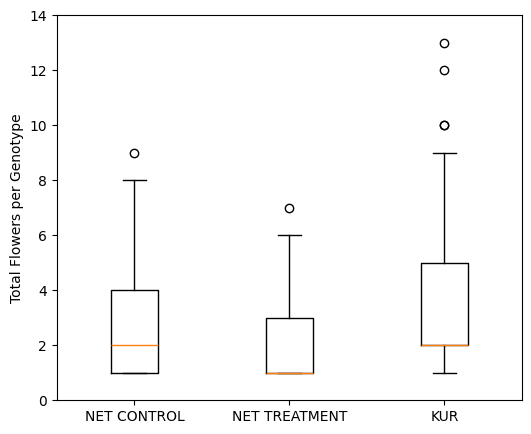

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.boxplot([net_control, net_treatment,kur], tick_labels=["NET CONTROL", "NET TREATMENT","KUR"])
plt.ylabel("Total Flowers per Genotype")
plt.ylim(0, 14)
# plt.title("Boxplot of Total Flowers per Genotype: NET CONTROL vs NET TREATMENT vs KUR")
plt.show()


In [78]:
group_summary_stats(net_control, net_treatment, variable_name="total_flowers", group1_name="NET CONTROL", group2_name="NET TREATMENT")

WILCOXON RANK-SUM TEST: NET TREATMENT vs NET CONTROL
Testing if total_flowers differs between NET TREATMENT and NET CONTROL groups

NET CONTROL group: n = 27 samples
NET TREATMENT group: n = 21 samples

DESCRIPTIVE STATISTICS:
------------------------------
NET CONTROL:
  Mean: 2.8889
  Median: 2.0000
  Std Dev: 2.2072
  Min: 1.0000
  Max: 9.0000

NET TREATMENT:
  Mean: 2.0476
  Median: 1.0000
  Std Dev: 1.8835
  Min: 1.0000
  Max: 7.0000

NORMALITY TESTS (Shapiro-Wilk):
------------------------------
NET CONTROL: Statistic = 0.8064, p-value = 0.0002
  → Data is NOT normally distributed (p < 0.05)
NET TREATMENT: Statistic = 0.6277, p-value = 0.0000
  → Data is NOT normally distributed (p < 0.05)

Note: Wilcoxon test is appropriate for total_flowers regardless of normality



In [79]:
wilcoxon_group_analysis(
    net_control, net_treatment, 
    variable_label="total flowers", 
    group1_name="NET CONTROL", 
    group2_name="NET TREATMENT",
    alternative="two-sided"
)

WILCOXON RANK-SUM TEST RESULTS for TOTAL FLOWERS:
----------------------------------------
Test Statistic (U): 372.5
P-value: 0.048643

Significance level (α): 0.05

🚨 RESULT: SIGNIFICANT DIFFERENCE
   P-value (0.048643) < α (0.05)
   → Reject the null hypothesis
   → There IS a significant difference in total flowers between NET TREATMENT and NET CONTROL

EFFECT SIZE:
---------------
Rank-biserial correlation: -0.3139
Interpretation:
  → Medium effect size

GROUP COMPARISON:
--------------------
NET CONTROL median total flowers: 2.0000
NET TREATMENT median total flowers: 1.0000
NET CONTROL has higher median total flowers (+1.0000)


### Check correlation of flower count to seed sed per genotype id

In [80]:
genotype_stats_net_control = genotype_stats[(genotype_stats['population'] == 'NET') & (genotype_stats['treatment'] == 'CONTROL')]
genotype_stats_net_treatment = genotype_stats[(genotype_stats['population'] == 'NET') & (genotype_stats['treatment'] == 'TREATMENT')]
genotype_stats_kur = genotype_stats[(genotype_stats['population'] == 'KUR')]

Pearson correlation between total flowers and seed set: r = 0.299, p = 0.1295
Spearman correlation between total flowers and seed set: r = 0.299, p = 0.1298


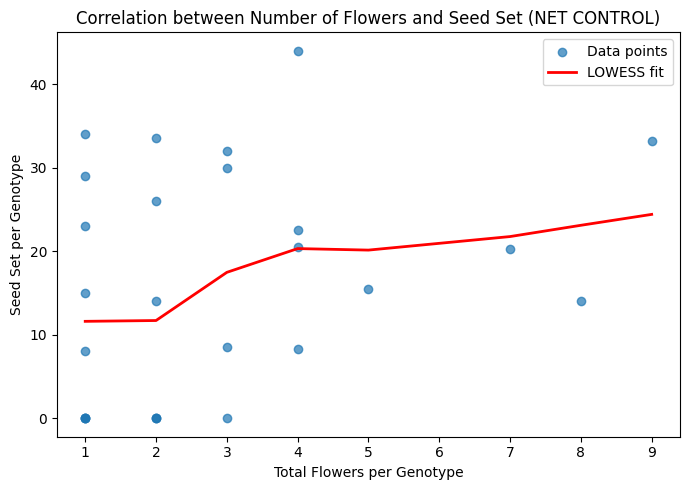

In [81]:
# Check correlation between number of flowers and seed set per genotype (NET CONTROL)
import scipy.stats as stats
import statsmodels.api as sm

# Calculate Pearson and Spearman correlation
pearson_corr, pearson_p = stats.pearsonr(genotype_stats_net_control['total_flowers'], genotype_stats_net_control['seed_set'])
spearman_corr, spearman_p = stats.spearmanr(genotype_stats_net_control['total_flowers'], genotype_stats_net_control['seed_set'])

print(f"Pearson correlation between total flowers and seed set: r = {pearson_corr:.3f}, p = {pearson_p:.4f}")
print(f"Spearman correlation between total flowers and seed set: r = {spearman_corr:.3f}, p = {spearman_p:.4f}")

# Scatter plot with LOWESS
x = genotype_stats_net_control['total_flowers']
y = genotype_stats_net_control['seed_set']

plt.figure(figsize=(7,5))
plt.scatter(x, y, alpha=0.7, label='Data points')

# Fit and plot LOWESS (locally weighted scatterplot smoothing)
lowess = sm.nonparametric.lowess
lowess_result = lowess(y, x, frac=0.6)
plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='red', linewidth=2, label='LOWESS fit')

plt.xlabel("Total Flowers per Genotype")
plt.ylabel("Seed Set per Genotype")
plt.title("Correlation between Number of Flowers and Seed Set (NET CONTROL)")
plt.legend()
plt.tight_layout()
plt.show()


Pearson correlation between total flowers and seed set: r = 0.137, p = 0.5524
Spearman correlation between total flowers and seed set: r = 0.403, p = 0.0701


C:\Users\asaf4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


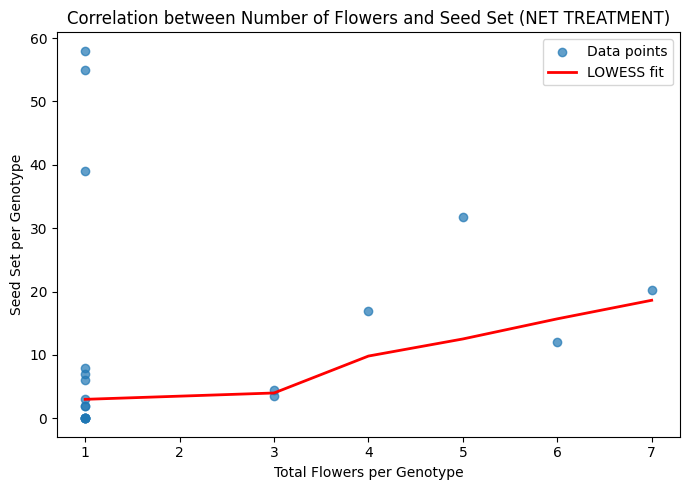

In [82]:
# Check correlation between number of flowers and seed set per genotype
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np

# Calculate Pearson and Spearman correlation
pearson_corr, pearson_p = stats.pearsonr(genotype_stats_net_treatment['total_flowers'], genotype_stats_net_treatment['seed_set'])
spearman_corr, spearman_p = stats.spearmanr(genotype_stats_net_treatment['total_flowers'], genotype_stats_net_treatment['seed_set'])

print(f"Pearson correlation between total flowers and seed set: r = {pearson_corr:.3f}, p = {pearson_p:.4f}")
print(f"Spearman correlation between total flowers and seed set: r = {spearman_corr:.3f}, p = {spearman_p:.4f}")

# Scatter plot with LOWESS
x = genotype_stats_net_treatment['total_flowers']
y = genotype_stats_net_treatment['seed_set']

plt.figure(figsize=(7,5))
plt.scatter(x, y, alpha=0.7, label='Data points')

# Fit and plot LOWESS (locally weighted scatterplot smoothing)
lowess = sm.nonparametric.lowess
lowess_result = lowess(y, x, frac=0.6)
plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='red', linewidth=2, label='LOWESS fit')

plt.xlabel("Total Flowers per Genotype")
plt.ylabel("Seed Set per Genotype")
plt.title("Correlation between Number of Flowers and Seed Set (NET TREATMENT)")
plt.legend()
plt.tight_layout()
plt.show()


Pearson correlation between total flowers and seed set (KUR): r = 0.198, p = 0.1914
Spearman correlation between total flowers and seed set (KUR): r = 0.308, p = 0.0399


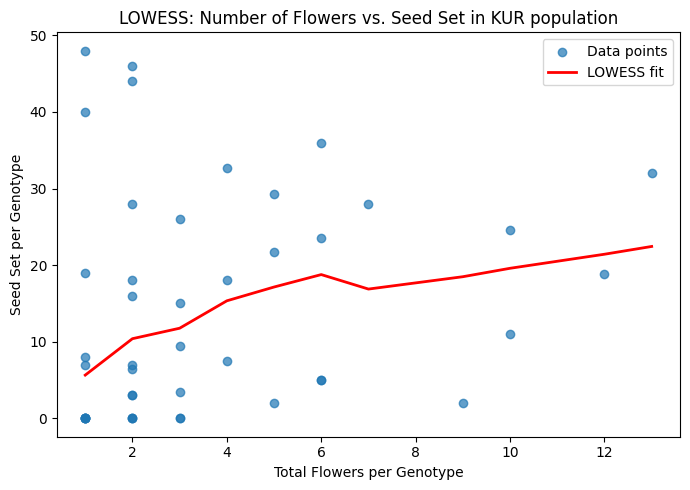

Number of subjects: 45


In [83]:
# Visualize relationship between number of flowers and seed set per genotype using LOWESS
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats

x = genotype_stats_kur['total_flowers']
y = genotype_stats_kur['seed_set']

# Calculate Pearson and Spearman correlation
pearson_corr, pearson_p = stats.pearsonr(x, y)
spearman_corr, spearman_p = stats.spearmanr(x, y)

print(f"Pearson correlation between total flowers and seed set (KUR): r = {pearson_corr:.3f}, p = {pearson_p:.4f}")
print(f"Spearman correlation between total flowers and seed set (KUR): r = {spearman_corr:.3f}, p = {spearman_p:.4f}")

plt.figure(figsize=(7,5))
plt.scatter(x, y, alpha=0.7, label='Data points')

# Fit and plot LOWESS (locally weighted scatterplot smoothing)
lowess = sm.nonparametric.lowess
lowess_result = lowess(y, x, frac=0.6)
plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='red', linewidth=2, label='LOWESS fit')

plt.xlabel("Total Flowers per Genotype")
plt.ylabel("Seed Set per Genotype")
plt.title("LOWESS: Number of Flowers vs. Seed Set in KUR population")
plt.legend()
plt.tight_layout()
plt.show()
print("Number of subjects:", len(genotype_stats_kur))


## Matching with total flowers

In [84]:
from sklearn.linear_model import LogisticRegression

def estimate_propensity_scores(df, confounders, treatment_col='treatment_binary'):
    """
    Estimate propensity scores using logistic regression
    """
    X = df[confounders]
    y = df[treatment_col]
    
    # Standardize confounders
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit logistic regression
    lr = LogisticRegression(random_state=42)
    lr.fit(X_scaled, y)
    
    # Predict propensity scores
    propensity_scores = lr.predict_proba(X_scaled)[:, 1]
    
    return propensity_scores, lr, scaler


In [85]:
genotype_stats_net = genotype_stats[genotype_stats['population'] == 'NET'].reset_index(drop=True)


In [86]:
genotype_stats_net['treatment_binary'] = (genotype_stats_net['treatment'] == 'TREATMENT').astype(int)

confounders = ['total_flowers']

# Estimate propensity scores
ps_scores, lr_model, scaler = estimate_propensity_scores(genotype_stats_net, confounders)
genotype_stats_net['propensity_score'] = ps_scores

print("Propensity Score Summary:")
print(f"Mean PS for CONTROL: {genotype_stats_net[genotype_stats_net['treatment_binary']==0]['propensity_score'].mean():.3f}")
print(f"Mean PS for TREATMENT: {genotype_stats_net[genotype_stats_net['treatment_binary']==1]['propensity_score'].mean():.3f}")
print(f"Overall PS range: {ps_scores.min():.3f} - {ps_scores.max():.3f}")

Propensity Score Summary:
Mean PS for CONTROL: 0.421
Mean PS for TREATMENT: 0.459
Overall PS range: 0.177 - 0.508


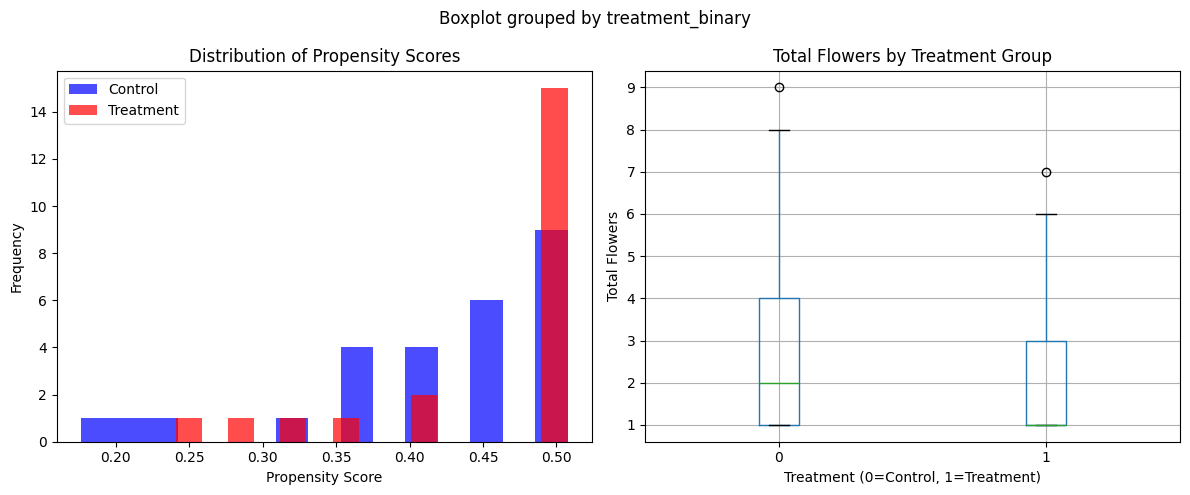

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of propensity scores by treatment group
axes[0].hist(genotype_stats_net[genotype_stats_net['treatment_binary']==0]['propensity_score'], 
             alpha=0.7, label='Control', bins=15, color='blue')
axes[0].hist(genotype_stats_net[genotype_stats_net['treatment_binary']==1]['propensity_score'], 
             alpha=0.7, label='Treatment', bins=15, color='red')
axes[0].set_xlabel('Propensity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Propensity Scores')
axes[0].legend()

# Box plot of total_flower by treatment (main confounder)
genotype_stats_net.boxplot(column='total_flowers', by='treatment_binary', ax=axes[1])
axes[1].set_title('Total Flowers by Treatment Group')
axes[1].set_xlabel('Treatment (0=Control, 1=Treatment)')
axes[1].set_ylabel('Total Flowers')

plt.tight_layout()
plt.show()

In [88]:
def match_genotypes_on_total_flowers(df, treatment_col='treatment_binary'):
    """
    Match each treated genotype with the control genotype having the closest total_flower count
    """
    treated_genotypes = df[df[treatment_col] == 1].copy().reset_index(drop=True)
    control_genotypes = df[df[treatment_col] == 0].copy().reset_index(drop=True)
    
    print(f"Matching {len(treated_genotypes)} SUPP genotypes with {len(control_genotypes)} CONTROL genotypes")
    
    if len(control_genotypes) == 0:
        print("No control genotypes available for matching!")
        return pd.DataFrame()
    
    matched_pairs = []
    used_controls = set()
    
    # Sort treated genotypes by total_flower for systematic matching
    treated_genotypes = treated_genotypes.sort_values('total_flowers')
    
    for _, treated_row in treated_genotypes.iterrows():
        treated_flowers = treated_row['total_flowers']
        
        # Find control genotype with closest total_flower count
        available_controls = control_genotypes[~control_genotypes.index.isin(used_controls)]
        
        if len(available_controls) > 0:
            # Calculate absolute differences in total_flower
            flower_differences = abs(available_controls['total_flowers'] - treated_flowers)
            best_match_idx = flower_differences.idxmin()
            best_control = available_controls.loc[best_match_idx]
            
            distance = abs(treated_flowers - best_control['total_flowers'])
            
            matched_pairs.append({
                'treated_genotype': treated_row['genotype_id'],
                'control_genotype': best_control['genotype_id'],
                'treated_idx': treated_row.name,
                'control_idx': best_match_idx,
                'treated_total_flowers': treated_flowers,
                'control_total_flowers': best_control['total_flowers'],
                'flower_difference': distance
            })
            
            used_controls.add(best_match_idx)
    
    return pd.DataFrame(matched_pairs)

# Perform the matching
matched_genotypes = match_genotypes_on_total_flowers(genotype_stats_net)

print(f"\n=== MATCHING RESULTS ===")
print(f"Successfully matched: {len(matched_genotypes)} pairs")
print(f"Match rate: {len(matched_genotypes)/(genotype_stats_net['treatment_binary']==1).sum():.1%}")

if len(matched_genotypes) > 0:
    print(f"\nFlower count differences:")
    print(f"Mean difference: {matched_genotypes['flower_difference'].mean():.1f} flowers")
    print(f"Median difference: {matched_genotypes['flower_difference'].median():.1f} flowers") 
    print(f"Range: {matched_genotypes['flower_difference'].min():.0f} - {matched_genotypes['flower_difference'].max():.0f} flowers")
    

Matching 21 SUPP genotypes with 27 CONTROL genotypes

=== MATCHING RESULTS ===
Successfully matched: 21 pairs
Match rate: 100.0%

Flower count differences:
Mean difference: 0.4 flowers
Median difference: 0.0 flowers
Range: 0 - 1 flowers


In [89]:
matched_genotypes

,treated_genotype,control_genotype,treated_idx,control_idx,treated_total_flowers,control_total_flowers,flower_difference
0,N006,N007,0,0,1,1,0
1,N016,N049,2,3,1,1,0
2,N017,N090,3,9,1,1,0
3,N073,N119,4,10,1,1,0
4,N098,N167,6,12,1,1,0
5,N075,N170,5,13,1,1,0
6,N103,N234,7,24,1,1,0
7,N111,N900,8,25,1,1,0
8,N185,N906,12,26,1,1,0
9,N122,N041,9,1,1,2,1


In [90]:
# Check the quality of matching on total_flowers
def check_flower_balance(df, matched_pairs):
    """
    Check balance specifically for total_flower matching
    """
    treated_flowers = []
    control_flowers = []
    
    for _, pair in matched_pairs.iterrows():
        treated_val = df.loc[pair['treated_idx'], 'total_flowers']
        control_val = df.loc[pair['control_idx'], 'total_flowers'] 
        treated_flowers.append(treated_val)
        control_flowers.append(control_val)
    
    treated_flowers = np.array(treated_flowers)
    control_flowers = np.array(control_flowers)
    
    # Before matching statistics
    all_treated = df[df['treatment_binary']==1]['total_flowers']
    all_control = df[df['treatment_binary']==0]['total_flowers']
    
    from scipy.stats import ttest_ind, ttest_rel, mannwhitneyu, wilcoxon

    # Independent t-test before matching
    t_before, p_before = ttest_ind(all_treated, all_control)
    # Mann-Whitney U test (Wilcoxon rank-sum) before matching
    u_before, p_u_before = mannwhitneyu(all_treated, all_control, alternative='two-sided')

    # Paired t-test after matching
    t_after, p_after = ttest_rel(treated_flowers, control_flowers)
    # Wilcoxon signed-rank test after matching
    try:
        w_after, p_w_after = wilcoxon(treated_flowers, control_flowers)
    except ValueError:
        w_after, p_w_after = (float('nan'), float('nan'))

    print("\n=== BALANCE CHECK: TOTAL FLOWERS ===")
    print(f"BEFORE MATCHING:")
    print(f"  SUPP mean: {all_treated.mean():.1f} flowers")
    print(f"  CONTROL mean: {all_control.mean():.1f} flowers")
    print(f"  Difference: {all_treated.mean() - all_control.mean():.1f} flowers")
    print(f"  T-test p-value: {p_before:.4f}")
    print(f"  Mann-Whitney U p-value: {p_u_before:.4f}")

    print(f"\nAFTER MATCHING:")
    print(f"  SUPP mean: {treated_flowers.mean():.1f} flowers")
    print(f"  CONTROL mean: {control_flowers.mean():.1f} flowers") 
    print(f"  Difference: {treated_flowers.mean() - control_flowers.mean():.1f} flowers")
    print(f"  Paired t-test p-value: {p_after:.4f}")
    print(f"  Wilcoxon signed-rank p-value: {p_w_after:.4f}")

    # Calculate improvement
    diff_before = abs(all_treated.mean() - all_control.mean())
    diff_after = abs(treated_flowers.mean() - control_flowers.mean())
    improvement = ((diff_before - diff_after) / diff_before) * 100

    print(f"\nBALANCE IMPROVEMENT: {improvement:.1f}%")
    
    return {
        'before_treated_mean': all_treated.mean(),
        'before_control_mean': all_control.mean(),
        'after_treated_mean': treated_flowers.mean(),
        'after_control_mean': control_flowers.mean(),
        'improvement_percent': improvement
    }

if len(matched_genotypes) > 0:

    balance_stats = check_flower_balance(genotype_stats_net, matched_genotypes)


=== BALANCE CHECK: TOTAL FLOWERS ===
BEFORE MATCHING:
  SUPP mean: 2.0 flowers
  CONTROL mean: 2.9 flowers
  Difference: -0.8 flowers
  T-test p-value: 0.1697
  Mann-Whitney U p-value: 0.0486

AFTER MATCHING:
  SUPP mean: 1.8 flowers
  CONTROL mean: 1.8 flowers
  Difference: -0.0 flowers
  Paired t-test p-value: 0.8966
  Wilcoxon signed-rank p-value: 0.8117

BALANCE IMPROVEMENT: 94.3%


In [91]:
genotype_stats_net

,genotype_id,population,treatment,total_flowers,total_fruits,total_seeds,seed_set,fruit_set,treatment_binary,propensity_score
0,N006,NET,TREATMENT,1,1.0,3.0,3.0000,1.0000,1,0.507536
1,N007,NET,CONTROL,1,1.0,15.0,15.0000,1.0000,0,0.507536
2,N012,NET,TREATMENT,5,4.0,127.0,31.7500,0.8000,1,0.319783
3,N016,NET,TREATMENT,1,0.0,0.0,0.0000,0.0000,1,0.507536
4,N017,NET,TREATMENT,1,1.0,7.0,7.0000,1.0000,1,0.507536
5,N041,NET,CONTROL,2,0.0,0.0,0.0000,0.0000,0,0.458574
6,N043,NET,CONTROL,2,2.0,67.0,33.5000,1.0000,0,0.458574
7,N049,NET,CONTROL,1,0.0,0.0,0.0000,0.0000,0,0.507536
8,N050,NET,CONTROL,3,1.0,32.0,32.0000,0.3333,0,0.410400
9,N051,NET,CONTROL,3,0.0,0.0,0.0000,0.0000,0,0.410400


In [92]:
matched_genotypes

,treated_genotype,control_genotype,treated_idx,control_idx,treated_total_flowers,control_total_flowers,flower_difference
0,N006,N007,0,0,1,1,0
1,N016,N049,2,3,1,1,0
2,N017,N090,3,9,1,1,0
3,N073,N119,4,10,1,1,0
4,N098,N167,6,12,1,1,0
5,N075,N170,5,13,1,1,0
6,N103,N234,7,24,1,1,0
7,N111,N900,8,25,1,1,0
8,N185,N906,12,26,1,1,0
9,N122,N041,9,1,1,2,1


In [93]:
treated_flowers = []
control_flowers = []

for _, pair in matched_genotypes.iterrows():
    treated_val = genotype_stats_net.loc[genotype_stats_net['genotype_id'] == pair['treated_genotype'], 'fruit_set'].values[0]
    control_val = genotype_stats_net.loc[genotype_stats_net['genotype_id'] == pair['control_genotype'], 'fruit_set'].values[0]
    treated_flowers.append(treated_val)
    control_flowers.append(control_val)

treated_flowers = np.array(treated_flowers)
control_flowers = np.array(control_flowers)

In [94]:
treated_flowers

array([1.    , 0.    , 1.    , 1.    , 1.    , 1.    , 1.    , 0.    ,
       1.    , 0.    , 0.    , 1.    , 1.    , 0.    , 0.    , 0.6667,
       0.6667, 0.5   , 0.8   , 0.6667, 0.7143])

In [95]:
control_flowers

array([1.    , 0.    , 1.    , 1.    , 1.    , 1.    , 0.    , 0.    ,
       0.    , 0.    , 1.    , 0.5   , 0.    , 1.    , 0.    , 0.3333,
       0.    , 0.25  , 0.8   , 0.5714, 0.5   ])

In [96]:
u_after, p_u_after = mannwhitneyu(control_flowers,treated_flowers, alternative='less')

print(f"\nAFTER MATCHING:")
print(f"  SUPP mean: {treated_flowers.mean():.1f} fruit set")
print(f"  CONTROL mean: {control_flowers.mean():.1f} fruit set") 
print(f"  Difference: {treated_flowers.mean() - control_flowers.mean():.1f} fruit set")
print(f"  Mann-Whitney U p-value: {p_u_after:.4f}")


AFTER MATCHING:
  SUPP mean: 0.6 fruit set
  CONTROL mean: 0.5 fruit set
  Difference: 0.1 fruit set
  Mann-Whitney U p-value: 0.1642


## Normality of Covariates

In [97]:
covariates = ['flower_size_std', 'tunnel_vol_std', 'bp_area_std']

In [99]:
# # Check normality of the covariates
# for covariate in covariates:
#     stat_control, p_control = shapiro(df_net[covariate])
#     print(f"{covariate}: Statistic = {stat_control:.4f}, p-value = {p_control:.4f}")
#     if p_control < 0.05:
#         print("  → Data is NOT normally distributed (p < 0.05)")
#     else:
#         print("  → Data appears normally distributed (p ≥ 0.05)")

## Genotype id is influencing the seed count
- maybe check intercept and slope

In [ ]:
# # Define the model formulas for glmmTMB
# # We model both the count and the zero-inflation part with the same predictors
# # including interactions and a random intercept for genotype_id.
# count_formula = "seed ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std ) + (1|genotype_id) + offset(log(mean_seed_by_group))"
# zi_formula = "~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std ) + (1|genotype_id) + offset(log(mean_seed_by_group))"

# print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
# print("-" * 60)
# print(f"Count Formula: {count_formula}")
# print(f"Zero-Inflation Formula: {zi_formula}")
# print(f"Sample size: {len(df_net)} flowers from {df_net['genotype_id'].nunique()} genotypes")
# print()

# # Convert pandas dataframe to R dataframe
# with localconverter(ro.default_converter + pandas2ri.converter):
#   r_df_net = ro.conversion.py2rpy(df_net)

# # Fit the model
# zinb_mixed_model = glmmTMB.glmmTMB(
#     formula=ro.Formula(count_formula),
#     ziformula=ro.Formula(zi_formula),
#     data=r_df_net,
#     family=glmmTMB.truncated_nbinom2
# )

# # Print the model summary
# print("MODEL SUMMARY:")
# print(base.summary(zinb_mixed_model))


FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...
------------------------------------------------------------
Count Formula: seed ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std ) + (1|genotype_id) + offset(log(mean_seed_by_group))
Zero-Inflation Formula: ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std ) + (1|genotype_id) + offset(log(mean_seed_by_group))
Sample size: 121 flowers from 48 genotypes



NameError: name 'localconverter' is not defined

## Distribution of target variables 

### Flower level - seed count

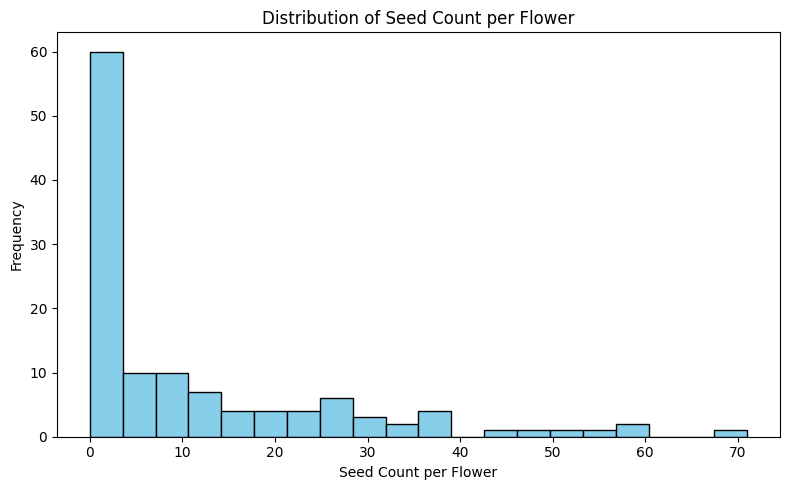

In [101]:
# Plot histogram of seed count at the flower level
plt.figure(figsize=(8, 5))
plt.hist(df_net['seed'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Seed Count per Flower')
plt.ylabel('Frequency')
plt.title('Distribution of Seed Count per Flower')
plt.tight_layout()
plt.show()


### Distribution is not Poisson!

In [102]:
from scipy.stats import poisson

seed_counts = df_net['seed'].values
# Check overdispersion
mean_seeds = np.mean(seed_counts)
var_seeds = np.var(seed_counts)
print(f"Mean seed count: {mean_seeds:.3f}")
print(f"Variance: {var_seeds:.3f}")
print(f"Variance-to-mean ratio: {var_seeds/mean_seeds:.3f} (>1 suggests overdispersion)")
# Check zero patterns
print(f"Empirical zero-inflation rate: {(seed_counts == 0).mean():.3f}")
# Expected from Poisson
expected_zeros_poisson = poisson.pmf(0, mean_seeds)
print(f"Expected zeros under Poisson: {expected_zeros_poisson:.6f}")
print(f"Excess zeros: {(seed_counts == 0).mean() - expected_zeros_poisson:.6f}")
print()

Mean seed count: 11.008
Variance: 238.603
Variance-to-mean ratio: 21.675 (>1 suggests overdispersion)
Empirical zero-inflation rate: 0.446
Expected zeros under Poisson: 0.000017
Excess zeros: 0.446264



In [103]:
# Estimate the parameters of the negative binomial distribution from the seed count data

import statsmodels.api as sm
import numpy as np

# Remove missing values
seed_counts = df_net['seed'].dropna().values

# Fit a negative binomial model (intercept only)
X = np.ones_like(seed_counts)  # intercept only
nb_model = sm.GLM(seed_counts, X, family=sm.families.NegativeBinomial())
nb_results = nb_model.fit()

print(nb_results.summary())

# Extract estimated mean and dispersion parameter
mu_hat = nb_results.mu[0]
alpha_hat = nb_results.scale  # statsmodels uses 'alpha' as the dispersion parameter

print(f"Estimated mean (mu): {mu_hat:.3f}")
print(f"Estimated dispersion (alpha): {alpha_hat:.3f}")

# You can also use method of moments as a quick check:
mean_seeds = np.mean(seed_counts)
var_seeds = np.var(seed_counts)
r_mom = mean_seeds**2 / (var_seeds - mean_seeds) if var_seeds > mean_seeds else np.nan
p_mom = r_mom / (r_mom + mean_seeds) if not np.isnan(r_mom) else np.nan
print(f"Method of moments estimate: r = {r_mom:.3f}, p = {p_mom:.3f}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  121
Model:                            GLM   Df Residuals:                      120
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -416.57
Date:               Thu, 04 Sept 2025   Deviance:                       339.53
Time:                        16:35:54   Pearson chi2:                     218.
No. Iterations:                     6   Pseudo R-squ. (CS):          9.437e-15
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3986      0.095     25.263      0.0

C:\Users\asaf4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [104]:
from scipy.stats import nbinom

expected_zeros_nbinom = nbinom.pmf(0, r_mom,p_mom)
print(f"Expected zeros under Negative Binomial: {expected_zeros_nbinom:.6f}")
print(f"Empirical zeros: {(seed_counts == 0).mean():.6f}")
print(f"Excess zeros: {(seed_counts == 0).mean() - expected_zeros_nbinom:.6f}")
print()

Expected zeros under Negative Binomial: 0.194391
Empirical zeros: 0.446281
Excess zeros: 0.251890



### Distribution of Fruitful seeds - is truncacted negative binomial

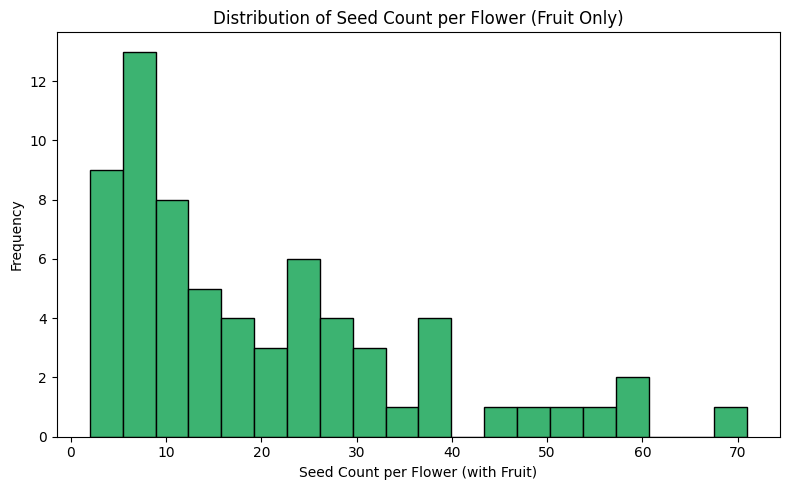

In [105]:
# Plot histogram of seed count per flower, but only for flowers that have fruit (fruit == 1)
plt.figure(figsize=(8, 5))
plt.hist(df_net[df_net['fruit'] == 1]['seed'].dropna(), bins=20, color='mediumseagreen', edgecolor='black')
plt.xlabel('Seed Count per Flower (with Fruit)')
plt.ylabel('Frequency')
plt.title('Distribution of Seed Count per Flower (Fruit Only)')
plt.tight_layout()
plt.show()


### We have a discrete distribution with a variance much bigger than the mean.
 - Therefore we will need to account for the variance with another variable - NB allows that
 - Also we don't have 0 so it will be truncated

In [106]:
df_net[df_net['fruit'] == 1]['seed'].describe()

count    67.000000
mean     19.880597
std      16.074186
min       2.000000
25%       8.000000
50%      15.000000
75%      28.000000
max      71.000000
Name: seed, dtype: float64

Number of nonzero (fruitful) seed counts: 67
Mean (fruit only): 19.881
Variance (fruit only): 258.379
Estimated NB parameters: n=1.657, p=0.077


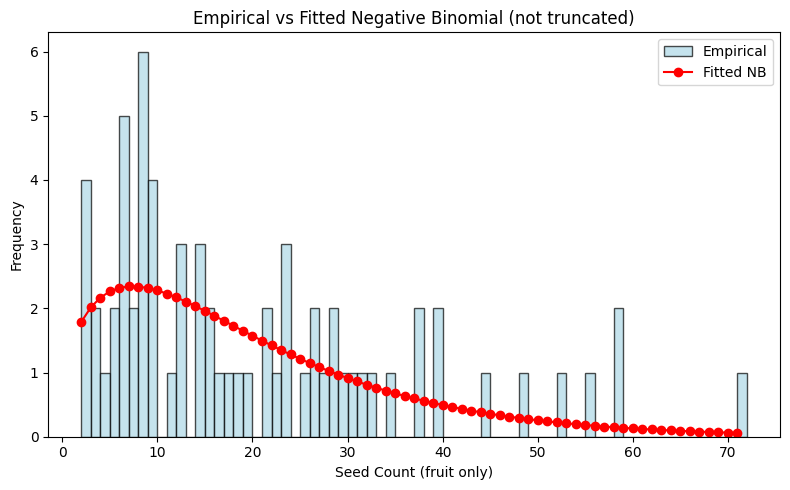

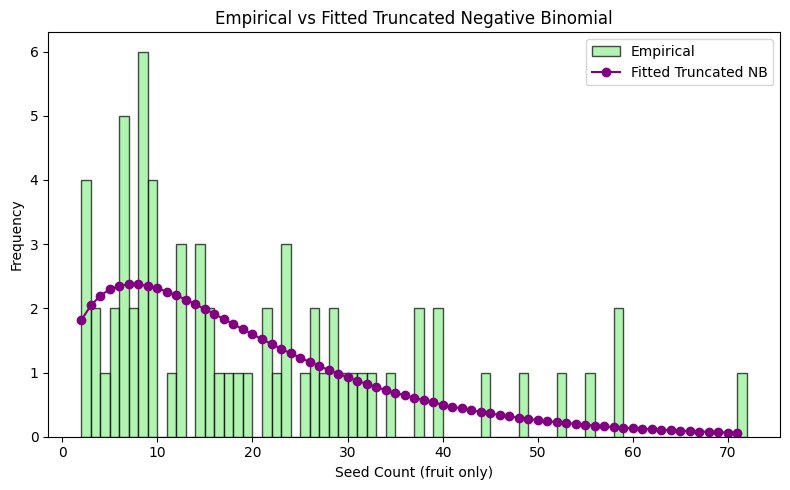

In [107]:
# Check if the distribution is truncated negative binomial

from scipy.stats import nbinom
import numpy as np

# Only consider seed counts for flowers that have fruit (i.e., seed > 0)
seed_fruit = df_net[df_net['fruit'] == 1]['seed'].dropna().astype(int)
print(f"Number of nonzero (fruitful) seed counts: {len(seed_fruit)}")

# Fit a negative binomial to the nonzero data
mean_seed = seed_fruit.mean()
var_seed = seed_fruit.var()
print(f"Mean (fruit only): {mean_seed:.3f}")
print(f"Variance (fruit only): {var_seed:.3f}")

# Estimate NB parameters: p, n
# mean = n * (1-p)/p, var = n * (1-p)/p^2

p_nb = mean_seed / var_seed
n_nb = mean_seed * p_nb / (1 - p_nb)
print(f"Estimated NB parameters: n={n_nb:.3f}, p={p_nb:.3f}")

# Compare empirical and fitted NB (not truncated yet)
counts, bins = np.histogram(seed_fruit, bins=range(seed_fruit.min(), seed_fruit.max()+2))
pmf_nb = nbinom.pmf(bins[:-1], n_nb, p_nb) * len(seed_fruit)

plt.figure(figsize=(8,5))
plt.hist(seed_fruit, bins=range(seed_fruit.min(), seed_fruit.max()+2), color='lightblue', edgecolor='black', alpha=0.7, label='Empirical')
plt.plot(bins[:-1], pmf_nb, 'o-', color='red', label='Fitted NB')
plt.xlabel('Seed Count (fruit only)')
plt.ylabel('Frequency')
plt.title('Empirical vs Fitted Negative Binomial (not truncated)')
plt.legend()
plt.tight_layout()
plt.show()

# Now, check truncated NB: conditional on seed > 0
# For NB, P(X=k | X>0) = P(X=k) / (1 - P(X=0))
pmf_nb_trunc = nbinom.pmf(bins[:-1], n_nb, p_nb) / (1 - nbinom.pmf(0, n_nb, p_nb))
pmf_nb_trunc = pmf_nb_trunc * len(seed_fruit)

plt.figure(figsize=(8,5))
plt.hist(seed_fruit, bins=range(seed_fruit.min(), seed_fruit.max()+2), color='lightgreen', edgecolor='black', alpha=0.7, label='Empirical')
plt.plot(bins[:-1], pmf_nb_trunc, 'o-', color='purple', label='Fitted Truncated NB')
plt.xlabel('Seed Count (fruit only)')
plt.ylabel('Frequency')
plt.title('Empirical vs Fitted Truncated Negative Binomial')
plt.legend()
plt.tight_layout()
plt.show()

In [108]:
# Goodness of fit: compare empirical and expected frequencies
# Use the Kolmogorov-Smirnov test for discrete distributions
from scipy.stats import kstest

# Normalize the fitted truncated NB to a probability mass function
pmf_nb_trunc_prob = pmf_nb_trunc / pmf_nb_trunc.sum()
empirical_counts_prob = counts / counts.sum()

# Compute the cumulative distributions
empirical_cdf = np.cumsum(empirical_counts_prob)
fitted_cdf = np.cumsum(pmf_nb_trunc_prob)

# Use the Kolmogorov-Smirnov statistic manually for discrete data
ks_stat = np.max(np.abs(empirical_cdf - fitted_cdf))
print(f"Kolmogorov-Smirnov statistic (truncated NB): D={ks_stat:.4f}")

# Note: The p-value is not exact for discrete distributions, but can be approximated
# For reporting, we can use the kstest function with the fitted CDF if desired:
def fitted_cdf_func(x):
    # x is a scalar or array
    idx = np.searchsorted(bins[:-1], x, side='right') - 1
    idx = np.clip(idx, 0, len(fitted_cdf)-1)
    return fitted_cdf[idx]

ks_result = kstest(seed_fruit, fitted_cdf_func, alternative='two-sided', mode='asymp')
print(f"Kolmogorov-Smirnov test (truncated NB): D={ks_result.statistic:.4f}, p-value={ks_result.pvalue:.4f}")

Kolmogorov-Smirnov statistic (truncated NB): D=0.1128
Kolmogorov-Smirnov test (truncated NB): D=0.1128, p-value=0.3612


In [109]:
# Chi-squared goodness-of-fit test for the truncated NB fit

from scipy.stats import chisquare

# For chi-squared, expected frequencies should be >= 5 in each bin.
# If not, combine bins at the tails.

# Get observed and expected frequencies for each bin
observed = counts.copy()
expected = pmf_nb_trunc.copy()

# Combine bins with expected < 5 at the tails
def combine_bins(obs, exp, min_exp=5):
    obs = obs.copy()
    exp = exp.copy()
    # Combine from left
    while len(exp) > 1 and exp[0] < min_exp:
        exp[1] += exp[0]
        obs[1] += obs[0]
        exp = exp[1:]
        obs = obs[1:]
    # Combine from right
    while len(exp) > 1 and exp[-1] < min_exp:
        exp[-2] += exp[-1]
        obs[-2] += obs[-1]
        exp = exp[:-1]
        obs = obs[:-1]
    return obs, exp

obs_chi, exp_chi = combine_bins(observed, expected, min_exp=5)

# Ensure the sums of observed and expected match (required for chisquare)
sum_obs = obs_chi.sum()
sum_exp = exp_chi.sum()
if not np.isclose(sum_obs, sum_exp, rtol=1e-8):
    # Scale expected to match observed total
    exp_chi = exp_chi * (sum_obs / sum_exp)

# Perform chi-squared test
chi2_stat, chi2_p = chisquare(f_obs=obs_chi, f_exp=exp_chi)
print(f"Chi-squared test (truncated NB): chi2={chi2_stat:.2f}, df={len(obs_chi)-1}, p-value={chi2_p:.4f}")

Chi-squared test (truncated NB): chi2=35.20, df=40, p-value=0.6861


## Year Differences

In [110]:
df_2023 = pd.read_csv(r'C:\Projects\TAU\Statistics\StatisticsSeminar\IrisProject\Iris\data\2023\Final data for R.csv')
df_2023.head()

,Entry,Entry_species,Species,Population,Date,Days,Day_fl,ID,Flower_No.,Genotype,...,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53
0,1,23,I.atropurpurea,NET,2023-02-26,13,14,3,1,NET_3.1,...,Row Labels,Sum of Seeds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,24,I.atropurpurea,NET,2023-02-26,13,14,10,1,NET_10.1,...,KUR,158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,36,I.atropurpurea,NET,2023-03-05,20,21,10,2,NET_10.2,...,135,0,NaN,NaN,NaN,NaN,NaN,ID2,(All),NaN
3,4,46,I.atropurpurea,NET,2023-03-05,20,21,29,1,NET_29.1,...,136,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,35,I.atropurpurea,NET,2023-02-26,13,14,34,1,NET_34.1,...,139,0,NaN,NaN,NaN,NaN,NaN,Row Labels,Sum of Marked,Average of Multiplied_cm


In [111]:
df_2023['Flower_id'] = df_2023['Genotype'].apply(lambda x: x.split('_')[-1])
# Ensure both flower_id columns are of the same type (string for safety)
df['Flower_id'] = df['Flower_id'].astype(str)
df_2023['Flower_id'] = df_2023['Flower_id'].astype(str)

# Merge on 'Flower_id'
df_merged = pd.merge(df, df_2023, on='Flower_id', suffixes=('_2022', '_2023'))

df_merged.head()


,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,...,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,...,33,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,...,34,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,...,36,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
df

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower Size (cm^2),tunnel_length,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,total_flowers
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0,1
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0,1
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0,3
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0,3
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,295,2024-03-07,30,KUR,RED,K221,221.4,CONTROL,66.8,54.7,1.221207,36.5396,31.8,11.9,7.8,2.951676,7.885,0.0,0.0,6
295,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.913460,5.452,0.0,0.0,2
296,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0,5
297,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,1.164436,31.8507,30.7,13.5,5.8,2.403810,7.456,0.0,0.0,6


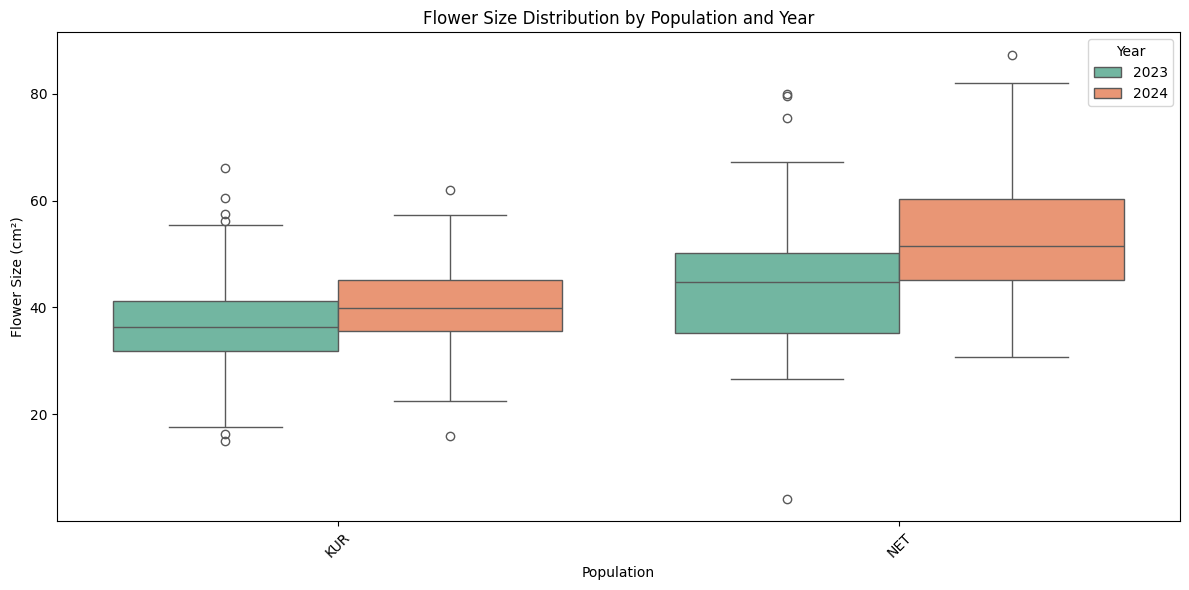

In [114]:
# Get the set of populations present in both years
pop_2023 = set(df_2023['Population'].unique())
pop_2024 = set(df['population'].unique())
common_pops = pop_2023 & pop_2024

# Prepare a long-form DataFrame for boxplotting
df_2023_box = (
    df_2023[df_2023['Population'].isin(common_pops)]
    .loc[:, ['Population', 'Multiplied_cm']]
    .rename(columns={'Population': 'Population', 'Multiplied_cm': 'Flower_Size'})
)
df_2023_box['Year'] = '2023'

df_2024_box = (
    df[df['population'].isin(common_pops)]
    .loc[:, ['population', 'Flower Size (cm^2)']]
    .rename(columns={'population': 'Population', 'Flower Size (cm^2)': 'Flower_Size'})
)
df_2024_box['Year'] = '2024'

# Concatenate for plotting
flower_size_long = pd.concat([df_2023_box, df_2024_box], ignore_index=True)

# Ensure Population is categorical and ordered by appearance in data
pop_order = sorted(list(common_pops))
flower_size_long['Population'] = pd.Categorical(flower_size_long['Population'], categories=pop_order, ordered=True)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=flower_size_long,
    x='Population',
    y='Flower_Size',
    hue='Year',
    palette='Set2'
)
plt.ylabel('Flower Size (cm²)')
plt.xlabel('Population')
plt.title('Flower Size Distribution by Population and Year')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [115]:
print("Testing for differences in flower size between years within each population:")
print("="*60)
results = []

for pop in pop_order:
    data_2023 = flower_size_long[(flower_size_long['Population'] == pop) & (flower_size_long['Year'] == '2023')]['Flower_Size'].dropna()
    data_2024 = flower_size_long[(flower_size_long['Population'] == pop) & (flower_size_long['Year'] == '2024')]['Flower_Size'].dropna()
    # Only test if both years have data for this population
    if len(data_2023) > 0 and len(data_2024) > 0:
        stat, p = mannwhitneyu(data_2023, data_2024, alternative='two-sided')
        print(f"Population: {pop}")
        print(f"  2023 n={len(data_2023)}, median={data_2023.median():.2f}")
        print(f"  2024 n={len(data_2024)}, median={data_2024.median():.2f}")
        print(f"  Mann-Whitney U test: U={stat:.2f}, p-value={p:.4f}")
        print("-"*40)
        results.append({'Population': pop, 'U_stat': stat, 'p_value': p})
    else:
        print(f"Population: {pop} - Not enough data in both years to test.")
        print("-"*40)

# Optionally, collect results in a DataFrame for further inspection
results_df = pd.DataFrame(results)


Testing for differences in flower size between years within each population:
Population: KUR
  2023 n=117, median=36.27
  2024 n=165, median=39.89
  Mann-Whitney U test: U=7242.50, p-value=0.0004
----------------------------------------
Population: NET
  2023 n=52, median=44.75
  2024 n=121, median=51.40
  Mann-Whitney U test: U=1981.00, p-value=0.0001
----------------------------------------


# Modeling

### Functions

In [116]:
import pandas as pd
from rpy2.robjects import default_converter, pandas2ri, r as R
from rpy2.robjects.conversion import localconverter

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

import tempfile, os
from IPython.display import Image, display
from rpy2.robjects.packages import importr

# Import R's base and glmmTMB packages
base = importr('base')
glmmTMB = importr('glmmTMB')

dharma = importr("DHARMa")
grdevices  = importr("grDevices")   # R's graphics devices


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects import default_converter
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import r
from rpy2.robjects.packages import importr

# Import necessary R packages
base = importr('base')
stats = importr('stats')
glmmTMB = importr('glmmTMB')

def extract_varcorr_info(model):
    """Extract variance components from glmmTMB model"""
    try:
        # Get variance components using VarCorr
        varcorr = r['VarCorr'](model)
        
        varcorr_dfs = {}
        
        # Extract conditional model variance components
        if 'cond' in varcorr.names:
            cond_varcorr = varcorr.rx2('cond')
            if cond_varcorr is not None and len(cond_varcorr) > 0:
                varcorr_dfs['cond'] = process_varcorr_component(cond_varcorr)
        
        # Extract zero-inflation model variance components  
        if 'zi' in varcorr.names:
            zi_varcorr = varcorr.rx2('zi')
            if zi_varcorr is not None and len(zi_varcorr) > 0:
                varcorr_dfs['zi'] = process_varcorr_component(zi_varcorr)
                
        # Extract dispersion model variance components
        if 'disp' in varcorr.names:
            disp_varcorr = varcorr.rx2('disp')
            if disp_varcorr is not None and len(disp_varcorr) > 0:
                varcorr_dfs['disp'] = process_varcorr_component(disp_varcorr)
        
        return varcorr_dfs
    except Exception as e:
        print(f"Error extracting variance components: {e}")
        return {}

def process_varcorr_component(varcorr_comp):
    """Process individual variance component"""
    varcorr_list = []
    
    # Get group names
    if hasattr(varcorr_comp, 'names') and varcorr_comp.names is not None:
        group_names = list(varcorr_comp.names)
    else:
        group_names = [f"Group_{i}" for i in range(len(varcorr_comp))]
    
    for i, group_name in enumerate(group_names):
        group_data = varcorr_comp[i]
        
        # Convert to pandas DataFrame
        with localconverter(default_converter + pandas2ri.converter):
            group_df = pandas2ri.rpy2py(group_data)
        
        if isinstance(group_df, pd.DataFrame):
            group_df['Group'] = group_name
            varcorr_list.append(group_df)
        elif isinstance(group_df, (int, float)):
            # Single variance value
            temp_df = pd.DataFrame({
                'Group': [group_name],
                'Variance': [group_df],
                'Std.Dev.': [np.sqrt(group_df)]
            })
            varcorr_list.append(temp_df)
    
    if varcorr_list:
        return pd.concat(varcorr_list, ignore_index=True)
    else:
        return pd.DataFrame()

def extract_ranef_info(model):
    """Extract random effects (BLUPs) from glmmTMB model"""
    try:
        # Get random effects using ranef
        ranef_result = r['ranef'](model)
        
        ranef_dfs = {}
        
        # Extract conditional model random effects
        if 'cond' in ranef_result.names:
            cond_ranef = ranef_result.rx2('cond')
            if cond_ranef is not None and len(cond_ranef) > 0:
                ranef_dfs['cond'] = process_ranef_component(cond_ranef, 'cond')
        
        # Extract zero-inflation model random effects
        if 'zi' in ranef_result.names:
            zi_ranef = ranef_result.rx2('zi')
            if zi_ranef is not None and len(zi_ranef) > 0:
                ranef_dfs['zi'] = process_ranef_component(zi_ranef, 'zi')
                
        # Extract dispersion model random effects
        if 'disp' in ranef_result.names:
            disp_ranef = ranef_result.rx2('disp')
            if disp_ranef is not None and len(disp_ranef) > 0:
                ranef_dfs['disp'] = process_ranef_component(disp_ranef, 'disp')
        
        return ranef_dfs
    except Exception as e:
        print(f"Error extracting random effects: {e}")
        return {}

def process_ranef_component(ranef_comp, component_name):
    """Process individual random effects component"""
    ranef_list = []
    
    # Get group names
    if hasattr(ranef_comp, 'names') and ranef_comp.names is not None:
        group_names = list(ranef_comp.names)
    else:
        group_names = [f"Group_{i}" for i in range(len(ranef_comp))]
    
    for i, group_name in enumerate(group_names):
        group_data = ranef_comp[i]
        
        # Convert to pandas DataFrame
        with localconverter(default_converter + pandas2ri.converter):
            group_df = pandas2ri.rpy2py(group_data)
        
        if isinstance(group_df, pd.DataFrame):
            group_df.reset_index(inplace=True)
            group_df['Group_Variable'] = group_name
            group_df['Component'] = component_name
            ranef_list.append(group_df)
    
    if ranef_list:
        return pd.concat(ranef_list, ignore_index=True)
    else:
        return pd.DataFrame()

def summarize_and_plot_glmmTMB(model):
    """
    Given a fitted glmmTMB model (from rpy2), print and display comprehensive summary 
    including fixed effects, random effects variance components, and random effects values.
    """
    print("=== GLMMTMB MODEL SUMMARY ===\n")
    
    # 1. Standard summary (fixed effects)
    r_summary = base.summary(model)
    print("Standard model summary:")
    print(r_summary)
    print("\n" + "="*60 + "\n")
    
    # 2. Extract fixed effects coefficients
    try:
        cond_df = r_matrix_to_dataframe(r_summary.rx2("coefficients").rx2("cond"))
        zi_df = r_matrix_to_dataframe(r_summary.rx2("coefficients").rx2("zi"))
        
        # Clean up column headers
        if not cond_df.empty:
            cond_df.columns = ["term", "Estimate", "Std_Error", "z_value", "p_value"]
        if not zi_df.empty:
            zi_df.columns = ["term", "Estimate", "Std_Error", "z_value", "p_value"]
            
    except Exception as e:
        print(f"Error extracting fixed effects: {e}")
        cond_df = pd.DataFrame()
        zi_df = pd.DataFrame()
    
    # 3. Extract variance components (VarCorr)
    print("=== VARIANCE COMPONENTS (RANDOM EFFECTS) ===")
    varcorr_info = extract_varcorr_info(model)
    
    if varcorr_info:
        for component, df in varcorr_info.items():
            if not df.empty:
                print(f"\n{component.upper()} model variance components:")
                display(df)
    else:
        print("No random effects variance components found.")
    
    # 4. Extract random effects values (BLUPs)
    print("\n=== RANDOM EFFECTS VALUES (BLUPs) ===")
    ranef_info = extract_ranef_info(model)
    
    if ranef_info:
        for component, df in ranef_info.items():
            if not df.empty:
                print(f"\n{component.upper()} model random effects:")
                display(df.head(10))  # Show first 10 rows
                if len(df) > 10:
                    print(f"... and {len(df) - 10} more rows")
    else:
        print("No random effects values found.")
    
    # 5. Display fixed effects tables
    print("\n" + "="*60)
    print("\n=== FIXED EFFECTS SUMMARY ===")
    
    if not cond_df.empty:
        print("\nFixed effects – COUNT (conditional) part:")
        display(cond_df)
    else:
        print("\nNo conditional fixed effects found.")
    
    if not zi_df.empty:
        print("\nFixed effects – ZERO-INFLATION part:")
        display(zi_df)
    else:
        print("\nNo zero-inflation fixed effects found.")
    
    # 6. Model diagnostics
    print("\n=== MODEL DIAGNOSTICS ===")
    try:
        loglik = r['logLik'](model)[0]
        aic = r['AIC'](model)[0]
        bic = r['BIC'](model)[0]
        
        print(f"Log-likelihood: {loglik:.4f}")
        print(f"AIC: {aic:.4f}")
        print(f"BIC: {bic:.4f}")
    except Exception as e:
        print(f"Error extracting model diagnostics: {e}")
    
    # 7. Coefficient forest plots
    print("\n=== COEFFICIENT PLOTS ===")
    
    def coef_plot(df, title, ax):
        if df.empty:
            ax.text(0.5, 0.5, 'No coefficients to plot', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes)
            ax.set_title(title)
            return
            
        df["lower"] = df["Estimate"] - 1.96 * df["Std_Error"]
        df["upper"] = df["Estimate"] + 1.96 * df["Std_Error"]
        
        # Create the plot
        y_pos = np.arange(len(df))
        ax.scatter(df["Estimate"], y_pos, color="black", s=50, zorder=3)
        ax.hlines(y=y_pos, xmin=df["lower"], xmax=df["upper"], color="gray", linewidth=2)
        ax.axvline(0, ls="--", color="red", alpha=0.7)
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(df["term"])
        ax.set_title(title)
        ax.set_xlabel("Coefficient (log scale)")
        ax.grid(True, alpha=0.3)
    
    # Create subplots based on what we have
    has_cond = not cond_df.empty
    has_zi = not zi_df.empty
    
    if has_cond and has_zi:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, max(6, len(cond_df)*0.5, len(zi_df)*0.5)))
        coef_plot(cond_df, "Count part (conditional)", ax1)
        coef_plot(zi_df, "Zero-inflation part", ax2)
    elif has_cond:
        fig, ax1 = plt.subplots(1, 1, figsize=(8, max(6, len(cond_df)*0.5)))
        coef_plot(cond_df, "Count part (conditional)", ax1)
    elif has_zi:
        fig, ax2 = plt.subplots(1, 1, figsize=(8, max(6, len(zi_df)*0.5)))
        coef_plot(zi_df, "Zero-inflation part", ax2)
    else:
        print("No coefficients available for plotting.")
        return
    
    plt.tight_layout()
    plt.show()
    
    return {
        'fixed_effects': {'cond': cond_df, 'zi': zi_df},
        'variance_components': varcorr_info,
        'random_effects': ranef_info
    }

# Example usage:
# result = summarize_and_plot_glmmTMB(zinb_mixed_model)

In [118]:
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects import default_converter
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import r

# def summarize_and_plot_glmmTMB(model):
#     """
#     Given a fitted glmmTMB model (from rpy2), print and display summary tables and coefficient plots.
#     """
#     r_summary = base.summary(model)

#     cond_df = r_matrix_to_dataframe(r_summary.rx2("coefficients").rx2("cond"))
#     zi_df   = r_matrix_to_dataframe(r_summary.rx2("coefficients").rx2("zi"))

#     # tidy up column headers if you like
#     cond_df.columns = ["term", "Estimate", "Std_Error", "z_value", "p_value"]
#     zi_df.columns   = ["term", "Estimate", "Std_Error", "z_value", "p_value"]

#     print(cond_df.head())
#     print(zi_df.head())

#     # Check if varcor exists and is not NULL
#     varcor = r_summary.rx2("varcor")
#     try:
#         if varcor is not None and str(type(varcor)) != "<class 'rpy2.rinterface.NULLType'>" and type(varcor) != "NULLType":
#             ran_df = r_matrix_to_dataframe(varcor)
#             print("Random effects found")
#             print(ran_df.head())
#         else:
#             print("No random effects found")
#             ran_df = pd.DataFrame()  # empty DataFrame if varcor doesn't exist
#     except:
#         print("No random effects found")
#         ran_df = pd.DataFrame()  # empty DataFrame if varcor doesn't exist

#     print("\nFixed effects – COUNT (negative-binomial) part")
#     display(cond_df)

#     print("\nFixed effects – ZERO-INFLATION part")
#     display(zi_df)

#     print("\nRandom-effect variances")
#     display(ran_df)

#     # -------------------------------------------------------------
#     # 2) Coefficient forest plot (with 95 %-CI) for each component
#     # -------------------------------------------------------------
#     def coef_plot(df, title, ax):
#         df["lower"] = df["Estimate"] - 1.96 * df["Std_Error"]
#         df["upper"] = df["Estimate"] + 1.96 * df["Std_Error"]
#         sns.pointplot(
#             data=df, y="term", x="Estimate", join=False, ax=ax, color="black"
#         )
#         ax.hlines(y=np.arange(len(df)), xmin=df["lower"], xmax=df["upper"], color="gray")
#         ax.axvline(0, ls="--", color="red")
#         ax.set_title(title)
#         ax.set_xlabel("Coefficient (log scale)")

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
#     coef_plot(cond_df, "Count part (conditional)", ax1)
#     coef_plot(zi_df, "Zero-inflation part", ax2)
#     plt.tight_layout()

# Example usage:
# summarize_and_plot_glmmTMB(zinb_mixed_model)


In [119]:
def r_matrix_to_dataframe(r_matrix, rowname_col="term"):
    """
    Parameters
    ----------
    r_matrix : R matrix (e.g. r_summary.rx2("coefficients").rx2("cond"))
    rowname_col : str
        Name for the column that will hold the R row names.
        Pass None if you don’t want row names in the DataFrame.

    Returns
    -------
    pd.DataFrame
    """
    # Grab row/column names from the R object
    colnames = list(R["colnames"](r_matrix))
    rownames = list(R["rownames"](r_matrix))

    # Convert the numeric content to a NumPy array
    with localconverter(default_converter + pandas2ri.converter):
        np_mat = pandas2ri.rpy2py(r_matrix)      # -> numpy.ndarray

    # Build the DataFrame
    df = pd.DataFrame(np_mat, columns=colnames)
    if rowname_col is not None:
        df.insert(0, rowname_col, rownames)      # put row names up front
    return df

In [120]:
def adiagnostics(df_net, zinb_mixed_model):
    """
    Run and display diagnostics for a fitted glmmTMB model.
    
    Parameters:
    - df_net: pandas DataFrame with the data (must include 'seed')
    - zinb_mixed_model: fitted glmmTMB model (R object)
    - sim_res: DHARMa simulated residuals object (R object)
    - dharma: imported DHARMa R package via rpy2
    - grdevices: imported grDevices R package via rpy2
    - tempfile: Python tempfile module
    - Image: IPython.display.Image
    - display: IPython.display.display
    """
    from rpy2.robjects import pandas2ri, default_converter
    from rpy2.robjects.conversion import localconverter
    from rpy2.robjects.packages import importr
    import matplotlib.pyplot as plt

    stats = importr("stats")  # gives you stats::predict()

    # make sure newdata is an R-data.frame
    with localconverter(default_converter + pandas2ri.converter):
        r_df_net = pandas2ri.py2rpy(df_net)

    # get expected counts on the response scale
    pred_r = stats.predict(zinb_mixed_model,
                           newdata=r_df_net,
                           type="response")

    # bring them back to Python
    with localconverter(default_converter + pandas2ri.converter):
        df_net["predicted"] = pandas2ri.rpy2py(pred_r).flatten()

    # Calculate residuals
    residuals = df_net["seed"] - df_net["predicted"]

    # Plot residuals vs predicted
    plt.figure(figsize=(8,5))
    plt.scatter(df_net["predicted"], residuals, alpha=0.7)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted seed count")
    plt.ylabel("Residuals (Observed - Predicted)")
    plt.title("Residuals vs Predicted – Flower level")
    plt.show()

    # Optionally, plot histogram of residuals
    plt.figure(figsize=(8,5))
    plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel("Residuals (Observed - Predicted)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Residuals – Flower level")
    plt.show()

    # DHARMa simulated residuals plot
    tmp = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
    png_path = tmp.name
    tmp.close()  # R will write to this path

    grdevices.png(png_path,
                  width=900,    # pixels
                  height=650,
                  res=120)      # DPI

    

    sim_res = dharma.simulateResiduals(
                fittedModel   = zinb_mixed_model,  # your glmmTMB fit
                integerResponse = True,            # NB / Poisson counts
                plot          = False)             # suppress auto-plot in R

    dharma.plotSimulatedResiduals(sim_res)   # all panels into the device
    grdevices.dev_off()                      # IMPORTANT: flush & close

    # Display inside the notebook
    display(Image(filename=png_path))


In [121]:
# Helper function for your specific use case
def _to_df(r_obj):
    """
    Quick conversion of R object to DataFrame (your existing function)
    """
    return r_matrix_to_dataframe(r_obj)

## Flower Level

### Offset
- Inducing relative seed fitness (seed count / mean seed count by group)

In [151]:
df_net["mean_seed_by_group"] = df_net.groupby(['treatment'])['seed'].transform('mean')
df_net["mean_fruit_by_group"] = df_net.groupby(['treatment'])['fruit'].transform('mean')
# df_net

### ZINB - Degenerate Model - Without Treatment (Compare Loglikelihood)
- Diagnostics
    - Log-likelihood: -344.8755
    - AIC: 711.7510
    - BIC: 742.5047



In [152]:
# Define the model formulas for glmmTMB
# We model both the count and the zero-inflation part with the same predictors
# including interactions and a random intercept for genotype_id.
count_formula = "seed ~ flower_size_std + tunnel_vol_std + bp_area_std + (1|genotype_id) + offset(log(mean_seed_by_group))"
zi_formula = "~ flower_size_std + tunnel_vol_std + bp_area_std + (1|genotype_id) + offset(log(mean_seed_by_group))"

print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_net)} flowers from {df_net['genotype_id'].nunique()} genotypes")
print()

# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_net = ro.conversion.py2rpy(df_net)

# Fit the model
zinb_mixed_model = glmmTMB.glmmTMB(
    formula=ro.Formula(count_formula),
    ziformula=ro.Formula(zi_formula),
    data=r_df_net,
    family=glmmTMB.truncated_nbinom2
)

# Print the model summary
print("MODEL SUMMARY:")
print(base.summary(zinb_mixed_model))


FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...
------------------------------------------------------------
Count Formula: seed ~ flower_size_std + tunnel_vol_std + bp_area_std + (1|genotype_id) + offset(log(mean_seed_by_group))
Zero-Inflation Formula: ~ flower_size_std + tunnel_vol_std + bp_area_std + (1|genotype_id) + offset(log(mean_seed_by_group))
Sample size: 121 flowers from 48 genotypes

MODEL SUMMARY:



=== GLMMTMB MODEL SUMMARY ===

Standard model summary:



=== VARIANCE COMPONENTS (RANDOM EFFECTS) ===
Error extracting variance components: object of type 'NULLType' has no len()
No random effects variance components found.

=== RANDOM EFFECTS VALUES (BLUPs) ===

COND model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-0.041265,genotype_id,cond
1,N007,-0.008375,genotype_id,cond
2,N012,0.067694,genotype_id,cond
3,N016,0.000000,genotype_id,cond
4,N017,-0.033576,genotype_id,cond
5,N041,0.000000,genotype_id,cond
6,N043,0.067086,genotype_id,cond
7,N049,0.000000,genotype_id,cond
8,N050,0.024364,genotype_id,cond
9,N051,0.000000,genotype_id,cond


... and 38 more rows

ZI model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-5.999522e-09,genotype_id,zi
1,N007,-7.994446e-09,genotype_id,zi
2,N012,-1.644114e-08,genotype_id,zi
3,N016,7.677799e-09,genotype_id,zi
4,N017,-8.304840e-09,genotype_id,zi
5,N041,1.523156e-08,genotype_id,zi
6,N043,-1.317267e-08,genotype_id,zi
7,N049,6.797979e-09,genotype_id,zi
8,N050,9.735740e-09,genotype_id,zi
9,N051,1.514054e-08,genotype_id,zi


... and 38 more rows


=== FIXED EFFECTS SUMMARY ===

Fixed effects – COUNT (conditional) part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.551754,0.127036,4.343307,0.000014
1,flower_size_std,-0.000719,0.115354,-0.006233,0.995027
2,tunnel_vol_std,-0.073573,0.149337,-0.492667,0.622248
3,bp_area_std,-0.044457,0.119474,-0.372104,0.709815



Fixed effects – ZERO-INFLATION part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),-2.622155,0.187564,-13.980028,2.064081e-44
1,flower_size_std,-0.325834,0.207399,-1.571048,1.161714e-01
2,tunnel_vol_std,0.402616,0.207173,1.943377,5.197058e-02
3,bp_area_std,-0.158577,0.189810,-0.835453,4.034625e-01



=== MODEL DIAGNOSTICS ===
Log-likelihood: -344.8755
AIC: 711.7510
BIC: 742.5047

=== COEFFICIENT PLOTS ===


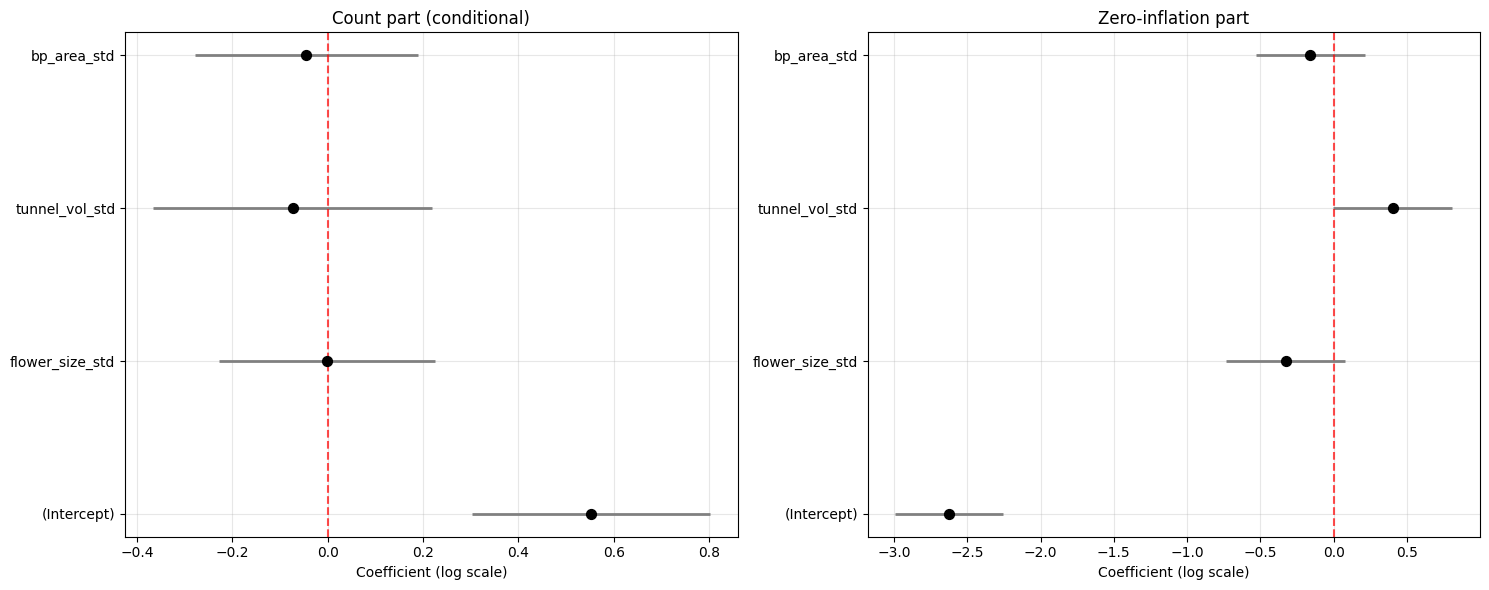

In [153]:
res_dict = summarize_and_plot_glmmTMB(zinb_mixed_model)

### ZINB - Regular Model - treatment interactions - without trait interactions
- Log-likelihood: -338.8004
- AIC: 715.6008
- BIC: 768.7208

In [ ]:
# Define the model formulas for glmmTMB
# We model both the count and the zero-inflation part with the same predictors
# including interactions and a random intercept for genotype_id.
count_formula = "seed ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std ) + (1|genotype_id) + offset(log(mean_seed_by_group))"
zi_formula = "~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std ) + (1|genotype_id) + offset(log(mean_seed_by_group))"

print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_net)} flowers from {df_net['genotype_id'].nunique()} genotypes")
print()

# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_net = ro.conversion.py2rpy(df_net)

# Fit the model
zinb_mixed_model = glmmTMB.glmmTMB(
    formula=ro.Formula(count_formula),
    ziformula=ro.Formula(zi_formula),
    data=r_df_net,
    family=glmmTMB.truncated_nbinom2
)

# Print the model summary
print("MODEL SUMMARY:")
print(base.summary(zinb_mixed_model))


FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...
------------------------------------------------------------
Count Formula: seed ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std ) + (1|genotype_id) + offset(log(mean_seed_by_group))
Zero-Inflation Formula: ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std ) + (1|genotype_id) + offset(log(mean_seed_by_group))
Sample size: 121 flowers from 48 genotypes

MODEL SUMMARY:



=== GLMMTMB MODEL SUMMARY ===

Standard model summary:



=== VARIANCE COMPONENTS (RANDOM EFFECTS) ===
Error extracting variance components: object of type 'NULLType' has no len()
No random effects variance components found.

=== RANDOM EFFECTS VALUES (BLUPs) ===

COND model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-5.979026e-09,genotype_id,cond
1,N007,-2.998504e-09,genotype_id,cond
2,N012,1.434546e-08,genotype_id,cond
3,N016,0.000000e+00,genotype_id,cond
4,N017,-6.221867e-09,genotype_id,cond
5,N041,0.000000e+00,genotype_id,cond
6,N043,1.017750e-08,genotype_id,cond
7,N049,0.000000e+00,genotype_id,cond
8,N050,4.269121e-09,genotype_id,cond
9,N051,0.000000e+00,genotype_id,cond


... and 38 more rows

ZI model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-4.627592e-10,genotype_id,zi
1,N007,-1.011061e-09,genotype_id,zi
2,N012,-8.007505e-10,genotype_id,zi
3,N016,1.032735e-09,genotype_id,zi
4,N017,-4.981534e-10,genotype_id,zi
5,N041,1.358152e-09,genotype_id,zi
6,N043,-1.578967e-09,genotype_id,zi
7,N049,5.230023e-10,genotype_id,zi
8,N050,5.926154e-10,genotype_id,zi
9,N051,1.132901e-09,genotype_id,zi


... and 38 more rows


=== FIXED EFFECTS SUMMARY ===

Fixed effects – COUNT (conditional) part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.698873,0.135809,5.146005,2.660922e-07
1,treatmentTREATMENT,-0.424192,0.208941,-2.030202,4.233603e-02
2,flower_size_std,-0.038560,0.156280,-0.246738,8.051108e-01
3,tunnel_vol_std,0.103176,0.192029,0.537297,5.910625e-01
4,bp_area_std,-0.027828,0.147502,-0.188662,8.503576e-01
5,treatmentTREATMENT:flower_size_std,-0.104481,0.224854,-0.464663,6.421732e-01
6,treatmentTREATMENT:tunnel_vol_std,-0.455062,0.259036,-1.756749,7.896052e-02
7,treatmentTREATMENT:bp_area_std,-0.145410,0.198762,-0.731580,4.644250e-01



Fixed effects – ZERO-INFLATION part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),-2.344001,0.235179,-9.966880,2.128083e-23
1,treatmentTREATMENT,-0.778687,0.406502,-1.915581,5.541846e-02
2,flower_size_std,-0.517618,0.278364,-1.859502,6.295600e-02
3,tunnel_vol_std,0.474488,0.293524,1.616520,1.059820e-01
4,bp_area_std,-0.256982,0.256311,-1.002620,3.160442e-01
5,treatmentTREATMENT:flower_size_std,0.475654,0.446553,1.065168,2.867999e-01
6,treatmentTREATMENT:tunnel_vol_std,-0.081021,0.430639,-0.188141,8.507661e-01
7,treatmentTREATMENT:bp_area_std,0.140462,0.397439,0.353417,7.237756e-01



=== MODEL DIAGNOSTICS ===
Log-likelihood: -338.8004
AIC: 715.6008
BIC: 768.7208

=== COEFFICIENT PLOTS ===


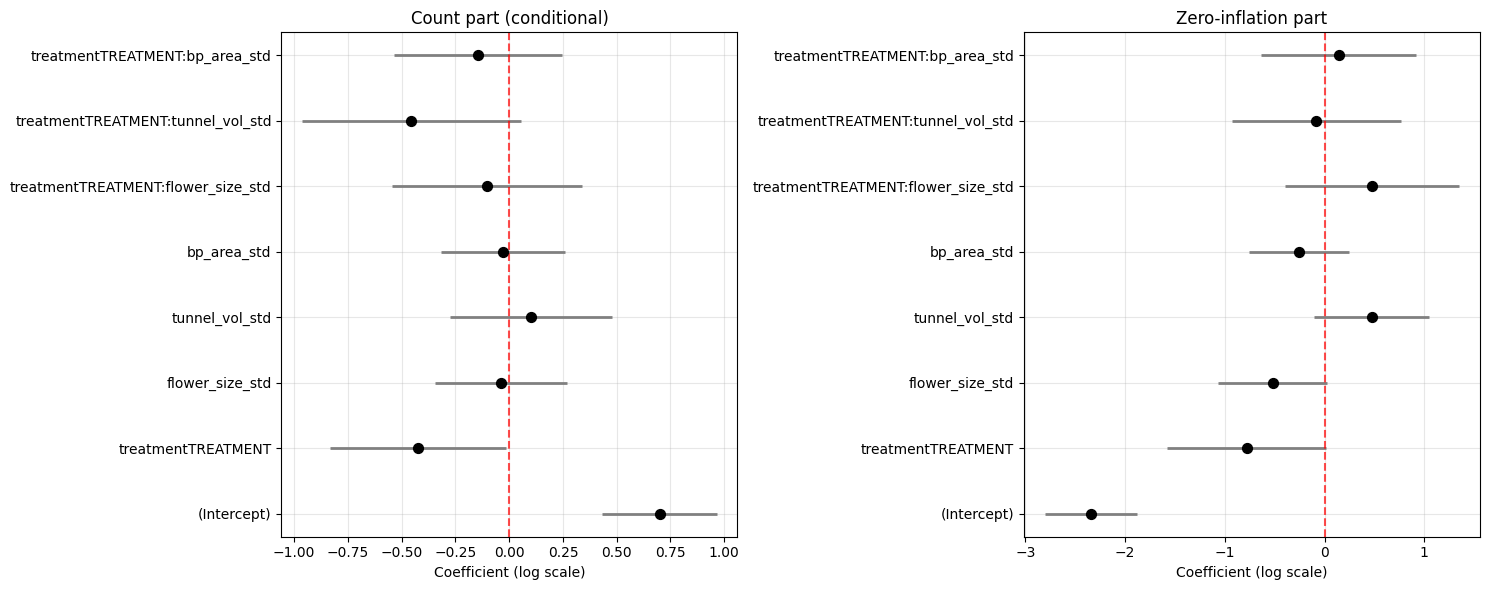

In [ ]:
res_dict = summarize_and_plot_glmmTMB(zinb_mixed_model)

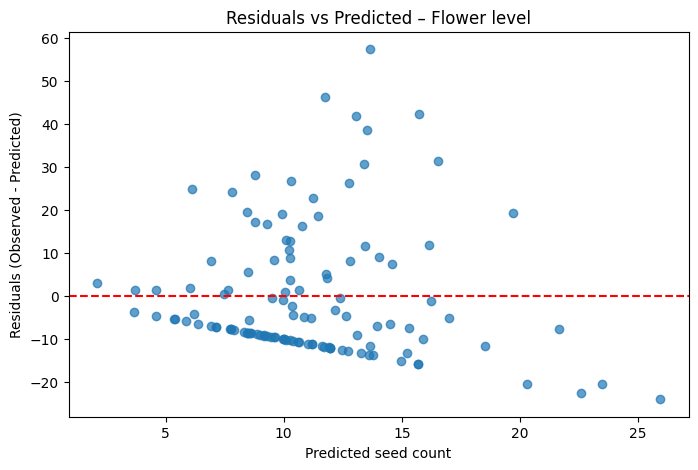

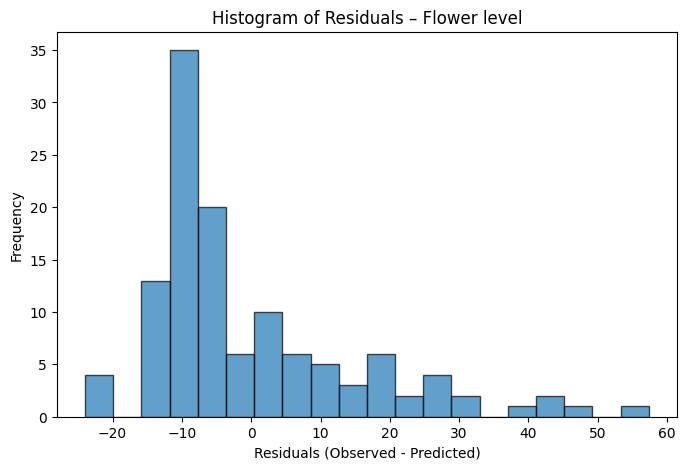

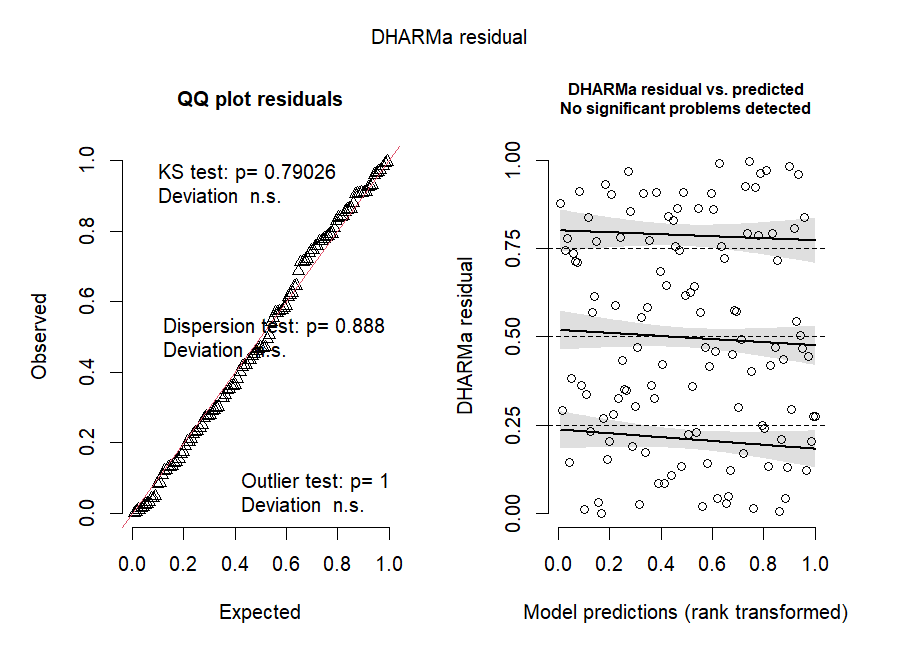

In [ ]:
adiagnostics(df_net, zinb_mixed_model)

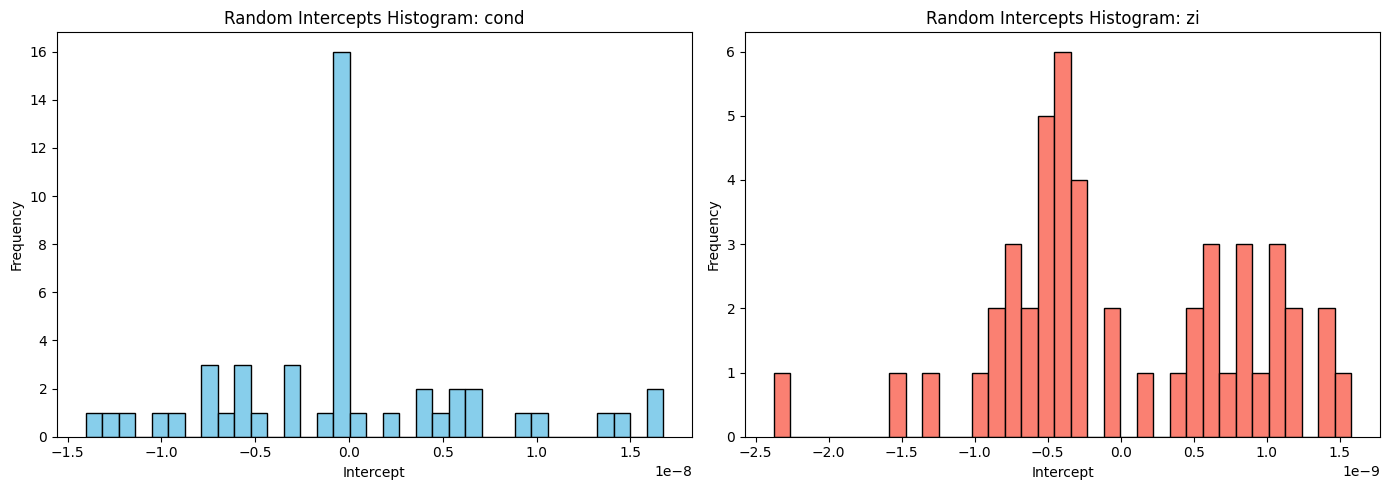

Normality tests for random intercepts:

cond random intercepts:
  Shapiro-Wilk test:      W=0.9530, p=0.0529

zi random intercepts:
  Shapiro-Wilk test:      W=0.9548, p=0.06247


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest, anderson

re_keys = list(res_dict['random_effects'].keys())
df_cond = res_dict['random_effects'][re_keys[0]]
df_zi = res_dict['random_effects'][re_keys[1]]

# Convert to pandas DataFrame if not already
if not isinstance(df_cond, pd.DataFrame):
    df_cond = pd.DataFrame(df_cond)
if not isinstance(df_zi, pd.DataFrame):
    df_zi = pd.DataFrame(df_zi)

# Plot histograms of the (Intercept) column for both random effects
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df_cond['(Intercept)'], bins=35, color='skyblue', edgecolor='black')
axes[0].set_title(f"Random Intercepts Histogram: {re_keys[0]}")
axes[0].set_xlabel("Intercept")
axes[0].set_ylabel("Frequency")

axes[1].hist(df_zi['(Intercept)'], bins=35, color='salmon', edgecolor='black')
axes[1].set_title(f"Random Intercepts Histogram: {re_keys[1]}")
axes[1].set_xlabel("Intercept")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Test for normality of the random intercepts
print("Normality tests for random intercepts:")

for name, df in zip(re_keys, [df_cond, df_zi]):
    intercepts = df['(Intercept)'].dropna()
    print(f"\n{name} random intercepts:")

    # Shapiro-Wilk test
    if len(intercepts) >= 3 and len(intercepts) <= 5000:
        stat, p = shapiro(intercepts)
        print(f"  Shapiro-Wilk test:      W={stat:.4f}, p={p:.4g}")
    else:
        print("  Shapiro-Wilk test:      Not run (sample size out of bounds for test)")

### ZINB - Regular Model - w/ total_flowers - treatment interactions - without trait interactions

- Log-likelihood: -338.6406
- AIC: 719.2812
- BIC: 777.9928

In [ ]:
# Define the model formulas for glmmTMB
# We model both the count and the zero-inflation part with the same predictors
# including interactions and a random intercept for genotype_id.
count_formula = "seed ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std ) + total_flowers_std + (1|genotype_id) + offset(log(mean_seed_by_group))"
zi_formula = "~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std ) + total_flowers_std + (1|genotype_id) + offset(log(mean_seed_by_group))"

print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_net)} flowers from {df_net['genotype_id'].nunique()} genotypes")
print()

# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_net = ro.conversion.py2rpy(df_net)

# Fit the model
zinb_mixed_model = glmmTMB.glmmTMB(
    formula=ro.Formula(count_formula),
    ziformula=ro.Formula(zi_formula),
    data=r_df_net,
    family=glmmTMB.truncated_nbinom2
)

# Print the model summary
print("MODEL SUMMARY:")
print(base.summary(zinb_mixed_model))


FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...
------------------------------------------------------------
Count Formula: seed ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std ) + total_flowers_std + (1|genotype_id) + offset(log(mean_seed_by_group))
Zero-Inflation Formula: ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std ) + total_flowers_std + (1|genotype_id) + offset(log(mean_seed_by_group))
Sample size: 121 flowers from 48 genotypes

MODEL SUMMARY:



=== GLMMTMB MODEL SUMMARY ===

Standard model summary:



=== VARIANCE COMPONENTS (RANDOM EFFECTS) ===
Error extracting variance components: object of type 'NULLType' has no len()
No random effects variance components found.

=== RANDOM EFFECTS VALUES (BLUPs) ===

COND model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-4.070561e-09,genotype_id,cond
1,N007,-1.957185e-09,genotype_id,cond
2,N012,9.696414e-09,genotype_id,cond
3,N016,0.000000e+00,genotype_id,cond
4,N017,-4.233695e-09,genotype_id,cond
5,N041,0.000000e+00,genotype_id,cond
6,N043,7.220446e-09,genotype_id,cond
7,N049,0.000000e+00,genotype_id,cond
8,N050,2.944393e-09,genotype_id,cond
9,N051,0.000000e+00,genotype_id,cond


... and 38 more rows

ZI model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-6.139527e-10,genotype_id,zi
1,N007,-1.318214e-09,genotype_id,zi
2,N012,-9.380977e-10,genotype_id,zi
3,N016,1.243908e-09,genotype_id,zi
4,N017,-6.602536e-10,genotype_id,zi
5,N041,1.599279e-09,genotype_id,zi
6,N043,-2.066014e-09,genotype_id,zi
7,N049,5.930704e-10,genotype_id,zi
8,N050,6.591776e-10,genotype_id,zi
9,N051,1.330615e-09,genotype_id,zi


... and 38 more rows


=== FIXED EFFECTS SUMMARY ===

Fixed effects – COUNT (conditional) part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.696957,0.136669,5.099593,3.403849e-07
1,treatmentTREATMENT,-0.420951,0.210632,-1.998514,4.566097e-02
2,flower_size_std,-0.034796,0.159014,-0.218826,8.267855e-01
3,tunnel_vol_std,0.095795,0.201253,0.475994,6.340789e-01
4,bp_area_std,-0.032931,0.153682,-0.214277,8.303307e-01
5,total_flowers_std,0.013032,0.108072,0.120586,9.040191e-01
6,treatmentTREATMENT:flower_size_std,-0.110427,0.229654,-0.480840,6.306301e-01
7,treatmentTREATMENT:tunnel_vol_std,-0.447785,0.265691,-1.685364,9.191829e-02
8,treatmentTREATMENT:bp_area_std,-0.137883,0.208571,-0.661082,5.085600e-01



Fixed effects – ZERO-INFLATION part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),-2.332927,0.236381,-9.869343,5.653385e-23
1,treatmentTREATMENT,-0.810418,0.411542,-1.969224,4.892738e-02
2,flower_size_std,-0.518419,0.276860,-1.872499,6.113766e-02
3,tunnel_vol_std,0.485071,0.296195,1.637672,1.014901e-01
4,bp_area_std,-0.252324,0.257452,-0.980083,3.270451e-01
5,total_flowers_std,-0.108968,0.197519,-0.551687,5.811630e-01
6,treatmentTREATMENT:flower_size_std,0.504311,0.448177,1.125249,2.604836e-01
7,treatmentTREATMENT:tunnel_vol_std,-0.091686,0.433126,-0.211685,8.323530e-01
8,treatmentTREATMENT:bp_area_std,0.114329,0.401402,0.284823,7.757794e-01



=== MODEL DIAGNOSTICS ===
Log-likelihood: -338.6406
AIC: 719.2812
BIC: 777.9928

=== COEFFICIENT PLOTS ===


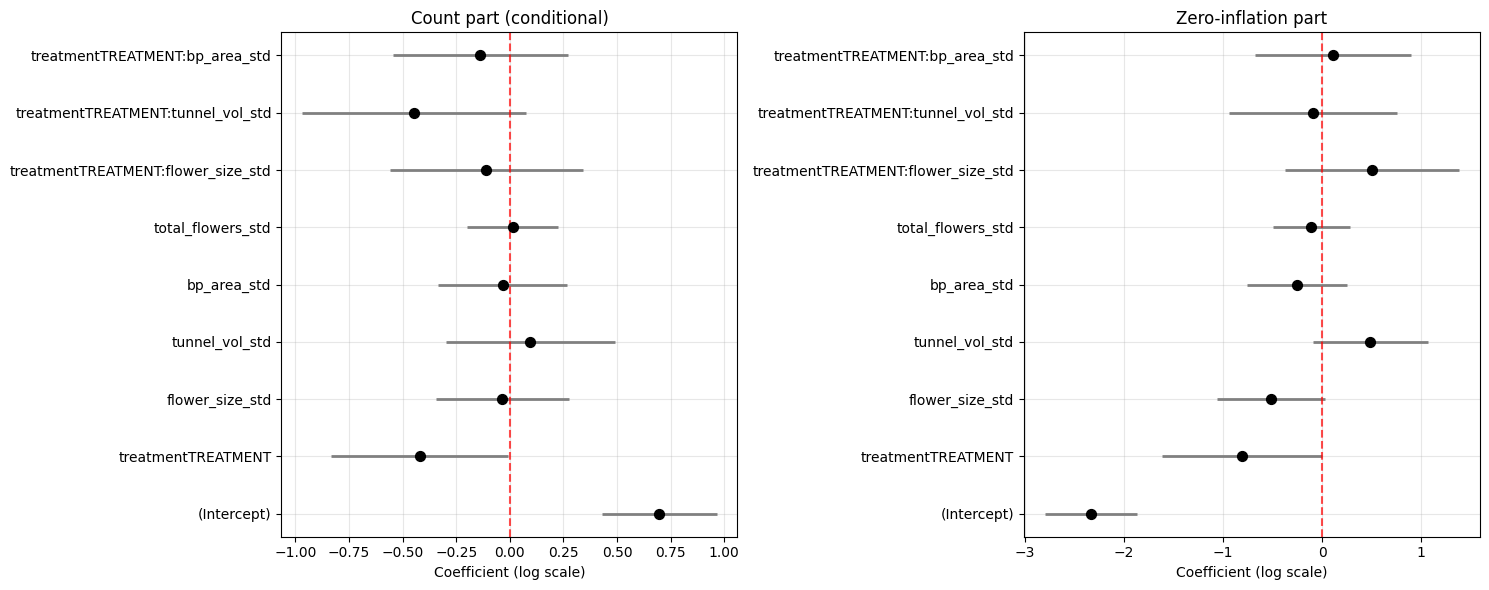

In [ ]:
res_dict = summarize_and_plot_glmmTMB(zinb_mixed_model)

### ZINB - Regular Model - With ALL interactions
- Log-likelihood: -329.7970
- AIC: 721.5940
- BIC: 808.2635


FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...
------------------------------------------------------------
Count Formula: seed ~ treatment * ((flower_size_std + tunnel_vol_std + bp_area_std)^2 + (1|genotype_id)) + offset(log(mean_seed_by_group))
Zero-Inflation Formula: ~ treatment * ( (flower_size_std + tunnel_vol_std + bp_area_std)^2 + (1|genotype_id) ) + offset(log(mean_seed_by_group)) 
Sample size: 121 flowers from 48 genotypes

MODEL SUMMARY:

=== GLMMTMB MODEL SUMMARY ===

Standard model summary:



=== VARIANCE COMPONENTS (RANDOM EFFECTS) ===
Error extracting variance components: 'float' object is not subscriptable
No random effects variance components found.

=== RANDOM EFFECTS VALUES (BLUPs) ===
Error extracting random effects: 'float' object is not subscriptable
No random effects values found.


=== FIXED EFFECTS SUMMARY ===

Fixed effects – COUNT (conditional) part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.495400,0.219687,2.255028,0.024132
1,treatmentTREATMENT,-0.444053,0.292526,-1.517997,0.129015
2,flower_size_std,-0.104585,0.157145,-0.665532,0.505710
3,tunnel_vol_std,0.111129,0.185905,0.597773,0.549992
4,bp_area_std,-0.052527,0.153467,-0.342266,0.732150
5,flower_size_std:tunnel_vol_std,0.300343,0.211413,1.420642,0.155421
6,flower_size_std:bp_area_std,0.254354,0.220317,1.154494,0.248298
7,tunnel_vol_std:bp_area_std,-0.170838,0.249116,-0.685777,0.492854
8,treatmentTREATMENT:flower_size_std,0.022359,0.251584,0.088872,0.929184
9,treatmentTREATMENT:tunnel_vol_std,-0.268312,0.267619,-1.002592,0.316058



Fixed effects – ZERO-INFLATION part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),-2.203424,0.281050,-7.839970,4.506549e-15
1,treatmentTREATMENT,-1.048846,0.513335,-2.043199,4.103274e-02
2,flower_size_std,-0.546491,0.304247,-1.796207,7.246163e-02
3,tunnel_vol_std,0.461410,0.314995,1.464817,1.429710e-01
4,bp_area_std,-0.384658,0.280922,-1.369269,1.709152e-01
5,flower_size_std:tunnel_vol_std,-0.437994,0.320521,-1.366504,1.717809e-01
6,flower_size_std:bp_area_std,-0.339089,0.423245,-0.801165,4.230361e-01
7,tunnel_vol_std:bp_area_std,-0.286513,0.416694,-0.687586,4.917133e-01
8,treatmentTREATMENT:flower_size_std,0.092694,0.561246,0.165157,8.688203e-01
9,treatmentTREATMENT:tunnel_vol_std,0.445311,0.567687,0.784430,4.327879e-01



=== MODEL DIAGNOSTICS ===
Error extracting model diagnostics: 'float' object is not subscriptable

=== COEFFICIENT PLOTS ===


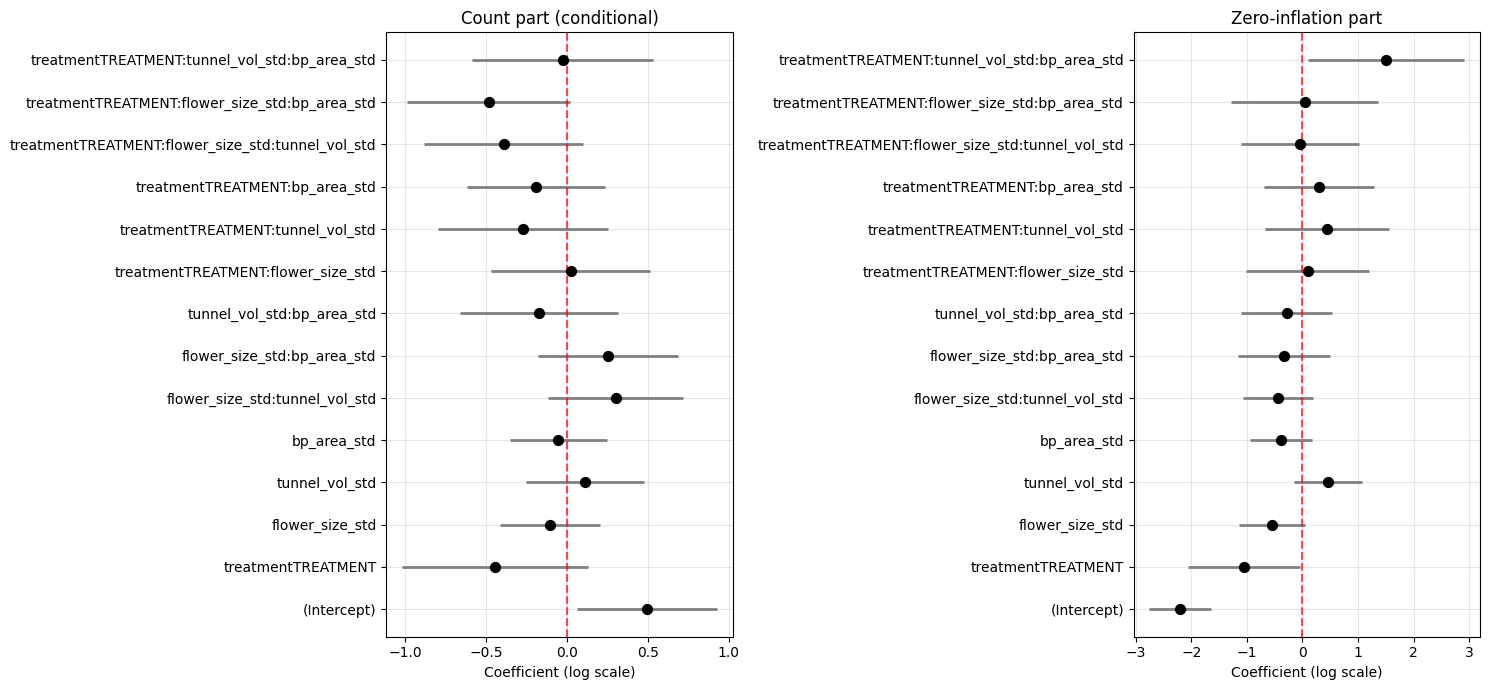

{'fixed_effects': {'cond':                                                  term  Estimate  Std_Error  \
  0                                         (Intercept)  0.495400   0.219687   
  1                                  treatmentTREATMENT -0.444053   0.292526   
  2                                     flower_size_std -0.104585   0.157145   
  3                                      tunnel_vol_std  0.111129   0.185905   
  4                                         bp_area_std -0.052527   0.153467   
  5                      flower_size_std:tunnel_vol_std  0.300343   0.211413   
  6                         flower_size_std:bp_area_std  0.254354   0.220317   
  7                          tunnel_vol_std:bp_area_std -0.170838   0.249116   
  8                  treatmentTREATMENT:flower_size_std  0.022359   0.251584   
  9                   treatmentTREATMENT:tunnel_vol_std -0.268312   0.267619   
  10                     treatmentTREATMENT:bp_area_std -0.189051   0.217099   
  11  treatment

In [ ]:
# Define the model formulas for glmmTMB
# We model both the count and the zero-inflation part with the same predictors
# including interactions and a random intercept for genotype_id.
count_formula = "seed ~ treatment * ((flower_size_std + tunnel_vol_std + bp_area_std)^2 + (1|genotype_id)) + offset(log(mean_seed_by_group))"
zi_formula = "~ treatment * ( (flower_size_std + tunnel_vol_std + bp_area_std)^2 + (1|genotype_id) ) + offset(log(mean_seed_by_group)) "

print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_net)} flowers from {df_net['genotype_id'].nunique()} genotypes")
print()

# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_net = ro.conversion.py2rpy(df_net)

# Fit the model
zinb_mixed_model = glmmTMB.glmmTMB(
    formula=ro.Formula(count_formula),
    ziformula=ro.Formula(zi_formula),
    data=r_df_net,
    family=glmmTMB.truncated_nbinom2
)

# Print the model summary
print("MODEL SUMMARY:")
print(base.summary(zinb_mixed_model))
    

summarize_and_plot_glmmTMB(zinb_mixed_model)

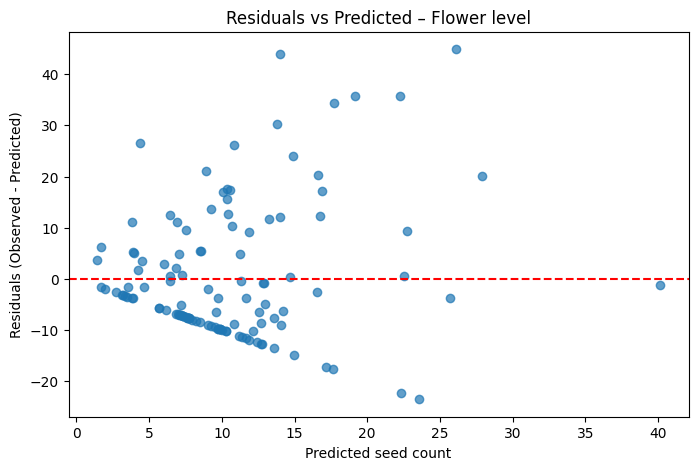

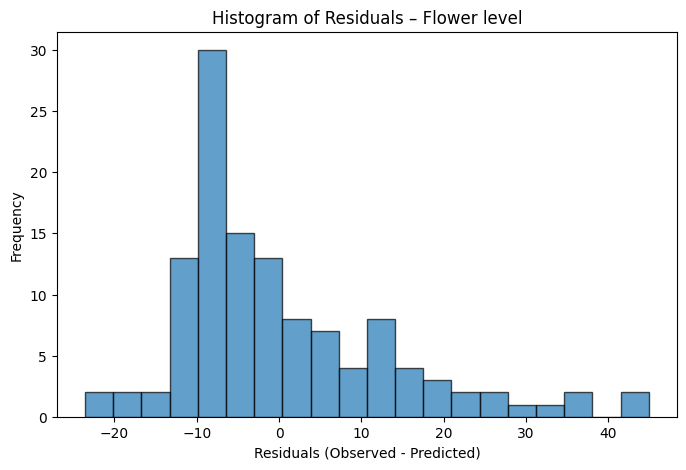

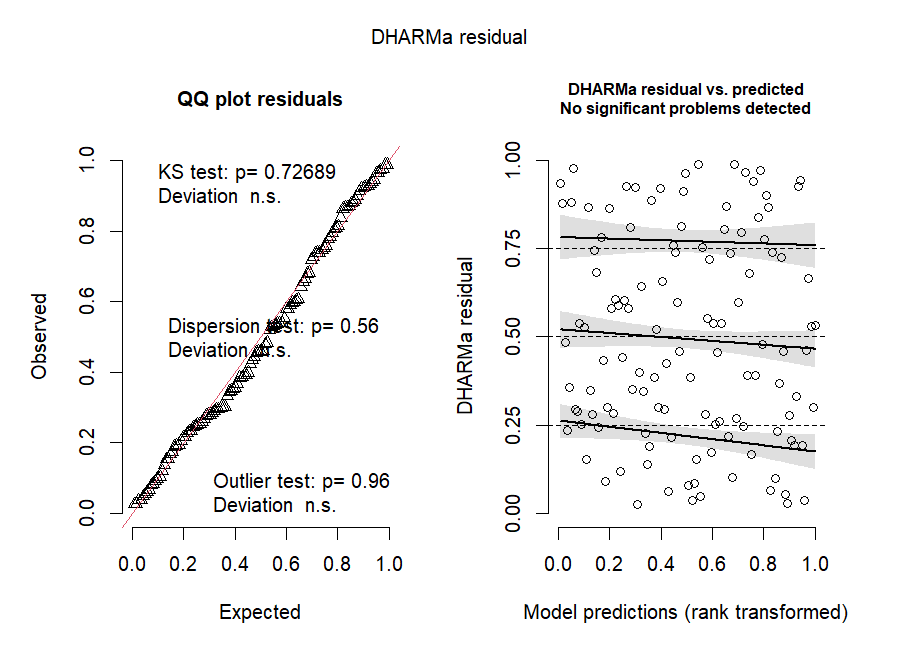

In [ ]:
adiagnostics(df_net, zinb_mixed_model)

### ZINB - With flower_size as categorical variable

- Log-likelihood: -331.1350
- AIC: 708.2700
- BIC: 772.5732

In [ ]:
df_net['flower_size_cat3_q'] = pd.qcut(df_net['flower_size_std'], 
                                      q=3, 
                                      labels=['Small', 'Medium', 'Large'])

# Create dummy variables
df_net['flower_size_medium_q'] = (df_net['flower_size_cat3_q'] == 'Medium').astype(int)
df_net['flower_size_large_q'] = (df_net['flower_size_cat3_q'] == 'Large').astype(int)

print("3-Group SD-Based Distribution (Standardized):")
print(df_net['flower_size_cat3_q'].value_counts())

3-Group SD-Based Distribution (Standardized):
flower_size_cat3_q
Small     41
Large     41
Medium    39
Name: count, dtype: int64


C:\Users\asaf4\AppData\Local\Temp\ipykernel_47472\1749436607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_net['flower_size_cat3_q'] = pd.qcut(df_net['flower_size_std'],
C:\Users\asaf4\AppData\Local\Temp\ipykernel_47472\1749436607.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_net['flower_size_medium_q'] = (df_net['flower_size_cat3_q'] == 'Medium').astype(int)
C:\Users\asaf4\AppData\Local\Temp\ipykernel_47472\1749436607.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [ ]:
# Define the model formulas for glmmTMB with 3-group flower size (quantile-based)
count_formula = "seed ~ treatment * (flower_size_medium_q + flower_size_large_q + tunnel_vol_std + bp_area_std) + (1|genotype_id) + offset(log(mean_seed_by_group))"
zi_formula = "~ treatment * (flower_size_medium_q + flower_size_large_q + tunnel_vol_std + bp_area_std) + (1|genotype_id) + offset(log(mean_seed_by_group))"

print("FITTING ZINB MIXED-EFFECTS MODEL with 3-Group Flower Size (Standardized)...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_net)} flowers from {df_net['genotype_id'].nunique()} genotypes")
print()

# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df_net = ro.conversion.py2rpy(df_net)

# Fit the model
zinb_mixed_model_3grp = glmmTMB.glmmTMB(
    formula=ro.Formula(count_formula),
    ziformula=ro.Formula(zi_formula),
    data=r_df_net,
    family=glmmTMB.truncated_nbinom2
)

# Print the model summary
print("MODEL SUMMARY (3-Group Standardized):")
print(base.summary(zinb_mixed_model_3grp))

FITTING ZINB MIXED-EFFECTS MODEL with 3-Group Flower Size (Standardized)...
------------------------------------------------------------
Count Formula: seed ~ treatment * (flower_size_medium_q + flower_size_large_q + tunnel_vol_std + bp_area_std) + (1|genotype_id) + offset(log(mean_seed_by_group))
Zero-Inflation Formula: ~ treatment * (flower_size_medium_q + flower_size_large_q + tunnel_vol_std + bp_area_std) + (1|genotype_id) + offset(log(mean_seed_by_group))
Sample size: 121 flowers from 48 genotypes

MODEL SUMMARY (3-Group Standardized):



=== GLMMTMB MODEL SUMMARY ===

Standard model summary:



=== VARIANCE COMPONENTS (RANDOM EFFECTS) ===
Error extracting variance components: object of type 'NULLType' has no len()
No random effects variance components found.

=== RANDOM EFFECTS VALUES (BLUPs) ===

COND model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-4.682259e-09,genotype_id,cond
1,N007,-1.733525e-09,genotype_id,cond
2,N012,8.739453e-09,genotype_id,cond
3,N016,0.000000e+00,genotype_id,cond
4,N017,-4.313953e-09,genotype_id,cond
5,N041,0.000000e+00,genotype_id,cond
6,N043,5.216664e-09,genotype_id,cond
7,N049,0.000000e+00,genotype_id,cond
8,N050,3.792257e-09,genotype_id,cond
9,N051,0.000000e+00,genotype_id,cond


... and 38 more rows

ZI model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-7.821373e-10,genotype_id,zi
1,N007,-1.029135e-09,genotype_id,zi
2,N012,-1.186357e-09,genotype_id,zi
3,N016,1.404110e-09,genotype_id,zi
4,N017,-5.949289e-10,genotype_id,zi
5,N041,6.821174e-10,genotype_id,zi
6,N043,-2.469126e-09,genotype_id,zi
7,N049,1.213320e-09,genotype_id,zi
8,N050,1.690018e-09,genotype_id,zi
9,N051,9.248123e-10,genotype_id,zi


... and 38 more rows


=== FIXED EFFECTS SUMMARY ===

Fixed effects – COUNT (conditional) part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.636829,0.232605,2.737807,0.006185
1,treatmentTREATMENT,-0.303863,0.353809,-0.858833,0.390433
2,flower_size_medium_q,0.242564,0.458196,0.529389,0.596535
3,flower_size_large_q,0.062908,0.342888,0.183464,0.854434
4,tunnel_vol_std,0.069138,0.183298,0.377190,0.706032
5,bp_area_std,-0.053133,0.149841,-0.354596,0.722892
6,treatmentTREATMENT:flower_size_medium_q,-0.136524,0.596582,-0.228843,0.818991
7,treatmentTREATMENT:flower_size_large_q,-0.372924,0.509324,-0.732195,0.464049
8,treatmentTREATMENT:tunnel_vol_std,-0.467404,0.253667,-1.842587,0.065389
9,treatmentTREATMENT:bp_area_std,-0.120307,0.200451,-0.600183,0.548384



Fixed effects – ZERO-INFLATION part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),-2.470321,0.440297,-5.610584,2.016451e-08
1,treatmentTREATMENT,-0.801534,0.756465,-1.059578,2.893367e-01
2,flower_size_medium_q,1.925738,0.732534,2.628872,8.566851e-03
3,flower_size_large_q,-0.918283,0.691832,-1.327321,1.844024e-01
4,tunnel_vol_std,0.465200,0.327055,1.422390,1.549131e-01
5,bp_area_std,-0.521286,0.293826,-1.774128,7.604193e-02
6,treatmentTREATMENT:flower_size_medium_q,-1.377685,1.101953,-1.250221,2.112188e-01
7,treatmentTREATMENT:flower_size_large_q,0.608531,1.146481,0.530781,5.955703e-01
8,treatmentTREATMENT:tunnel_vol_std,-0.161891,0.465627,-0.347685,7.280771e-01
9,treatmentTREATMENT:bp_area_std,0.391788,0.425028,0.921794,3.566362e-01



=== MODEL DIAGNOSTICS ===
Log-likelihood: -331.1350
AIC: 708.2700
BIC: 772.5732

=== COEFFICIENT PLOTS ===


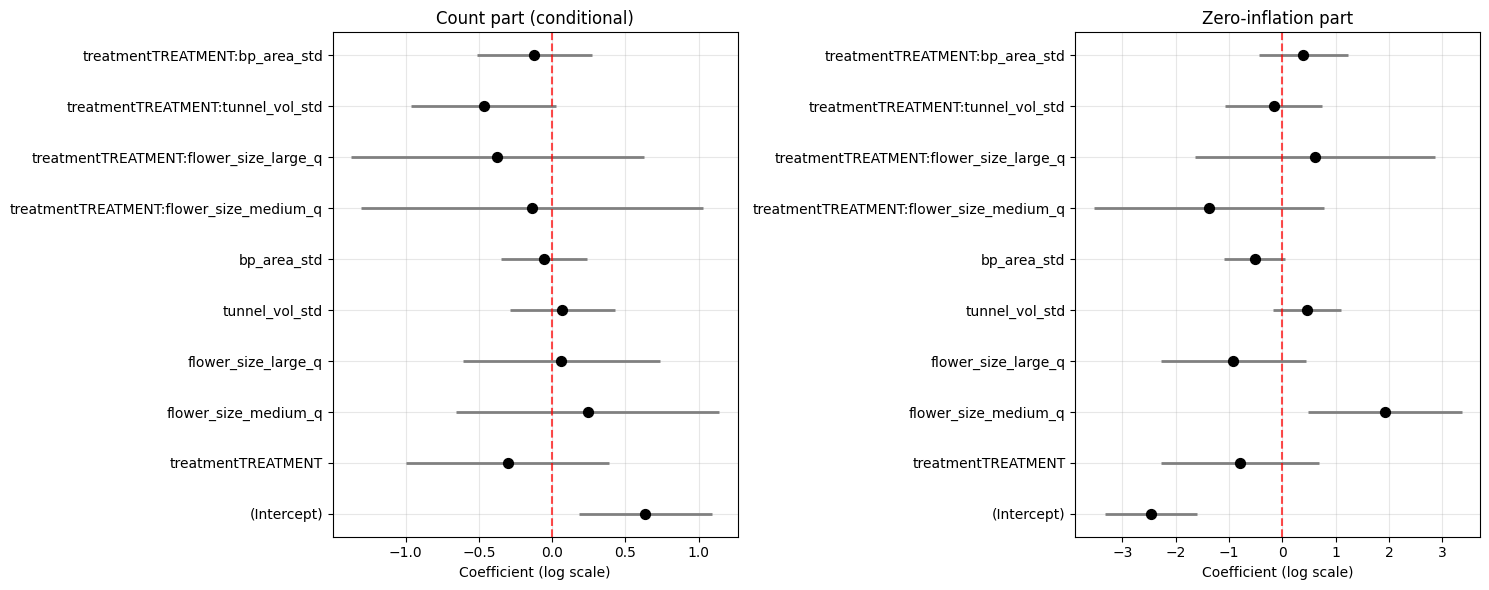

In [ ]:
res_dict = summarize_and_plot_glmmTMB(zinb_mixed_model_3grp)

### ZINB - Kur Regular Model
- Tunnel volume plays a significant role in seed count!


FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...
------------------------------------------------------------
Count Formula: seed ~ flower_size_std + tunnel_vol_std + bp_area_std + (1|genotype_id) 
Zero-Inflation Formula: ~ flower_size_std + tunnel_vol_std + bp_area_std + (1|genotype_id) 
Sample size: 165 flowers from 45 genotypes

MODEL SUMMARY:

=== GLMMTMB MODEL SUMMARY ===

Standard model summary:



=== VARIANCE COMPONENTS (RANDOM EFFECTS) ===
Error extracting variance components: object of type 'NULLType' has no len()
No random effects variance components found.

=== RANDOM EFFECTS VALUES (BLUPs) ===

COND model random effects:


,index,(Intercept),Group_Variable,Component
0,K135,-0.138749,genotype_id,cond
1,K136,0.000000,genotype_id,cond
2,K139,0.099202,genotype_id,cond
3,K140,0.327641,genotype_id,cond
4,K142,0.000000,genotype_id,cond
5,K147,0.087429,genotype_id,cond
6,K155,0.341680,genotype_id,cond
7,K157,0.000000,genotype_id,cond
8,K159,0.022398,genotype_id,cond
9,K168,-0.248113,genotype_id,cond


... and 35 more rows

ZI model random effects:


,index,(Intercept),Group_Variable,Component
0,K135,-0.163747,genotype_id,zi
1,K136,0.237699,genotype_id,zi
2,K139,-0.152612,genotype_id,zi
3,K140,-0.390843,genotype_id,zi
4,K142,0.139281,genotype_id,zi
5,K147,-0.250263,genotype_id,zi
6,K155,-0.156896,genotype_id,zi
7,K157,0.120611,genotype_id,zi
8,K159,-0.116102,genotype_id,zi
9,K168,-0.289756,genotype_id,zi


... and 35 more rows


=== FIXED EFFECTS SUMMARY ===

Fixed effects – COUNT (conditional) part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),2.758652,0.122475,22.524240,2.402447e-112
1,flower_size_std,0.134627,0.098928,1.360851,1.735606e-01
2,tunnel_vol_std,0.350635,0.111376,3.148221,1.642675e-03
3,bp_area_std,-0.002349,0.100377,-0.023399,9.813322e-01



Fixed effects – ZERO-INFLATION part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.191707,0.190128,1.008301,0.313310
1,flower_size_std,-0.172693,0.191872,-0.900044,0.368097
2,tunnel_vol_std,0.054645,0.187972,0.290708,0.771275
3,bp_area_std,0.029659,0.176443,0.168094,0.866510



=== MODEL DIAGNOSTICS ===
Log-likelihood: -390.1135
AIC: 802.2271
BIC: 836.3925

=== COEFFICIENT PLOTS ===


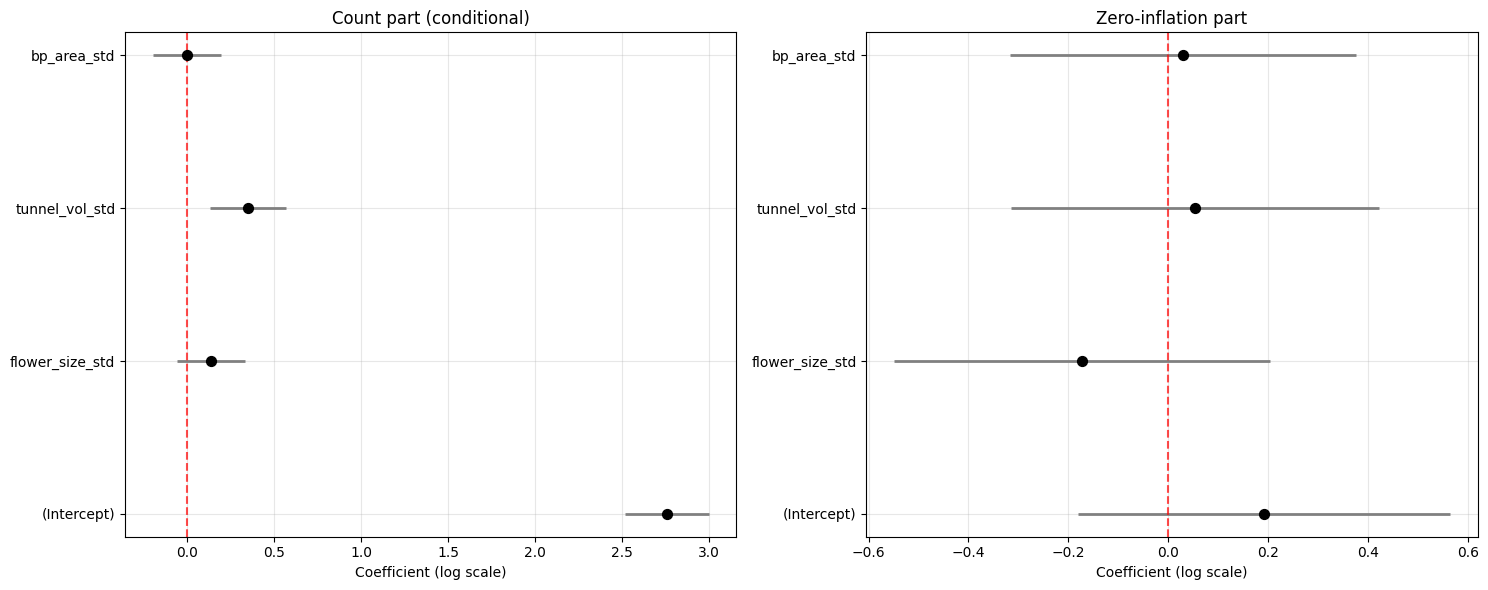

{'fixed_effects': {'cond':               term  Estimate  Std_Error    z_value        p_value     lower  \
  0      (Intercept)  2.758652   0.122475  22.524240  2.402447e-112  2.518602   
  1  flower_size_std  0.134627   0.098928   1.360851   1.735606e-01 -0.059273   
  2   tunnel_vol_std  0.350635   0.111376   3.148221   1.642675e-03  0.132339   
  3      bp_area_std -0.002349   0.100377  -0.023399   9.813322e-01 -0.199087   
  
        upper  
  0  2.998703  
  1  0.328527  
  2  0.568931  
  3  0.194390  ,
  'zi':               term  Estimate  Std_Error   z_value   p_value     lower  \
  0      (Intercept)  0.191707   0.190128  1.008301  0.313310 -0.180945   
  1  flower_size_std -0.172693   0.191872 -0.900044  0.368097 -0.548762   
  2   tunnel_vol_std  0.054645   0.187972  0.290708  0.771275 -0.313780   
  3      bp_area_std  0.029659   0.176443  0.168094  0.866510 -0.316169   
  
        upper  
  0  0.564358  
  1  0.203375  
  2  0.423070  
  3  0.375487  },
 'variance_component

In [154]:
# Define the model formulas for glmmTMB
# We model both the count and the zero-inflation part with the same predictors
# including interactions and a random intercept for genotype_id.
count_formula = "seed ~ flower_size_std + tunnel_vol_std + bp_area_std + (1|genotype_id) "
zi_formula = "~ flower_size_std + tunnel_vol_std + bp_area_std + (1|genotype_id) "

print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_kur)} flowers from {df_kur['genotype_id'].nunique()} genotypes")
print()


# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_kur = ro.conversion.py2rpy(df_kur)

# Fit the model
zinb_mixed_model = glmmTMB.glmmTMB(
    formula=ro.Formula(count_formula),
    ziformula=ro.Formula(zi_formula),
    data=r_df_kur,
    family=glmmTMB.truncated_nbinom2
)

# Print the model summary
print("MODEL SUMMARY:")
print(base.summary(zinb_mixed_model))
    

summarize_and_plot_glmmTMB(zinb_mixed_model)

### ZINB - Kur All interactions Model


In [ ]:
df_kur

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,...,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,total_flowers,flower_size_std,tunnel_vol_std,bp_area_std,predicted
128,132,2024-02-08,2,KUR,BROWN,K211,211.1,CONTROL,74.8,61.2,...,9.7,3.494425,7.462,0.0,0.0,3,0.762696,0.063725,-0.152376,7.333870
129,133,2024-02-08,2,KUR,Yellow,K212,212.1,CONTROL,81.3,64.6,...,9.8,3.432940,7.169,1.0,8.0,3,1.666022,0.007340,-0.332824,11.878440
130,134,2024-02-08,2,KUR,Yellow,K212,212.2,CONTROL,78.2,69.8,...,6.2,2.314088,6.742,1.0,22.0,3,1.942532,-1.018695,-0.595798,8.302767
131,135,2024-02-08,2,KUR,Yellow,K212,212.3,CONTROL,72.9,70.3,...,10.1,4.712155,9.647,0.0,0.0,3,1.495719,1.180436,1.193287,32.033799
132,136,2024-02-08,2,KUR,Yellow,K213,213.1,CONTROL,63.8,54.2,...,9.4,3.722964,5.505,0.0,0.0,2,-0.737623,0.273305,-1.357622,4.753248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,295,2024-03-07,30,KUR,RED,K221,221.4,CONTROL,66.8,54.7,...,7.8,2.951676,7.885,0.0,0.0,6,-0.475020,-0.434000,0.108135,5.368325
295,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,...,8.2,2.913460,5.452,0.0,0.0,2,0.206809,-0.469045,-1.390262,7.458632
296,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,...,9.7,2.368352,8.919,1.0,13.0,5,-3.238203,-0.968933,0.744938,3.717995
297,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,...,5.8,2.403810,7.456,0.0,0.0,6,-1.103243,-0.936416,-0.156071,4.461441


FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...
------------------------------------------------------------
Count Formula: seed ~ (flower_size_std + tunnel_vol_std + bp_area_std)^2 + (1|genotype_id)
Zero-Inflation Formula: ~ (flower_size_std + tunnel_vol_std + bp_area_std)^2 + (1|genotype_id)
Sample size: 165 flowers from 45 genotypes

MODEL SUMMARY:

=== GLMMTMB MODEL SUMMARY ===

Standard model summary:



=== VARIANCE COMPONENTS (RANDOM EFFECTS) ===
Error extracting variance components: object of type 'NULLType' has no len()
No random effects variance components found.

=== RANDOM EFFECTS VALUES (BLUPs) ===

COND model random effects:


,index,(Intercept),Group_Variable,Component
0,K135,-0.035630,genotype_id,cond
1,K136,0.000000,genotype_id,cond
2,K139,0.027428,genotype_id,cond
3,K140,0.139458,genotype_id,cond
4,K142,0.000000,genotype_id,cond
5,K147,0.028299,genotype_id,cond
6,K155,0.107738,genotype_id,cond
7,K157,0.000000,genotype_id,cond
8,K159,0.015215,genotype_id,cond
9,K168,-0.109966,genotype_id,cond


... and 35 more rows

ZI model random effects:


,index,(Intercept),Group_Variable,Component
0,K135,-0.217343,genotype_id,zi
1,K136,0.262378,genotype_id,zi
2,K139,-0.172431,genotype_id,zi
3,K140,-0.462966,genotype_id,zi
4,K142,0.163410,genotype_id,zi
5,K147,-0.264450,genotype_id,zi
6,K155,-0.183099,genotype_id,zi
7,K157,0.132568,genotype_id,zi
8,K159,-0.024953,genotype_id,zi
9,K168,-0.264346,genotype_id,zi


... and 35 more rows


=== FIXED EFFECTS SUMMARY ===

Fixed effects – COUNT (conditional) part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),2.790861,0.113606,24.566224,2.901744e-133
1,flower_size_std,0.144030,0.092783,1.552333,1.205826e-01
2,tunnel_vol_std,0.413693,0.123523,3.349129,8.106605e-04
3,bp_area_std,0.008203,0.108105,0.075880,9.395146e-01
4,flower_size_std:tunnel_vol_std,0.069187,0.088127,0.785086,4.324029e-01
5,flower_size_std:bp_area_std,0.043752,0.096270,0.454467,6.494930e-01
6,tunnel_vol_std:bp_area_std,0.277599,0.161235,1.721705,8.512297e-02



Fixed effects – ZERO-INFLATION part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.237320,0.203388,1.166834,0.243278
1,flower_size_std,-0.213357,0.201805,-1.057246,0.290399
2,tunnel_vol_std,0.058160,0.191882,0.303102,0.761812
3,bp_area_std,-0.033727,0.189495,-0.177983,0.858737
4,flower_size_std:tunnel_vol_std,-0.155585,0.184242,-0.844463,0.398411
5,flower_size_std:bp_area_std,0.262836,0.179017,1.468215,0.142046
6,tunnel_vol_std:bp_area_std,-0.134001,0.199888,-0.670379,0.502616



=== MODEL DIAGNOSTICS ===
Log-likelihood: -386.4615
AIC: 806.9230
BIC: 859.7241

=== COEFFICIENT PLOTS ===


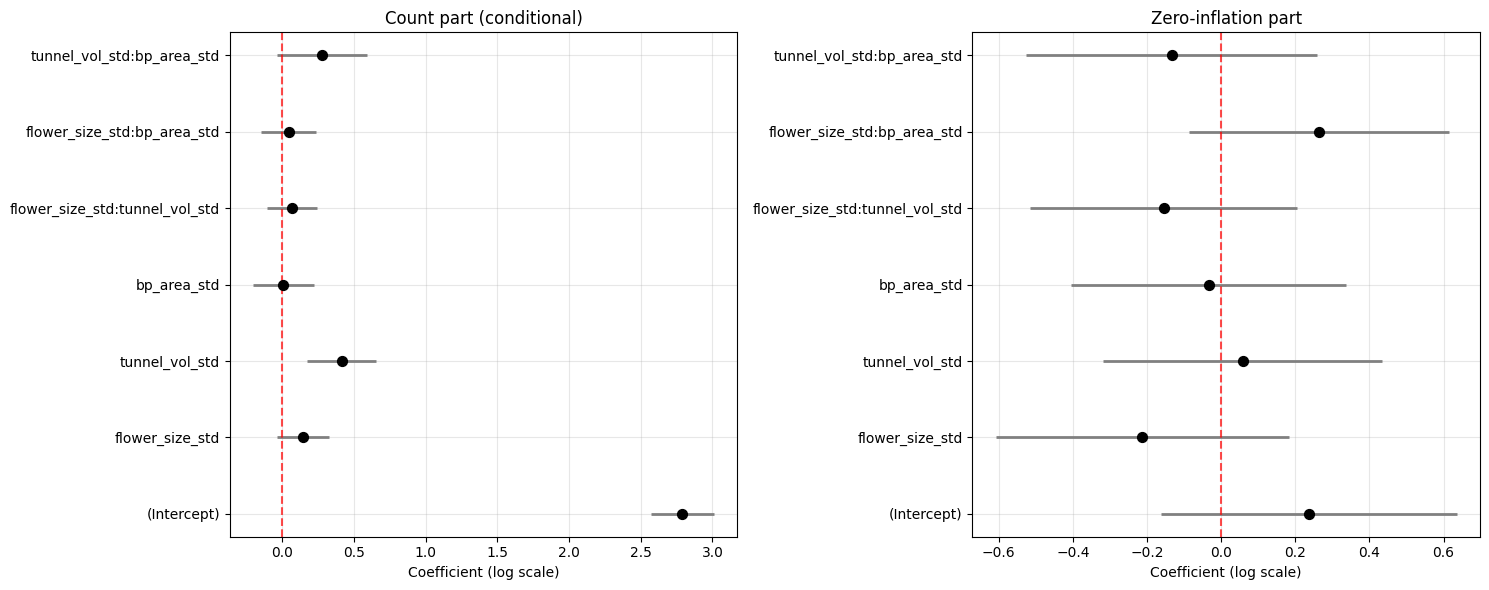

{'fixed_effects': {'cond':                              term  Estimate  Std_Error    z_value  \
  0                     (Intercept)  2.790861   0.113606  24.566224   
  1                 flower_size_std  0.144030   0.092783   1.552333   
  2                  tunnel_vol_std  0.413693   0.123523   3.349129   
  3                     bp_area_std  0.008203   0.108105   0.075880   
  4  flower_size_std:tunnel_vol_std  0.069187   0.088127   0.785086   
  5     flower_size_std:bp_area_std  0.043752   0.096270   0.454467   
  6      tunnel_vol_std:bp_area_std  0.277599   0.161235   1.721705   
  
           p_value     lower     upper  
  0  2.901744e-133  2.568194  3.013528  
  1   1.205826e-01 -0.037825  0.325884  
  2   8.106605e-04  0.171589  0.655797  
  3   9.395146e-01 -0.203682  0.220088  
  4   4.324029e-01 -0.103541  0.241916  
  5   6.494930e-01 -0.144938  0.232441  
  6   8.512297e-02 -0.038421  0.593619  ,
  'zi':                              term  Estimate  Std_Error   z_value   

In [158]:
# Define the model formulas for glmmTMB
# We model both the count and the zero-inflation part with the same predictors
# including interactions and a random intercept for genotype_id.
count_formula = "seed ~ (flower_size_std + tunnel_vol_std + bp_area_std)^2 + (1|genotype_id)"
zi_formula = "~ (flower_size_std + tunnel_vol_std + bp_area_std)^2 + (1|genotype_id)"

print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_kur)} flowers from {df_kur['genotype_id'].nunique()} genotypes")
print()


# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_kur = ro.conversion.py2rpy(df_kur)

# Fit the model
zinb_mixed_model = glmmTMB.glmmTMB(
    formula=ro.Formula(count_formula),
    ziformula=ro.Formula(zi_formula),
    data=r_df_kur,
    family=glmmTMB.truncated_nbinom2
)

# Print the model summary
print("MODEL SUMMARY:")
print(base.summary(zinb_mixed_model))
    

summarize_and_plot_glmmTMB(zinb_mixed_model)

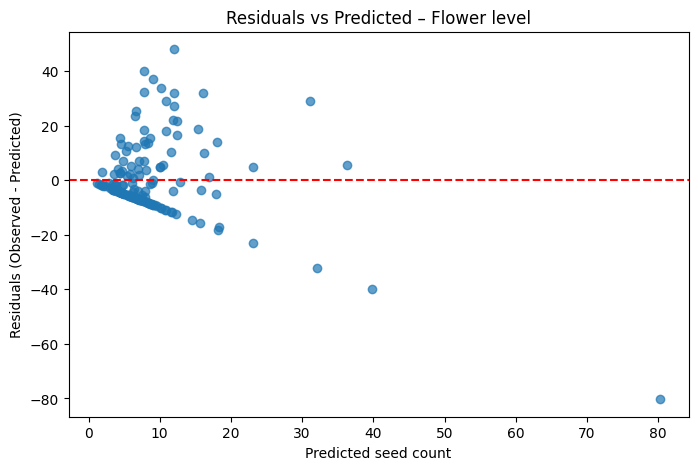

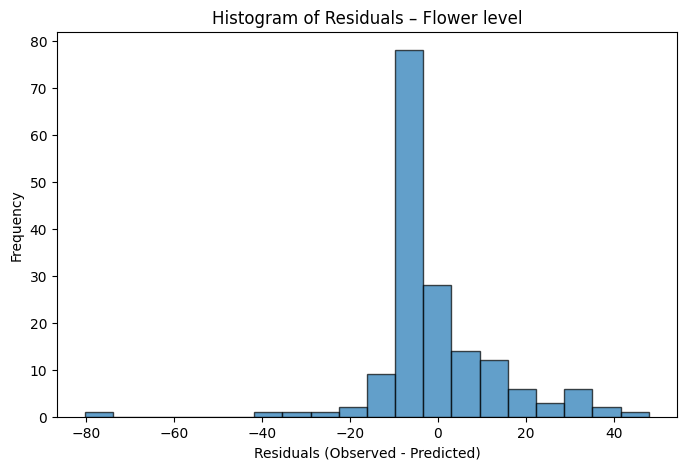

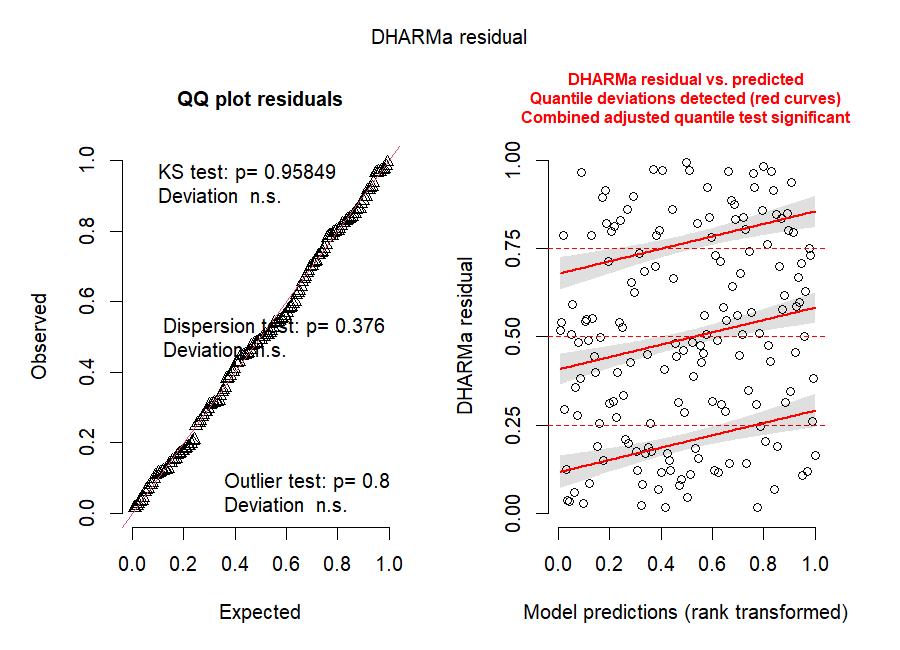

In [ ]:
adiagnostics(df_kur, zinb_mixed_model)

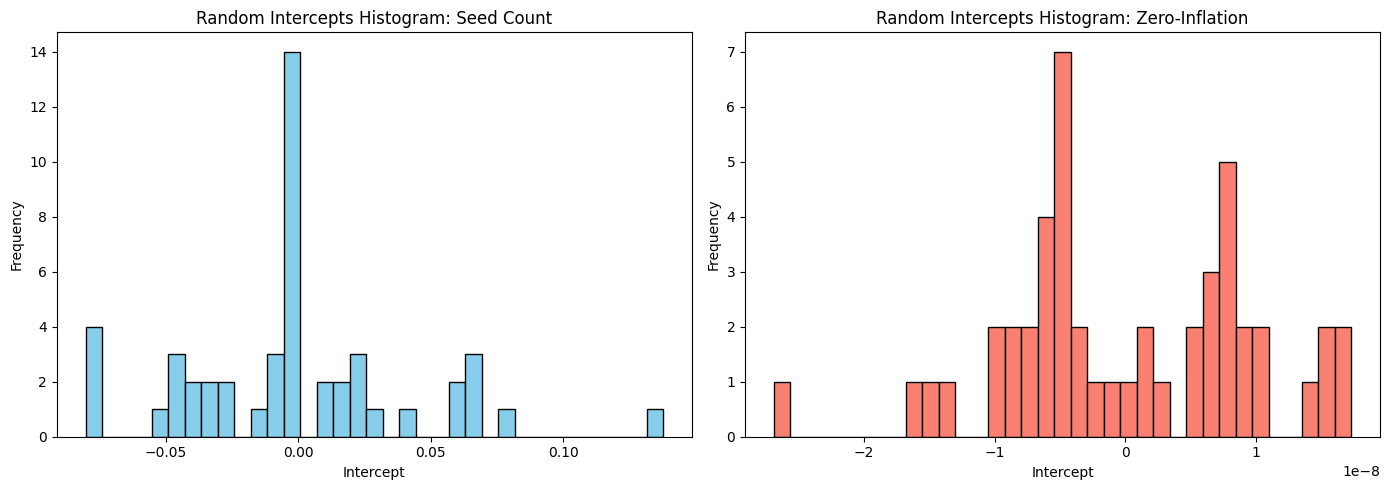

Normality tests for random intercepts:

cond random intercepts:
  Shapiro-Wilk test:      W=0.9477, p=0.03228

zi random intercepts:
  Shapiro-Wilk test:      W=0.9628, p=0.1312


In [160]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest, anderson

re_keys = list(res_dict['random_effects'].keys())
df_cond = res_dict['random_effects'][re_keys[0]]
df_zi = res_dict['random_effects'][re_keys[1]]

# Convert to pandas DataFrame if not already
if not isinstance(df_cond, pd.DataFrame):
    df_cond = pd.DataFrame(df_cond)
if not isinstance(df_zi, pd.DataFrame):
    df_zi = pd.DataFrame(df_zi)

# Plot histograms of the (Intercept) column for both random effects
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df_cond['(Intercept)'], bins=35, color='skyblue', edgecolor='black')
axes[0].set_title(f"Random Intercepts Histogram: Seed Count")
axes[0].set_xlabel("Intercept")
axes[0].set_ylabel("Frequency")

axes[1].hist(df_zi['(Intercept)'], bins=35, color='salmon', edgecolor='black')
axes[1].set_title(f"Random Intercepts Histogram: Zero-Inflation")
axes[1].set_xlabel("Intercept")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Test for normality of the random intercepts
print("Normality tests for random intercepts:")

for name, df in zip(re_keys, [df_cond, df_zi]):
    intercepts = df['(Intercept)'].dropna()
    print(f"\n{name} random intercepts:")

    # Shapiro-Wilk test
    if len(intercepts) >= 3 and len(intercepts) <= 5000:
        stat, p = shapiro(intercepts)
        print(f"  Shapiro-Wilk test:      W={stat:.4f}, p={p:.4g}")
    else:
        print("  Shapiro-Wilk test:      Not run (sample size out of bounds for test)")

## ZINB  - Quadratic

FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...
------------------------------------------------------------
Count Formula: seed ~ (flower_size_std + I(flower_size_std^2) + tunnel_vol_std + I(tunnel_vol_std^2) + bp_area_std + I(bp_area_std^2))^2 + (1|genotype_id)
Zero-Inflation Formula: ~ (flower_size_std + I(flower_size_std^2) + tunnel_vol_std + I(tunnel_vol_std^2) + bp_area_std + I(bp_area_std^2))^2 + (1|genotype_id)
Sample size: 165 flowers from 45 genotypes

MODEL SUMMARY:

=== GLMMTMB MODEL SUMMARY ===

Standard model summary:



=== VARIANCE COMPONENTS (RANDOM EFFECTS) ===
Error extracting variance components: object of type 'NULLType' has no len()
No random effects variance components found.

=== RANDOM EFFECTS VALUES (BLUPs) ===

COND model random effects:


,index,(Intercept),Group_Variable,Component
0,K135,-0.082802,genotype_id,cond
1,K136,0.000000,genotype_id,cond
2,K139,0.028921,genotype_id,cond
3,K140,0.147260,genotype_id,cond
4,K142,0.000000,genotype_id,cond
5,K147,0.079506,genotype_id,cond
6,K155,0.114398,genotype_id,cond
7,K157,0.000000,genotype_id,cond
8,K159,-0.019661,genotype_id,cond
9,K168,-0.127476,genotype_id,cond


... and 35 more rows

ZI model random effects:


,index,(Intercept),Group_Variable,Component
0,K135,-0.305600,genotype_id,zi
1,K136,0.370497,genotype_id,zi
2,K139,-0.206025,genotype_id,zi
3,K140,-0.488627,genotype_id,zi
4,K142,0.134850,genotype_id,zi
5,K147,-0.327761,genotype_id,zi
6,K155,-0.187356,genotype_id,zi
7,K157,0.197213,genotype_id,zi
8,K159,0.060023,genotype_id,zi
9,K168,-0.252736,genotype_id,zi


... and 35 more rows


=== FIXED EFFECTS SUMMARY ===

Fixed effects – COUNT (conditional) part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),2.837773,0.220614,12.863089,7.261579e-38
1,flower_size_std,0.018987,0.239400,0.079310,9.367859e-01
2,I(flower_size_std^2),0.146329,0.185621,0.788323,4.305078e-01
3,tunnel_vol_std,0.541616,0.227439,2.381374,1.724820e-02
4,I(tunnel_vol_std^2),-0.143974,0.199240,-0.722619,4.699142e-01
5,bp_area_std,0.048896,0.271965,0.179787,8.573195e-01
6,I(bp_area_std^2),-0.165536,0.171683,-0.964192,3.349498e-01
7,flower_size_std:I(flower_size_std^2),-0.006704,0.063072,-0.106285,9.153563e-01
8,flower_size_std:tunnel_vol_std,0.094322,0.192327,0.490426,6.238327e-01
9,flower_size_std:I(tunnel_vol_std^2),0.012854,0.176246,0.072933,9.418597e-01



Fixed effects – ZERO-INFLATION part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.193245,0.360623,0.535865,0.592052
1,flower_size_std,0.319809,0.418644,0.763917,0.444916
2,I(flower_size_std^2),0.204510,0.274801,0.744212,0.456748
3,tunnel_vol_std,-0.698186,0.468292,-1.490919,0.135983
4,I(tunnel_vol_std^2),0.176694,0.239411,0.738039,0.460491
5,bp_area_std,-0.061566,0.398485,-0.154499,0.877216
6,I(bp_area_std^2),-0.246515,0.265961,-0.926884,0.353987
7,flower_size_std:I(flower_size_std^2),-0.144876,0.125327,-1.155991,0.247685
8,flower_size_std:tunnel_vol_std,-0.004172,0.334016,-0.012491,0.990034
9,flower_size_std:I(tunnel_vol_std^2),-0.071732,0.264704,-0.270990,0.786399



=== MODEL DIAGNOSTICS ===
Log-likelihood: -373.1545
AIC: 840.3090
BIC: 986.2885

=== COEFFICIENT PLOTS ===


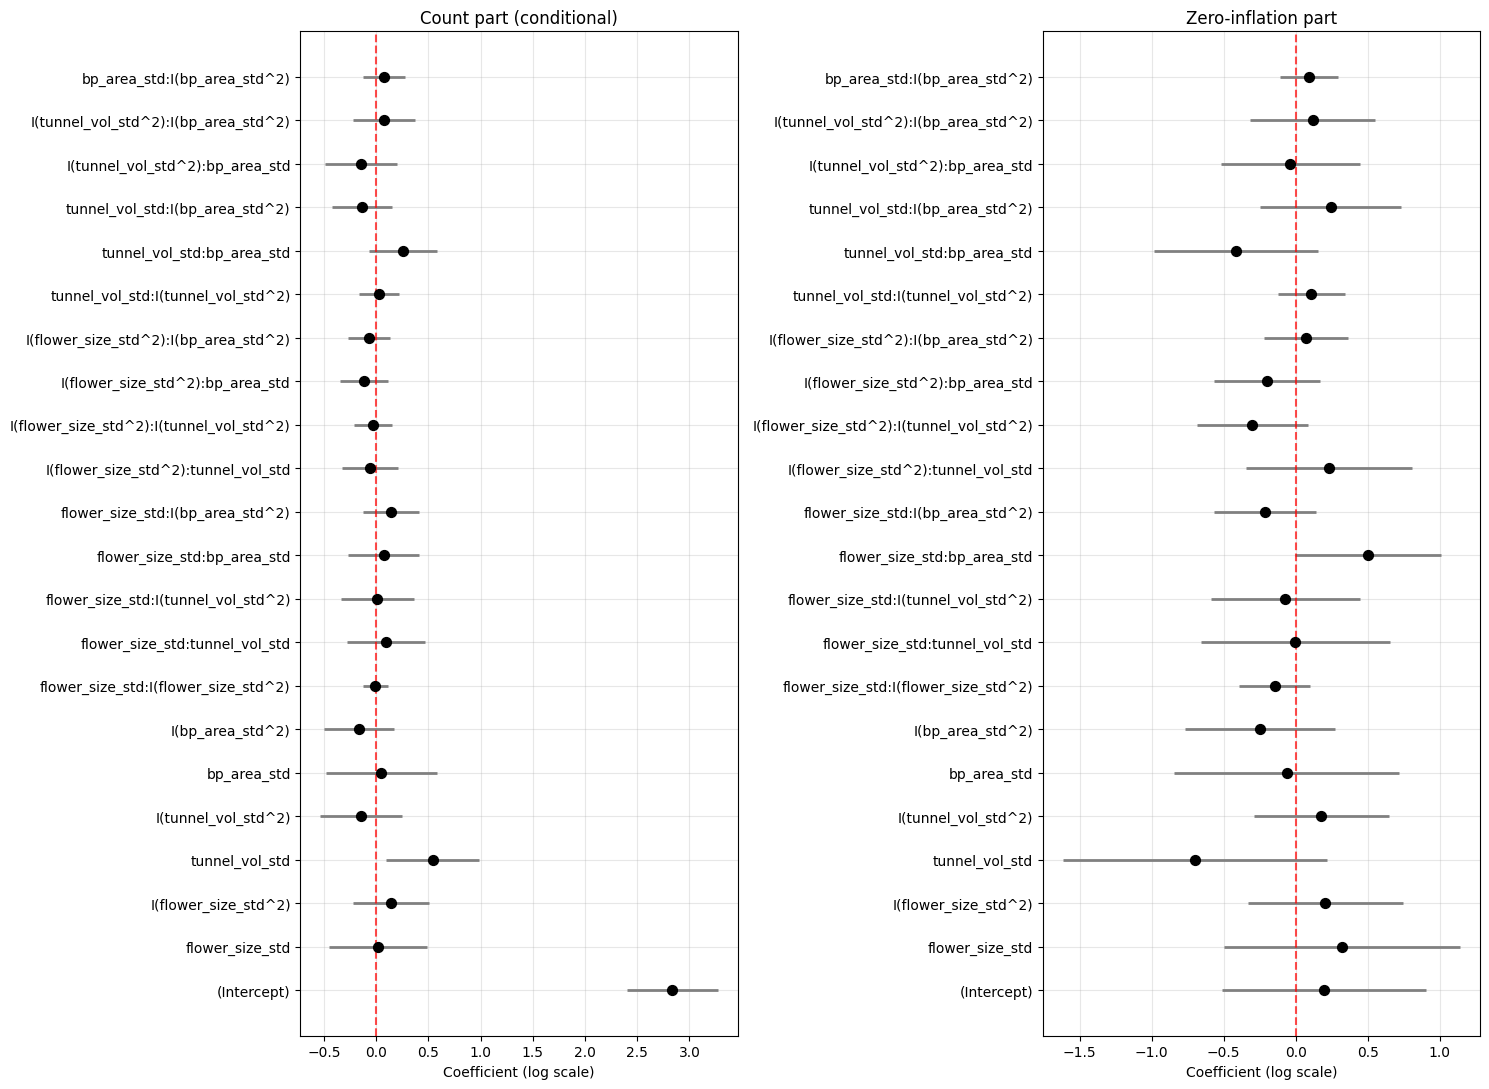

{'fixed_effects': {'cond':                                         term  Estimate  Std_Error    z_value  \
  0                                (Intercept)  2.837773   0.220614  12.863089   
  1                            flower_size_std  0.018987   0.239400   0.079310   
  2                       I(flower_size_std^2)  0.146329   0.185621   0.788323   
  3                             tunnel_vol_std  0.541616   0.227439   2.381374   
  4                        I(tunnel_vol_std^2) -0.143974   0.199240  -0.722619   
  5                                bp_area_std  0.048896   0.271965   0.179787   
  6                           I(bp_area_std^2) -0.165536   0.171683  -0.964192   
  7       flower_size_std:I(flower_size_std^2) -0.006704   0.063072  -0.106285   
  8             flower_size_std:tunnel_vol_std  0.094322   0.192327   0.490426   
  9        flower_size_std:I(tunnel_vol_std^2)  0.012854   0.176246   0.072933   
  10               flower_size_std:bp_area_std  0.070890   0.173283   0.4

In [161]:
# Define the model formulas for glmmTMB
# We model both the count and the zero-inflation part with the same predictors
# including interactions and a random intercept for genotype_id.
count_formula = "seed ~ (flower_size_std + I(flower_size_std^2) + tunnel_vol_std + I(tunnel_vol_std^2) + bp_area_std + I(bp_area_std^2))^2 + (1|genotype_id)"
zi_formula = "~ (flower_size_std + I(flower_size_std^2) + tunnel_vol_std + I(tunnel_vol_std^2) + bp_area_std + I(bp_area_std^2))^2 + (1|genotype_id)"

print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_kur)} flowers from {df_kur['genotype_id'].nunique()} genotypes")
print()


# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_kur = ro.conversion.py2rpy(df_kur)

# Fit the model
zinb_mixed_model = glmmTMB.glmmTMB(
    formula=ro.Formula(count_formula),
    ziformula=ro.Formula(zi_formula),
    data=r_df_kur,
    family=glmmTMB.truncated_nbinom2
)

# Print the model summary
print("MODEL SUMMARY:")
print(base.summary(zinb_mixed_model))
    

summarize_and_plot_glmmTMB(zinb_mixed_model)

# Additional

### ZINB Quadratic

FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...
------------------------------------------------------------
Count Formula: seed ~ treatment * (I(flower_size_std ** 2) + I(tunnel_vol_std ** 2) + I(bp_area_std ** 2)) + (1|genotype_id) + offset(log(mean_seed_by_group))
Zero-Inflation Formula: ~ treatment * (I(flower_size_std ** 2) + I(tunnel_vol_std ** 2) + I(bp_area_std ** 2)) + (1|genotype_id) + offset(log(mean_fruit_by_group))
Sample size: 121 flowers from 48 genotypes

MODEL SUMMARY:

=== GLMMTMB MODEL SUMMARY ===

Standard model summary:



=== VARIANCE COMPONENTS (RANDOM EFFECTS) ===
Error extracting variance components: object of type 'NULLType' has no len()
No random effects variance components found.

=== RANDOM EFFECTS VALUES (BLUPs) ===

COND model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-0.049387,genotype_id,cond
1,N007,-0.019205,genotype_id,cond
2,N012,0.088328,genotype_id,cond
3,N016,0.000000,genotype_id,cond
4,N017,-0.035553,genotype_id,cond
5,N041,0.000000,genotype_id,cond
6,N043,0.050284,genotype_id,cond
7,N049,0.000000,genotype_id,cond
8,N050,0.023847,genotype_id,cond
9,N051,0.000000,genotype_id,cond


... and 38 more rows

ZI model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-3.381233e-09,genotype_id,zi
1,N007,-5.003741e-09,genotype_id,zi
2,N012,-6.117149e-09,genotype_id,zi
3,N016,5.322768e-09,genotype_id,zi
4,N017,-3.400006e-09,genotype_id,zi
5,N041,8.457648e-09,genotype_id,zi
6,N043,-1.088987e-08,genotype_id,zi
7,N049,4.755715e-09,genotype_id,zi
8,N050,3.882153e-09,genotype_id,zi
9,N051,8.149552e-09,genotype_id,zi


... and 38 more rows


=== FIXED EFFECTS SUMMARY ===

Fixed effects – COUNT (conditional) part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.757300,0.267530,2.830714,0.004644
1,treatmentTREATMENT,-0.254759,0.484471,-0.525851,0.598992
2,I(flower_size_std^2),-0.020580,0.048545,-0.423926,0.671620
3,I(tunnel_vol_std^2),0.032802,0.180183,0.182046,0.855546
4,I(bp_area_std^2),-0.085325,0.159192,-0.535985,0.591969
5,treatmentTREATMENT:I(flower_size_std^2),-0.059908,0.105586,-0.567386,0.570452
6,treatmentTREATMENT:I(tunnel_vol_std^2),-0.196142,0.209791,-0.934939,0.349820
7,treatmentTREATMENT:I(bp_area_std^2),0.196722,0.191906,1.025095,0.305318



Fixed effects – ZERO-INFLATION part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.892703,0.353068,2.528419,0.011458
1,treatmentTREATMENT,-0.206452,0.663895,-0.310971,0.755822
2,I(flower_size_std^2),-0.234322,0.132193,-1.772577,0.076299
3,I(tunnel_vol_std^2),0.171080,0.161588,1.058739,0.289719
4,I(bp_area_std^2),-0.042646,0.179287,-0.237864,0.811987
5,treatmentTREATMENT:I(flower_size_std^2),0.010577,0.256083,0.041303,0.967054
6,treatmentTREATMENT:I(tunnel_vol_std^2),-0.262824,0.255660,-1.028022,0.303939
7,treatmentTREATMENT:I(bp_area_std^2),-0.472885,0.388621,-1.216830,0.223669



=== MODEL DIAGNOSTICS ===
Log-likelihood: -337.1747
AIC: 712.3494
BIC: 765.4694

=== COEFFICIENT PLOTS ===


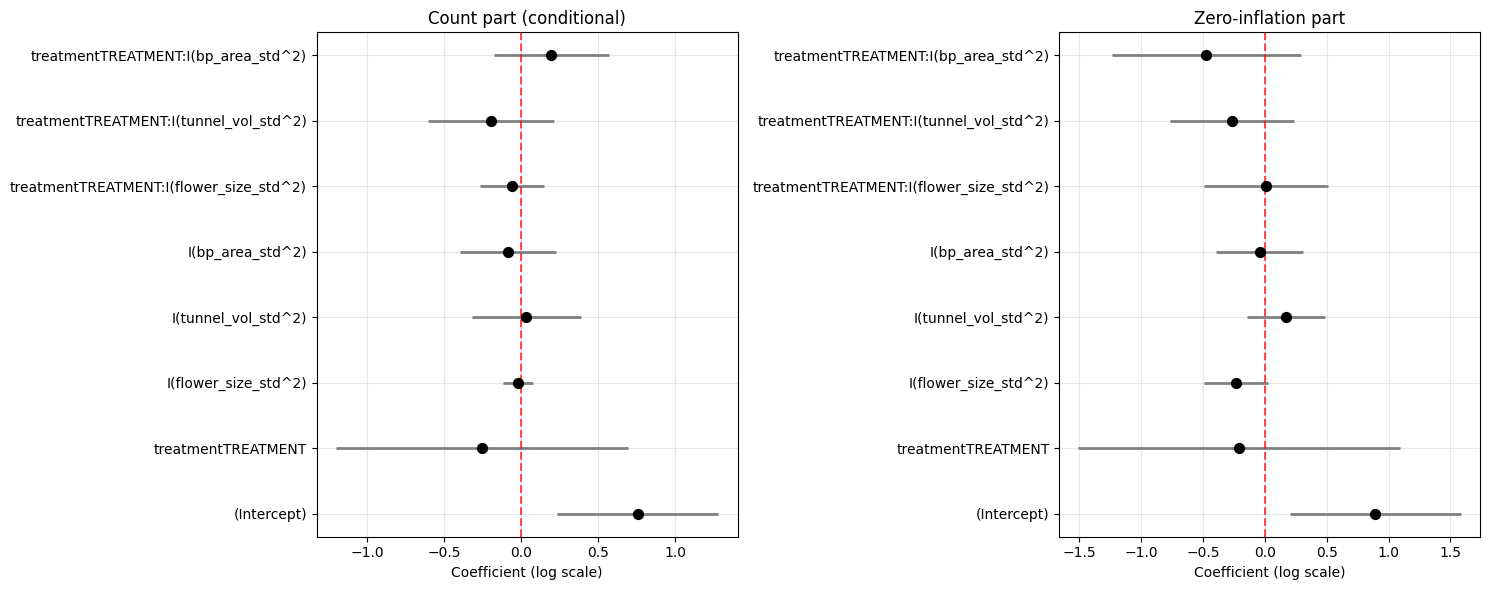

{'fixed_effects': {'cond':                                       term  Estimate  Std_Error   z_value  \
  0                              (Intercept)  0.757300   0.267530  2.830714   
  1                       treatmentTREATMENT -0.254759   0.484471 -0.525851   
  2                     I(flower_size_std^2) -0.020580   0.048545 -0.423926   
  3                      I(tunnel_vol_std^2)  0.032802   0.180183  0.182046   
  4                         I(bp_area_std^2) -0.085325   0.159192 -0.535985   
  5  treatmentTREATMENT:I(flower_size_std^2) -0.059908   0.105586 -0.567386   
  6   treatmentTREATMENT:I(tunnel_vol_std^2) -0.196142   0.209791 -0.934939   
  7      treatmentTREATMENT:I(bp_area_std^2)  0.196722   0.191906  1.025095   
  
      p_value     lower     upper  
  0  0.004644  0.232942  1.281658  
  1  0.598992 -1.204321  0.694803  
  2  0.671620 -0.115728  0.074569  
  3  0.855546 -0.320357  0.385960  
  4  0.591969 -0.397341  0.226692  
  5  0.570452 -0.266857  0.147041  
  6  0.34

In [ ]:

# Define the model formulas for glmmTMB
# We model both the count and the zero-inflation part with the same predictors
# including interactions and a random intercept for genotype_id.
count_formula = "seed ~ treatment * (I(flower_size_std ** 2) + I(tunnel_vol_std ** 2) + I(bp_area_std ** 2)) + (1|genotype_id) + offset(log(mean_seed_by_group))"
zi_formula = "~ treatment * (I(flower_size_std ** 2) + I(tunnel_vol_std ** 2) + I(bp_area_std ** 2)) + (1|genotype_id) + offset(log(mean_fruit_by_group))"

print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_net)} flowers from {df_net['genotype_id'].nunique()} genotypes")
print()

# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_net = ro.conversion.py2rpy(df_net)

# Fit the model
zinb_mixed_model = glmmTMB.glmmTMB(
    formula=ro.Formula(count_formula),
    ziformula=ro.Formula(zi_formula),
    data=r_df_net,
    family=glmmTMB.truncated_nbinom2
)

# Print the model summary
print("MODEL SUMMARY:")
print(base.summary(zinb_mixed_model))
    

summarize_and_plot_glmmTMB(zinb_mixed_model)

In [ ]:
count_formula = "seed ~ treatment * (I(flower_size_std ** 2) + I(tunnel_vol_std ** 2) + I(bp_area_std ** 2)) + (1|genotype_id) + offset(log(mean_seed_by_group))"
zi_formula = "~ treatment * (I(flower_size_std ** 2) + I(tunnel_vol_std ** 2) + I(bp_area_std ** 2)) + (1|genotype_id) + offset(log(mean_fruit_by_group))"

print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_net)} flowers from {df_net['genotype_id'].nunique()} genotypes")
print()

# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_net = ro.conversion.py2rpy(df_net)

# Fit the model
zinb_mixed_model = glmmTMB.glmmTMB(
    formula=ro.Formula(count_formula),
    ziformula=ro.Formula(zi_formula),
    data=r_df_net,
    family=glmmTMB.truncated_nbinom2
)

# Print the model summary
print("MODEL SUMMARY:")
print(base.summary(zinb_mixed_model))
    

summarize_and_plot_glmmTMB(zinb_mixed_model)

### ZINB Quadratic + directional 

FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...
------------------------------------------------------------
Count Formula: seed ~ treatment * (flower_size_std + I(flower_size_std ** 2) + tunnel_vol_std + I(tunnel_vol_std ** 2) + bp_area_std + I(bp_area_std ** 2)) + (1|genotype_id) + offset(log(mean_seed_by_group))
Zero-Inflation Formula: ~ treatment * (flower_size_std + I(flower_size_std ** 2) + tunnel_vol_std + I(tunnel_vol_std ** 2) + bp_area_std + I(bp_area_std ** 2)) + (1|genotype_id) + offset(log(mean_fruit_by_group))
Sample size: 121 flowers from 48 genotypes

MODEL SUMMARY:

=== GLMMTMB MODEL SUMMARY ===

Standard model summary:



=== VARIANCE COMPONENTS (RANDOM EFFECTS) ===
Error extracting variance components: object of type 'NULLType' has no len()
No random effects variance components found.

=== RANDOM EFFECTS VALUES (BLUPs) ===

COND model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-8.334409e-09,genotype_id,cond
1,N007,-3.447715e-09,genotype_id,cond
2,N012,1.092343e-08,genotype_id,cond
3,N016,0.000000e+00,genotype_id,cond
4,N017,-6.634890e-09,genotype_id,cond
5,N041,0.000000e+00,genotype_id,cond
6,N043,8.115892e-09,genotype_id,cond
7,N049,0.000000e+00,genotype_id,cond
8,N050,9.309959e-09,genotype_id,cond
9,N051,0.000000e+00,genotype_id,cond


... and 38 more rows

ZI model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-7.887080e-10,genotype_id,zi
1,N007,-9.292960e-10,genotype_id,zi
2,N012,-6.406446e-10,genotype_id,zi
3,N016,1.169684e-09,genotype_id,zi
4,N017,-6.655185e-11,genotype_id,zi
5,N041,1.279674e-09,genotype_id,zi
6,N043,-1.697634e-09,genotype_id,zi
7,N049,8.307189e-10,genotype_id,zi
8,N050,7.287047e-10,genotype_id,zi
9,N051,1.012886e-09,genotype_id,zi


... and 38 more rows


=== FIXED EFFECTS SUMMARY ===

Fixed effects – COUNT (conditional) part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.768257,0.261867,2.933764,0.003349
1,treatmentTREATMENT,-0.304591,0.390582,-0.779839,0.435485
2,flower_size_std,0.111155,0.228797,0.485823,0.627093
3,I(flower_size_std^2),-0.077784,0.083379,-0.932902,0.350870
4,tunnel_vol_std,0.090209,0.197951,0.455713,0.648596
5,I(tunnel_vol_std^2),0.057383,0.184545,0.310943,0.755844
6,bp_area_std,0.090776,0.216201,0.419872,0.674579
7,I(bp_area_std^2),-0.128705,0.152408,-0.844474,0.398405
8,treatmentTREATMENT:flower_size_std,-0.060734,0.310611,-0.195531,0.844977
9,treatmentTREATMENT:I(flower_size_std^2),-0.039708,0.148593,-0.267226,0.789295



Fixed effects – ZERO-INFLATION part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),1.035988,0.393166,2.634987,0.008414
1,treatmentTREATMENT,-0.168968,0.748619,-0.225706,0.821430
2,flower_size_std,-0.044595,0.417284,-0.106870,0.914892
3,I(flower_size_std^2),-0.298034,0.216514,-1.376509,0.168664
4,tunnel_vol_std,0.425358,0.370445,1.148235,0.250872
5,I(tunnel_vol_std^2),0.016967,0.200935,0.084439,0.932707
6,bp_area_std,-0.358195,0.329573,-1.086844,0.277106
7,I(bp_area_std^2),0.077158,0.220469,0.349972,0.726360
8,treatmentTREATMENT:flower_size_std,1.350781,0.916567,1.473740,0.140552
9,treatmentTREATMENT:I(flower_size_std^2),-0.470052,0.490269,-0.958763,0.337678



=== MODEL DIAGNOSTICS ===
Log-likelihood: -331.2190
AIC: 724.4381
BIC: 811.1076

=== COEFFICIENT PLOTS ===


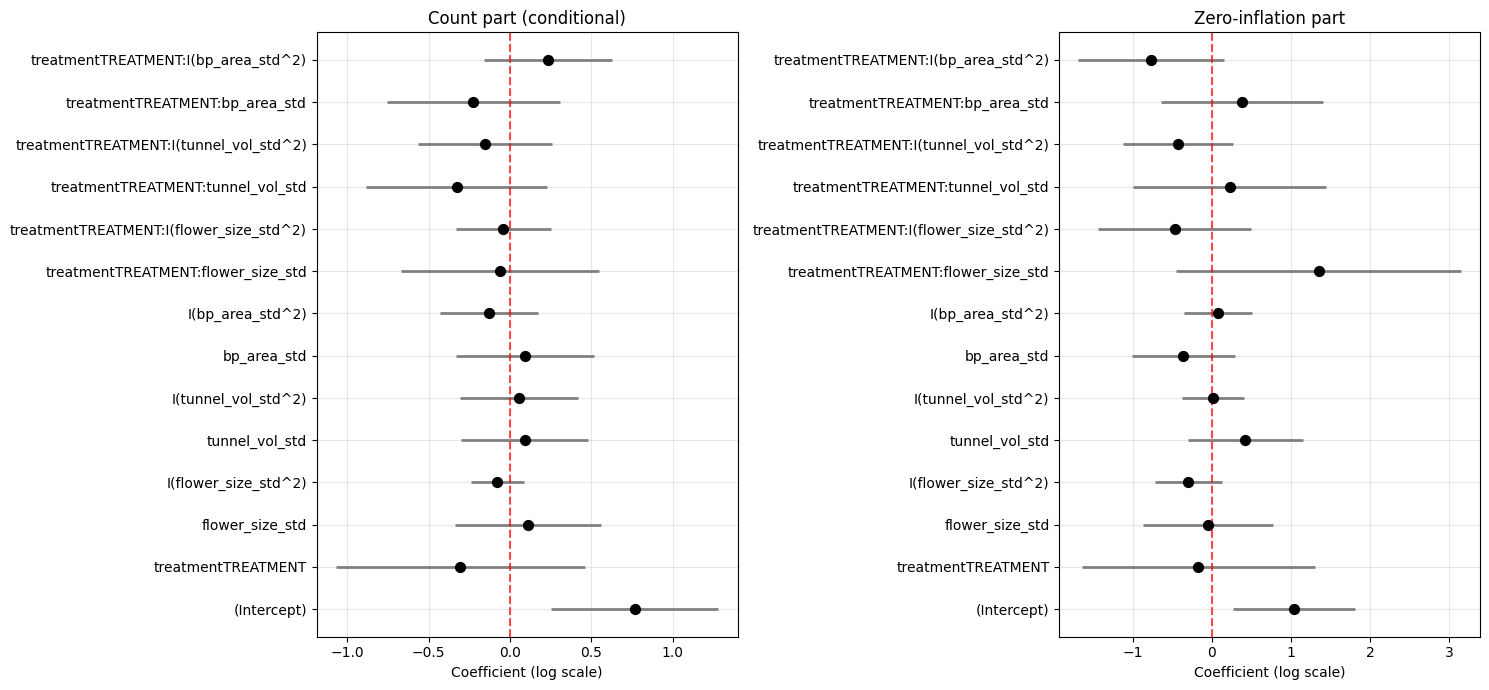

{'fixed_effects': {'cond':                                        term  Estimate  Std_Error   z_value  \
  0                               (Intercept)  0.768257   0.261867  2.933764   
  1                        treatmentTREATMENT -0.304591   0.390582 -0.779839   
  2                           flower_size_std  0.111155   0.228797  0.485823   
  3                      I(flower_size_std^2) -0.077784   0.083379 -0.932902   
  4                            tunnel_vol_std  0.090209   0.197951  0.455713   
  5                       I(tunnel_vol_std^2)  0.057383   0.184545  0.310943   
  6                               bp_area_std  0.090776   0.216201  0.419872   
  7                          I(bp_area_std^2) -0.128705   0.152408 -0.844474   
  8        treatmentTREATMENT:flower_size_std -0.060734   0.310611 -0.195531   
  9   treatmentTREATMENT:I(flower_size_std^2) -0.039708   0.148593 -0.267226   
  10        treatmentTREATMENT:tunnel_vol_std -0.327529   0.284947 -1.149439   
  11   treatmen

In [ ]:

# Define the model formulas for glmmTMB
# We model both the count and the zero-inflation part with the same predictors
# including interactions and a random intercept for genotype_id.
count_formula = "seed ~ treatment * (flower_size_std + I(flower_size_std ** 2) + tunnel_vol_std + I(tunnel_vol_std ** 2) + bp_area_std + I(bp_area_std ** 2)) + (1|genotype_id) + offset(log(mean_seed_by_group))"
zi_formula = "~ treatment * (flower_size_std + I(flower_size_std ** 2) + tunnel_vol_std + I(tunnel_vol_std ** 2) + bp_area_std + I(bp_area_std ** 2)) + (1|genotype_id) + offset(log(mean_fruit_by_group))"

print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_net)} flowers from {df_net['genotype_id'].nunique()} genotypes")
print()

# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_net = ro.conversion.py2rpy(df_net)

# Fit the model
zinb_mixed_model = glmmTMB.glmmTMB(
    formula=ro.Formula(count_formula),
    ziformula=ro.Formula(zi_formula),
    data=r_df_net,
    family=glmmTMB.truncated_nbinom2
)

# Print the model summary
print("MODEL SUMMARY:")
print(base.summary(zinb_mixed_model))
    

summarize_and_plot_glmmTMB(zinb_mixed_model)

In [ ]:
### ZINB directional + interactions

FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...
------------------------------------------------------------
Count Formula: seed ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std + flower_size_std:tunnel_vol_std + flower_size_std:bp_area_std + tunnel_vol_std:bp_area_std + flower_size_std:tunnel_vol_std:bp_area_std) + (1|genotype_id) + offset(log(mean_seed_by_group))
Zero-Inflation Formula: ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std + flower_size_std:tunnel_vol_std + flower_size_std:bp_area_std + tunnel_vol_std:bp_area_std + flower_size_std:tunnel_vol_std:bp_area_std) + (1|genotype_id) + offset(log(mean_fruit_by_group))
Sample size: 121 flowers from 48 genotypes

MODEL SUMMARY:

=== GLMMTMB MODEL SUMMARY ===

Standard model summary:



=== VARIANCE COMPONENTS (RANDOM EFFECTS) ===
Error extracting variance components: object of type 'NULLType' has no len()
No random effects variance components found.

=== RANDOM EFFECTS VALUES (BLUPs) ===

COND model 

,index,(Intercept),Group_Variable,Component
0,N006,-0.311306,genotype_id,cond
1,N007,-0.082073,genotype_id,cond
2,N012,0.498680,genotype_id,cond
3,N016,0.000000,genotype_id,cond
4,N017,-0.152031,genotype_id,cond
5,N041,0.000000,genotype_id,cond
6,N043,0.550023,genotype_id,cond
7,N049,0.000000,genotype_id,cond
8,N050,-0.004199,genotype_id,cond
9,N051,0.000000,genotype_id,cond


... and 38 more rows

ZI model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-1.713977e-09,genotype_id,zi
1,N007,-3.245627e-09,genotype_id,zi
2,N012,-1.643125e-09,genotype_id,zi
3,N016,2.089044e-09,genotype_id,zi
4,N017,-1.609653e-09,genotype_id,zi
5,N041,3.597334e-09,genotype_id,zi
6,N043,-4.523601e-09,genotype_id,zi
7,N049,1.456640e-09,genotype_id,zi
8,N050,1.773121e-09,genotype_id,zi
9,N051,2.560321e-09,genotype_id,zi


... and 38 more rows


=== FIXED EFFECTS SUMMARY ===

Fixed effects – COUNT (conditional) part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.605662,0.220222,2.750233,0.005955
1,treatmentTREATMENT,-0.539277,0.347761,-1.550712,0.120971
2,flower_size_std,-0.169644,0.170791,-0.993286,0.320571
3,tunnel_vol_std,-0.095623,0.206731,-0.462550,0.643687
4,bp_area_std,-0.290080,0.213982,-1.355626,0.175218
5,flower_size_std:tunnel_vol_std,0.307102,0.180296,1.703320,0.088508
6,flower_size_std:bp_area_std,0.266703,0.224351,1.188778,0.234527
7,tunnel_vol_std:bp_area_std,-0.368424,0.277030,-1.329904,0.183550
8,treatmentTREATMENT:flower_size_std,0.127146,0.244667,0.519671,0.603293
9,treatmentTREATMENT:tunnel_vol_std,-0.001408,0.314341,-0.004480,0.996425



Fixed effects – ZERO-INFLATION part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),1.088672,0.324070,3.359375,0.000781
1,treatmentTREATMENT,-1.490630,0.683199,-2.181837,0.029122
2,flower_size_std,-0.414182,0.307133,-1.348544,0.177484
3,tunnel_vol_std,0.766045,0.388255,1.973049,0.048490
4,bp_area_std,-0.268749,0.415952,-0.646107,0.518210
5,flower_size_std:tunnel_vol_std,-0.389962,0.303317,-1.285657,0.198563
6,flower_size_std:bp_area_std,-0.298993,0.443721,-0.673831,0.500419
7,tunnel_vol_std:bp_area_std,-0.602073,0.611815,-0.984076,0.325078
8,treatmentTREATMENT:flower_size_std,0.312307,0.598546,0.521776,0.601826
9,treatmentTREATMENT:tunnel_vol_std,0.521008,0.831249,0.626778,0.530805



=== MODEL DIAGNOSTICS ===
Log-likelihood: -328.3494
AIC: 726.6988
BIC: 824.5515

=== COEFFICIENT PLOTS ===


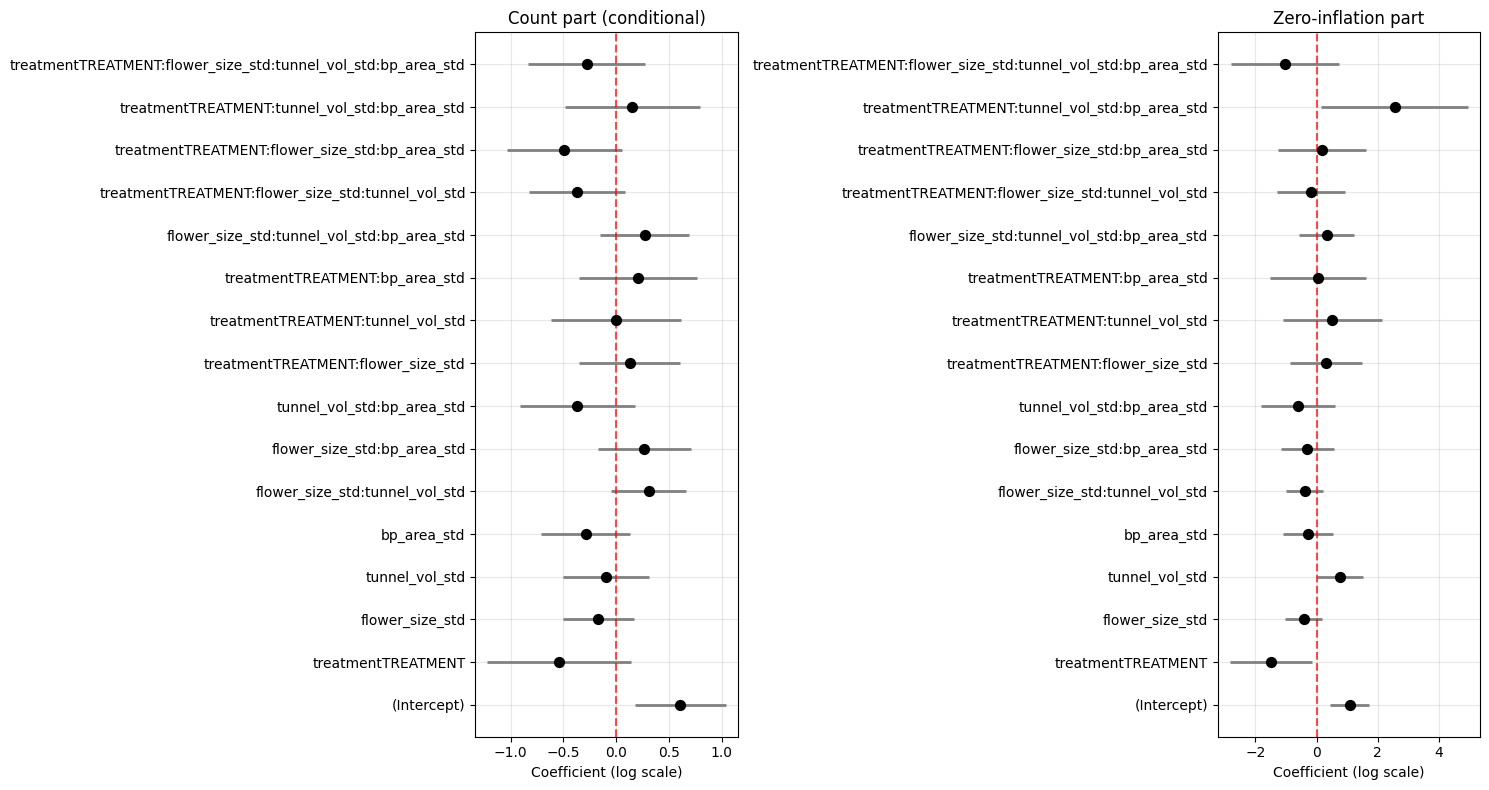

{'fixed_effects': {'cond':                                                  term  Estimate  Std_Error  \
  0                                         (Intercept)  0.605662   0.220222   
  1                                  treatmentTREATMENT -0.539277   0.347761   
  2                                     flower_size_std -0.169644   0.170791   
  3                                      tunnel_vol_std -0.095623   0.206731   
  4                                         bp_area_std -0.290080   0.213982   
  5                      flower_size_std:tunnel_vol_std  0.307102   0.180296   
  6                         flower_size_std:bp_area_std  0.266703   0.224351   
  7                          tunnel_vol_std:bp_area_std -0.368424   0.277030   
  8                  treatmentTREATMENT:flower_size_std  0.127146   0.244667   
  9                   treatmentTREATMENT:tunnel_vol_std -0.001408   0.314341   
  10                     treatmentTREATMENT:bp_area_std  0.208230   0.285135   
  11         fl

In [ ]:

# Define the model formulas for glmmTMB
# We model both the count and the zero-inflation part with the same predictors
# including interactions and a random intercept for genotype_id.
count_formula = "seed ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std + flower_size_std:tunnel_vol_std + flower_size_std:bp_area_std + tunnel_vol_std:bp_area_std + flower_size_std:tunnel_vol_std:bp_area_std) + (1|genotype_id) + offset(log(mean_seed_by_group))"
zi_formula = "~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std + flower_size_std:tunnel_vol_std + flower_size_std:bp_area_std + tunnel_vol_std:bp_area_std + flower_size_std:tunnel_vol_std:bp_area_std) + (1|genotype_id) + offset(log(mean_fruit_by_group))"

print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_net)} flowers from {df_net['genotype_id'].nunique()} genotypes")
print()

# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_net = ro.conversion.py2rpy(df_net)

# Fit the model
zinb_mixed_model = glmmTMB.glmmTMB(
    formula=ro.Formula(count_formula),
    ziformula=ro.Formula(zi_formula),
    data=r_df_net,
    family=glmmTMB.truncated_nbinom2
)

# Print the model summary
print("MODEL SUMMARY:")
print(base.summary(zinb_mixed_model))
    

summarize_and_plot_glmmTMB(zinb_mixed_model)

C:\Users\asaf4\AppData\Local\Temp\ipykernel_39208\588507651.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_net["predicted"] = pandas2ri.rpy2py(pred_r).flatten()


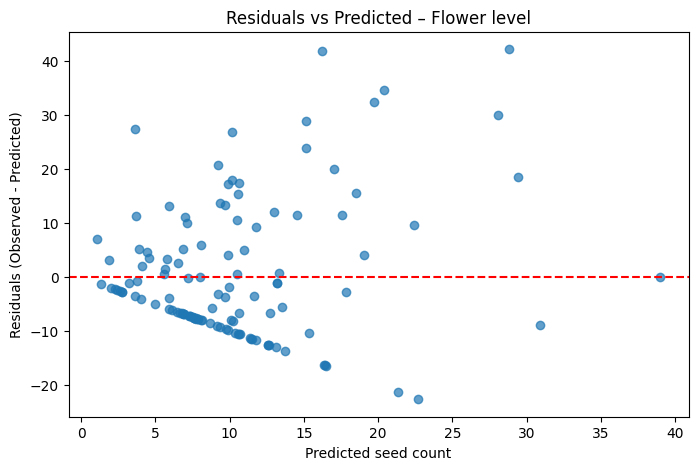

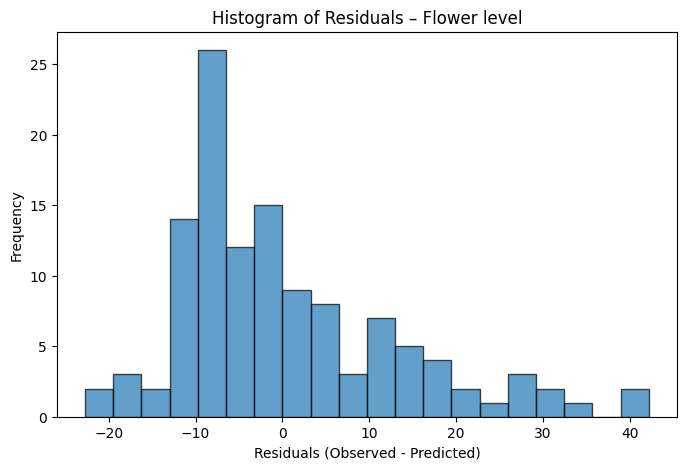

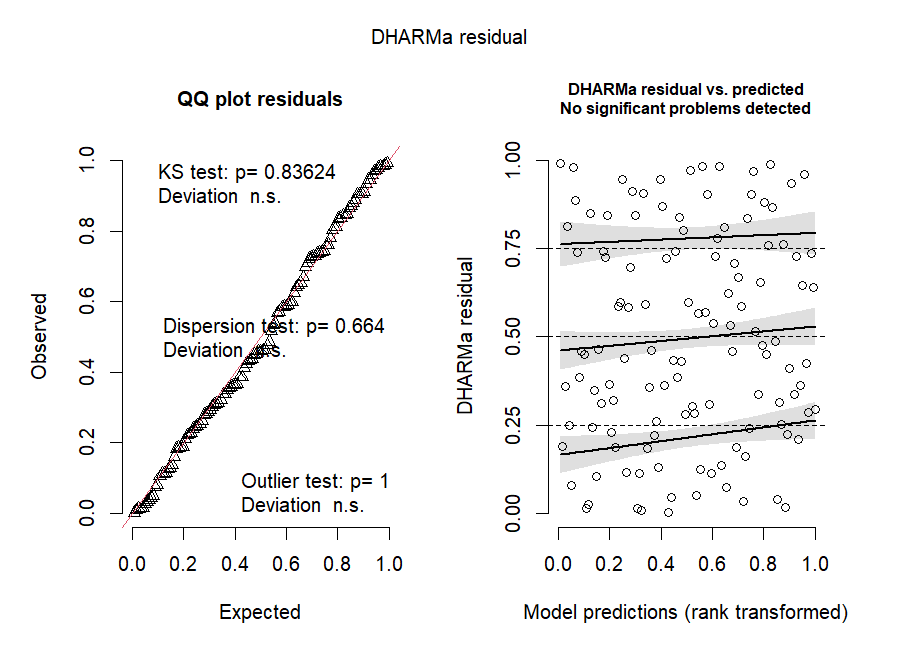

In [ ]:
adiagnostics(df_net, zinb_mixed_model)

### ZINB Quadratic + directional + interactions

FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...
------------------------------------------------------------
Count Formula: seed ~ treatment * (flower_size_std + I(flower_size_std ** 2) + tunnel_vol_std + I(tunnel_vol_std ** 2) + bp_area_std + I(bp_area_std ** 2) + flower_size_std:tunnel_vol_std + flower_size_std:bp_area_std + tunnel_vol_std:bp_area_std + flower_size_std:tunnel_vol_std:bp_area_std) + (1|genotype_id) + offset(log(mean_seed_by_group))
Zero-Inflation Formula: ~ treatment * (flower_size_std + I(flower_size_std ** 2) + tunnel_vol_std + I(tunnel_vol_std ** 2) + bp_area_std + I(bp_area_std ** 2) + flower_size_std:tunnel_vol_std + flower_size_std:bp_area_std + tunnel_vol_std:bp_area_std + flower_size_std:tunnel_vol_std:bp_area_std) + (1|genotype_id) + offset(log(mean_fruit_by_group))
Sample size: 121 flowers from 48 genotypes

MODEL SUMMARY:

=== GLMMTMB MODEL SUMMARY ===

Standard model summary:



=== VARIANCE COMPONENTS (RANDOM EFFECTS) ===
Error extracting variance c

,index,(Intercept),Group_Variable,Component
0,N006,-0.479397,genotype_id,cond
1,N007,-0.094269,genotype_id,cond
2,N012,0.430051,genotype_id,cond
3,N016,0.000000,genotype_id,cond
4,N017,0.129353,genotype_id,cond
5,N041,0.000000,genotype_id,cond
6,N043,0.525656,genotype_id,cond
7,N049,0.000000,genotype_id,cond
8,N050,-0.035129,genotype_id,cond
9,N051,0.000000,genotype_id,cond


... and 38 more rows

ZI model random effects:


,index,(Intercept),Group_Variable,Component
0,N006,-2.471511e-09,genotype_id,zi
1,N007,-4.456232e-09,genotype_id,zi
2,N012,-3.863730e-09,genotype_id,zi
3,N016,3.704303e-09,genotype_id,zi
4,N017,-2.889451e-10,genotype_id,zi
5,N041,5.792327e-09,genotype_id,zi
6,N043,-6.969817e-09,genotype_id,zi
7,N049,3.445724e-09,genotype_id,zi
8,N050,2.669948e-09,genotype_id,zi
9,N051,3.402580e-09,genotype_id,zi


... and 38 more rows


=== FIXED EFFECTS SUMMARY ===

Fixed effects – COUNT (conditional) part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.982636,0.264298,3.717916,0.000201
1,treatmentTREATMENT,-0.585186,0.463496,-1.262546,0.206752
2,flower_size_std,0.009587,0.233512,0.041056,0.967251
3,I(flower_size_std^2),-0.168823,0.088947,-1.898025,0.057693
4,tunnel_vol_std,-0.098566,0.173701,-0.567448,0.570410
5,I(tunnel_vol_std^2),-0.289036,0.191981,-1.505541,0.132185
6,bp_area_std,-0.195649,0.222587,-0.878978,0.379413
7,I(bp_area_std^2),-0.212622,0.126033,-1.687038,0.091596
8,flower_size_std:tunnel_vol_std,0.538778,0.165541,3.254657,0.001135
9,flower_size_std:bp_area_std,0.408707,0.191473,2.134538,0.032799



Fixed effects – ZERO-INFLATION part:


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.984117,0.410000,2.400283,0.016382
1,treatmentTREATMENT,-0.155922,1.027232,-0.151789,0.879354
2,flower_size_std,-0.021023,0.463393,-0.045367,0.963815
3,I(flower_size_std^2),-0.258354,0.296039,-0.872705,0.382824
4,tunnel_vol_std,0.537455,0.429722,1.250702,0.211043
5,I(tunnel_vol_std^2),0.145541,0.262979,0.553435,0.579966
6,bp_area_std,-0.353373,0.482378,-0.732565,0.463824
7,I(bp_area_std^2),0.072902,0.246316,0.295970,0.767253
8,flower_size_std:tunnel_vol_std,-0.287146,0.468182,-0.613321,0.539664
9,flower_size_std:bp_area_std,-0.324236,0.471014,-0.688379,0.491214



=== MODEL DIAGNOSTICS ===
Log-likelihood: -316.3624
AIC: 726.7247
BIC: 858.1269

=== COEFFICIENT PLOTS ===


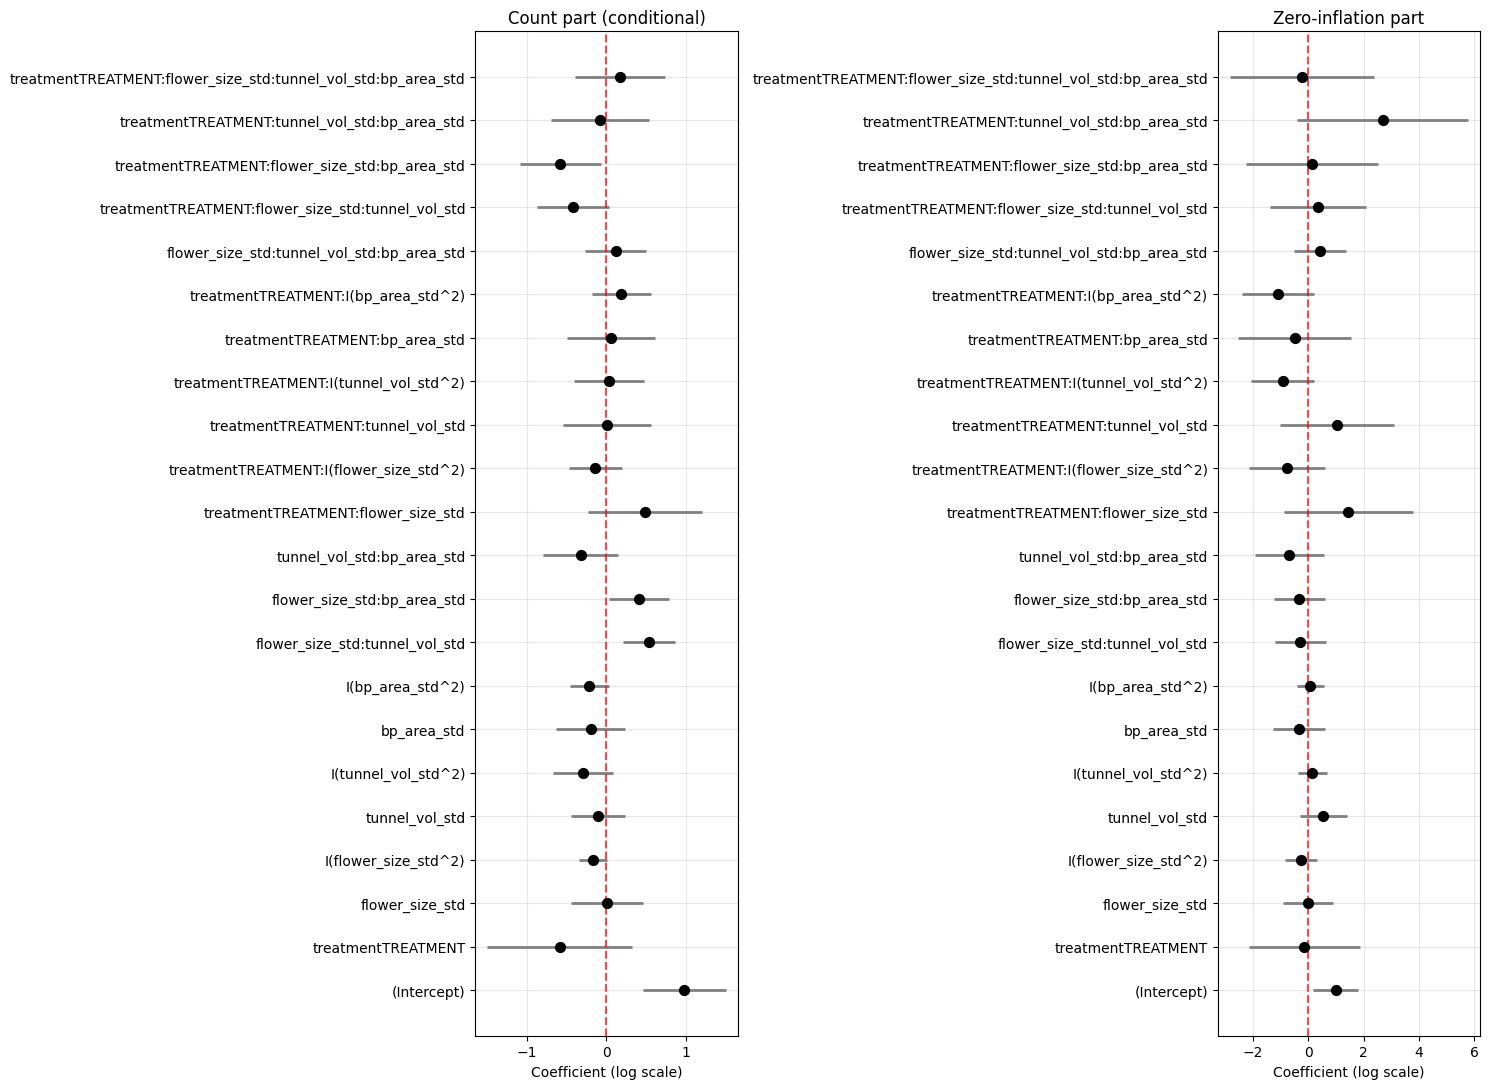

In [ ]:

# Define the model formulas for glmmTMB
# We model both the count and the zero-inflation part with the same predictors
# including interactions and a random intercept for genotype_id.
count_formula = "seed ~ treatment * (flower_size_std + I(flower_size_std ** 2) + tunnel_vol_std + I(tunnel_vol_std ** 2) + bp_area_std + I(bp_area_std ** 2) + flower_size_std:tunnel_vol_std + flower_size_std:bp_area_std + tunnel_vol_std:bp_area_std + flower_size_std:tunnel_vol_std:bp_area_std) + (1|genotype_id) + offset(log(mean_seed_by_group))"
zi_formula = "~ treatment * (flower_size_std + I(flower_size_std ** 2) + tunnel_vol_std + I(tunnel_vol_std ** 2) + bp_area_std + I(bp_area_std ** 2) + flower_size_std:tunnel_vol_std + flower_size_std:bp_area_std + tunnel_vol_std:bp_area_std + flower_size_std:tunnel_vol_std:bp_area_std) + (1|genotype_id) + offset(log(mean_fruit_by_group))"

print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_net)} flowers from {df_net['genotype_id'].nunique()} genotypes")
print()

# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_net = ro.conversion.py2rpy(df_net)

# Fit the model
zinb_mixed_model = glmmTMB.glmmTMB(
    formula=ro.Formula(count_formula),
    ziformula=ro.Formula(zi_formula),
    data=r_df_net,
    family=glmmTMB.truncated_nbinom2
)

# Print the model summary
print("MODEL SUMMARY:")
print(base.summary(zinb_mixed_model))
    

zinb_dict = summarize_and_plot_glmmTMB(zinb_mixed_model)

C:\Users\asaf4\AppData\Local\Temp\ipykernel_39208\588507651.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_net["predicted"] = pandas2ri.rpy2py(pred_r).flatten()


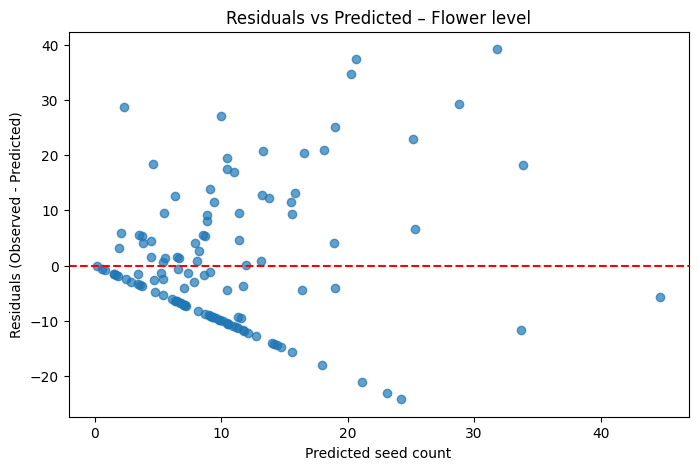

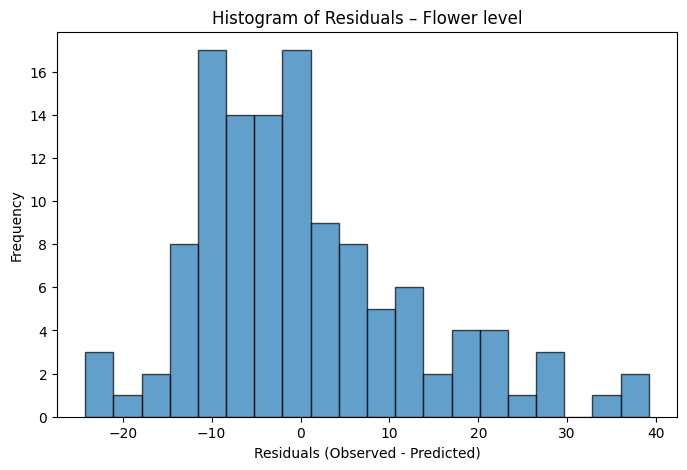

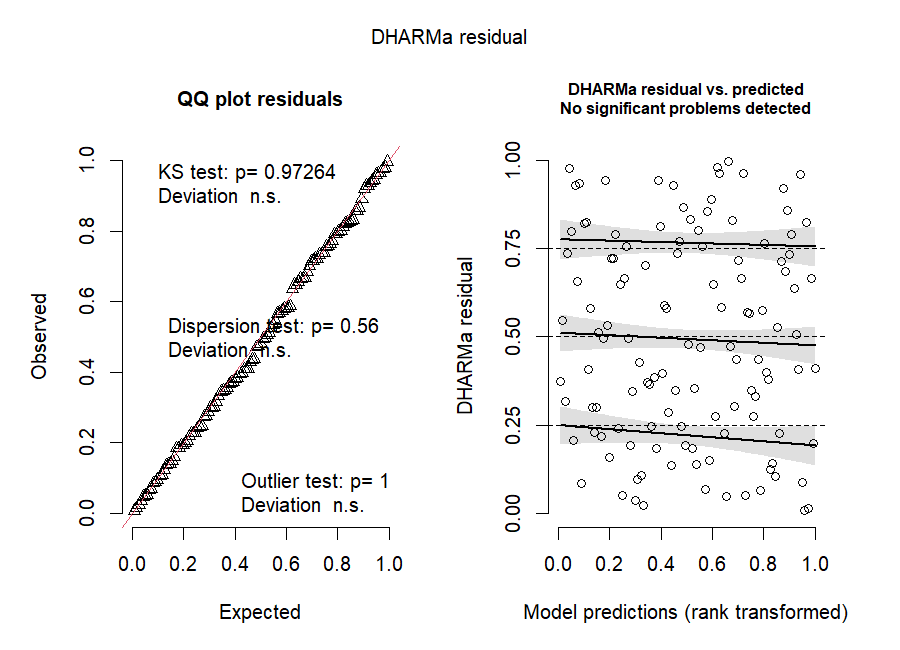

In [ ]:
adiagnostics(df_net, zinb_mixed_model)

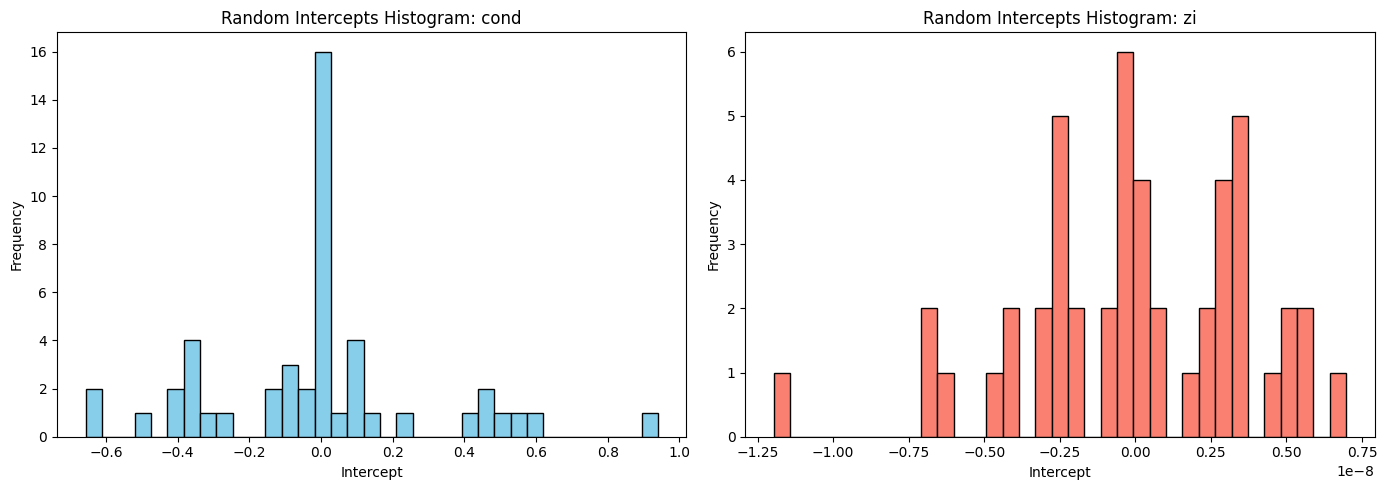

Normality tests for random intercepts:

cond random intercepts:
  Shapiro-Wilk test:      W=0.9253, p=0.004581

zi random intercepts:
  Shapiro-Wilk test:      W=0.9655, p=0.1689


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest, anderson

# Extract the two keys from the zinb_dict (should be 'cond' and 'zi')
re_keys = list(zinb_dict['random_effects'].keys())
df_cond = zinb_dict['random_effects'][re_keys[0]]
df_zi = zinb_dict['random_effects'][re_keys[1]]

# Convert to pandas DataFrame if not already
if not isinstance(df_cond, pd.DataFrame):
    df_cond = pd.DataFrame(df_cond)
if not isinstance(df_zi, pd.DataFrame):
    df_zi = pd.DataFrame(df_zi)

# Plot histograms of the (Intercept) column for both random effects
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df_cond['(Intercept)'], bins=35, color='skyblue', edgecolor='black')
axes[0].set_title(f"Random Intercepts Histogram: {re_keys[0]}")
axes[0].set_xlabel("Intercept")
axes[0].set_ylabel("Frequency")

axes[1].hist(df_zi['(Intercept)'], bins=35, color='salmon', edgecolor='black')
axes[1].set_title(f"Random Intercepts Histogram: {re_keys[1]}")
axes[1].set_xlabel("Intercept")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Test for normality of the random intercepts
print("Normality tests for random intercepts:")

for name, df in zip(re_keys, [df_cond, df_zi]):
    intercepts = df['(Intercept)'].dropna()
    print(f"\n{name} random intercepts:")

    # Shapiro-Wilk test
    if len(intercepts) >= 3 and len(intercepts) <= 5000:
        stat, p = shapiro(intercepts)
        print(f"  Shapiro-Wilk test:      W={stat:.4f}, p={p:.4g}")
    else:
        print("  Shapiro-Wilk test:      Not run (sample size out of bounds for test)")


## Genotype Level
- Add # of flowers per genotype as a variable. (Scale)
- using mean, median, std of flower size, (Different aggregation functions)


In [ ]:
genotype_stats_net = genotype_stats[genotype_stats['population'] == 'NET']


### Observe seed set distribution

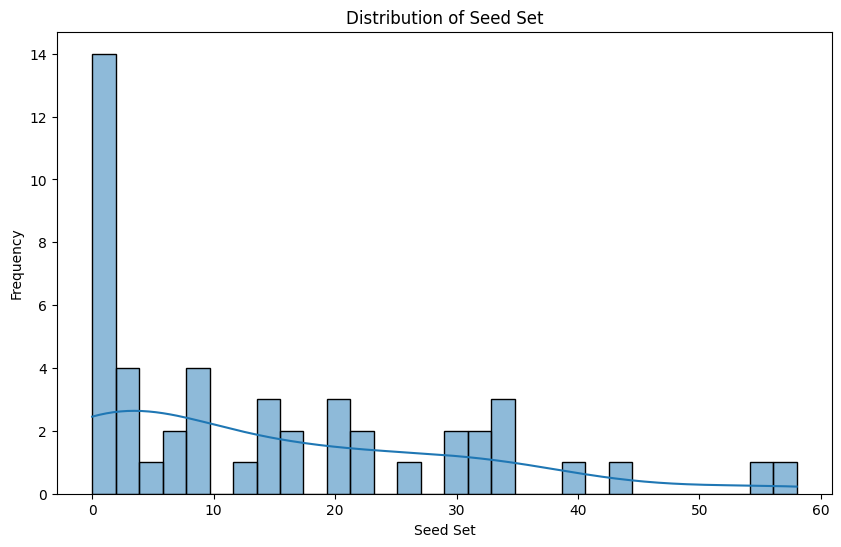

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(genotype_stats_net['seed_set'],bins= 30, kde=True)
plt.title('Distribution of Seed Set')
plt.xlabel('Seed Set')
plt.ylabel('Frequency')
plt.show()


### Aggregations

In [ ]:
# Calculate aggregations (mean, std, min, max) for covariate variables if present
covariate_vars = ['flower_size_std', 'tunnel_vol_std', 'bp_area_std']
covariate_aggs = {}
for var in covariate_vars:
    if var in df.columns:
        covariate_aggs[var] = ['mean', 'std', 'min', 'max']

if covariate_aggs:
    covariate_stats = df.groupby('genotype_id').agg(covariate_aggs)
    # Flatten MultiIndex columns
    covariate_stats.columns = ['{}_{}'.format(var, stat) for var, stat in covariate_stats.columns]
    covariate_stats = covariate_stats.reset_index()
    genotype_stats = genotype_stats.merge(covariate_stats, on='genotype_id', how='left')


In [ ]:
genotype_stats

,genotype_id,population,treatment,total_flowers,total_fruits,total_seeds,seed_set,fruit_set
0,K135,KUR,CONTROL,1,1.0,8.0,8.00,1.0
1,K136,KUR,CONTROL,2,0.0,0.0,0.00,0.0
2,K139,KUR,CONTROL,1,1.0,19.0,19.00,1.0
3,K140,KUR,CONTROL,5,4.0,117.0,29.25,0.8
4,K142,KUR,CONTROL,1,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...
88,N234,NET,CONTROL,1,0.0,0.0,0.00,0.0
89,N900,NET,CONTROL,1,0.0,0.0,0.00,0.0
90,N902,NET,TREATMENT,1,1.0,6.0,6.00,1.0
91,N906,NET,CONTROL,1,0.0,0.0,0.00,0.0


In [ ]:
genotype_stats_net = genotype_stats[genotype_stats['population'] == 'NET']
genotype_stats_net[:5]

,genotype_id,population,treatment,total_flowers,total_fruits,total_seeds,seed_set,fruit_set
45,N006,NET,TREATMENT,1,1.0,3.0,3.00,1.0
46,N007,NET,CONTROL,1,1.0,15.0,15.00,1.0
47,N012,NET,TREATMENT,5,4.0,127.0,31.75,0.8
48,N016,NET,TREATMENT,1,0.0,0.0,0.00,0.0
49,N017,NET,TREATMENT,1,1.0,7.0,7.00,1.0


In [ ]:
genotype_stats.columns

Index(['genotype_id', 'population', 'treatment', 'total_flowers',
       'total_fruits', 'total_seeds', 'seed_set', 'fruit_set'],
      dtype='object')

In [ ]:
# Calculate seed set mean per treatment and add as a column
seed_set_mean_per_treatment = genotype_stats_net.groupby('treatment')['seed_set'].mean()
genotype_stats_net = genotype_stats_net.copy()
genotype_stats_net['seed_set_mean_per_treatment'] = genotype_stats_net['treatment'].map(seed_set_mean_per_treatment)
# Calculate fruit set mean per treatment and add as a column
fruit_set_mean_per_treatment = genotype_stats_net.groupby('treatment')['fruit_set'].mean()
genotype_stats_net['fruit_set_mean_per_treatment'] = genotype_stats_net['treatment'].map(fruit_set_mean_per_treatment)


### Model

In [ ]:
# # Define the model formulas for glmmTMB
# # We model both the count and the zero-inflation part with the same predictors
# # including interactions and a random intercept for genotype_id.
# count_formula = "seed_set ~ treatment * (flower_size_std_mean + tunnel_vol_std_mean + bp_area_std_mean) + total_flowers + offset(log(seed_set_mean_per_treatment))"
# zi_formula = "~ treatment * (flower_size_std_mean + tunnel_vol_std_mean + bp_area_std_mean) +total_flowers + offset(log(fruit_set_mean_per_treatment))"

# print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
# print("-" * 60)
# print(f"Count Formula: {count_formula}")
# print(f"Zero-Inflation Formula: {zi_formula}")
# print(f"Sample size: {len(genotype_stats_net)} flowers from {genotype_stats_net['genotype_id'].nunique()} genotypes")
# print()

# # Convert pandas dataframe to R dataframe
# with localconverter(ro.default_converter + pandas2ri.converter):
#   r_genotype_stats_net = ro.conversion.py2rpy(genotype_stats_net)

# # Fit the model
# zinb_mixed_model = glmmTMB.glmmTMB(
#     formula=ro.Formula(count_formula),
#     ziformula=ro.Formula(zi_formula),
#     data=r_genotype_stats_net,
#     family=glmmTMB.truncated_nbinom2
# )

# # Print the model summary
# print("MODEL SUMMARY:")
# print(base.summary(zinb_mixed_model))
    

# summarize_and_plot_glmmTMB(zinb_mixed_model)

In [ ]:
# adiagnostics()

## Flower Level

### One Model - ZINB - on seed count - only NET- withot mixed models

In [ ]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP

print("ZINB Model Implementation for Iris Seed Count Data")
print("=" * 55)

# First, let's examine our data for zero-inflation and overdispersion
print("EXAMINING DATA FOR ZINB SUITABILITY:")
print("-" * 40)

# Look at the distribution of seed counts
seed_counts = df['seed'].values
fruit_binary = df['fruit'].values

print(f"Total flowers: {len(seed_counts)}")
print(f"Flowers with 0 seeds: {sum(seed_counts == 0)} ({100*sum(seed_counts == 0)/len(seed_counts):.1f}%)")
print(f"Flowers with >0 seeds: {sum(seed_counts > 0)} ({100*sum(seed_counts > 0)/len(seed_counts):.1f}%)")
print()

# Basic statistics
print("SEED COUNT STATISTICS:")
print(f"Mean: {np.mean(seed_counts):.3f}")
print(f"Variance: {np.var(seed_counts):.3f}")
print(f"Variance-to-Mean Ratio: {np.var(seed_counts)/np.mean(seed_counts):.3f}")
print("(Ratio > 1 indicates overdispersion)")
print()

# Check if zeros are from flowers without fruit vs flowers with fruit but no seeds
zero_seed_no_fruit = sum((seed_counts == 0) & (fruit_binary == 0))
zero_seed_with_fruit = sum((seed_counts == 0) & (fruit_binary == 1))

print("ZERO BREAKDOWN:")
print(f"Zeros from flowers with no fruit (structural): {zero_seed_no_fruit}")
print(f"Zeros from flowers with fruit but no seeds: {zero_seed_with_fruit}")
print(f"Total zeros: {zero_seed_no_fruit + zero_seed_with_fruit}")

# Plot distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram of all seed counts
axes[0].hist(seed_counts, bins=range(int(max(seed_counts))+2), alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of Seed Counts\n(All Flowers)')
axes[0].set_xlabel('Number of Seeds')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(seed_counts), color='red', linestyle='--', label=f'Mean: {np.mean(seed_counts):.2f}')
axes[0].legend()

# Histogram of seed counts for flowers that produced fruit
fruit_flowers = df[df['fruit'] == 1]['seed'].values
if len(fruit_flowers) > 0:
    axes[1].hist(fruit_flowers, bins=range(int(max(fruit_flowers))+2), alpha=0.7, edgecolor='black', color='orange')
    axes[1].set_title('Distribution of Seed Counts\n(Only Flowers with Fruit)')
    axes[1].set_xlabel('Number of Seeds')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(np.mean(fruit_flowers), color='red', linestyle='--', label=f'Mean: {np.mean(fruit_flowers):.2f}')
    axes[1].legend()

# Bar plot showing zero vs non-zero by fruit status
zero_data = pd.DataFrame({
    'fruit_status': ['No Fruit', 'Has Fruit', 'Has Fruit'],
    'seed_status': ['Zero Seeds', 'Zero Seeds', 'Positive Seeds'],
    'count': [zero_seed_no_fruit, zero_seed_with_fruit, sum((seed_counts > 0) & (fruit_binary == 1))]
})

sns.barplot(data=zero_data, x='fruit_status', y='count', hue='seed_status', ax=axes[2])
axes[2].set_title('Seed Counts by Fruit Status')
axes[2].set_xlabel('Fruit Status')
axes[2].set_ylabel('Number of Flowers')

plt.tight_layout()
plt.show()

# Prepare data for ZINB modeling
print("\nPREPARING ZINB MODEL:")
print("-" * 25)

# Create dummy variables for categorical predictors

df_model = df.copy()
df_model = df_model[df_model['population'] == 'NET']

# Encode treatment (CONTROL as reference) 
df_model['treatment_TREATMENT'] = (df_model['treatment'] == 'TREATMENT').astype(int)

# Standardize continuous predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

continuous_vars = ['Flower Size (cm^2)', 'Tunnel Volume (cm^3)', 'Black Patch Area (cm^2)']
df_model[['flower_size_std', 'tunnel_volume_std', 'bp_area_std']] = scaler.fit_transform(df_model[continuous_vars])

print("- Interaction terms between treatment and continuous variables")
for col in ['flower_size_std', 'tunnel_volume_std', 'bp_area_std']:
    df_model[f'treat_x_{col}'] = df_model['treatment_TREATMENT'] * df_model[col]


print("Model variables created:")
print("- treatment_TREATMENT: 1=TREATMENT, 0=CONTROL")
print("- Standardized continuous variables (mean=0, std=1)")
print()

# For the count model (negative binomial part)
interaction_terms = [f'treat_x_{col}' for col in ['flower_size_std', 'tunnel_volume_std', 'bp_area_std']]
X_count = df_model[['treatment_TREATMENT', 'flower_size_std', 'tunnel_volume_std', 'bp_area_std'] + interaction_terms]
X_count = sm.add_constant(X_count)  # Add intercept

# For the zero-inflation model (logistic part) 
# We'll use the same predictors, but you could use different ones
X_zero = X_count.copy()

# Response variable
y = df_model['seed'].values

print(f"Sample size: {len(y)}")
print(f"Predictors: {list(X_count.columns)}")
print()

# Fit the ZINB model
print("FITTING ZINB MODEL...")
print("-" * 20)

try:
    # Create and fit the ZINB model
    zinb_model = ZeroInflatedNegativeBinomialP(
        y, 
        X_count, 
        exog_infl=X_zero,  # Variables for zero-inflation
        inflation='logit'   # Use logistic for zero-inflation
    )
    
    zinb_results = zinb_model.fit(method='bfgs', maxiter=1000, disp=True)
    
    print("✓ ZINB model fitted successfully!")
    print()
    
except Exception as e:
    print(f"Error fitting ZINB model: {e}")
    print("This might be due to convergence issues or data structure.")
    zinb_results = None


ZINB Model Implementation for Iris Seed Count Data
EXAMINING DATA FOR ZINB SUITABILITY:
----------------------------------------


KeyError: 'seed'

In [ ]:
print("ZINB MODEL RESULTS:")
print("=" * 40)

# Print model summary
print(zinb_results.summary())
print()

ZINB MODEL RESULTS:
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                 y   No. Observations:                  121
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      113
Method:                                      MLE   Df Model:                            7
Date:                           Sat, 05 Jul 2025   Pseudo R-squ.:                 0.02342
Time:                                   10:41:08   Log-Likelihood:                -338.83
converged:                                  True   LL-Null:                       -346.95
Covariance Type:                       nonrobust   LLR p-value:                   0.02293
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
inflate_const                        -0.0110      0.239 

C:\Users\asaf4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\discrete\discrete_model.py:3937: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


In [ ]:
# Extract and interpret coefficients
print("COEFFICIENT INTERPRETATION:")
print("-" * 30)

# Count model coefficients (negative binomial part)
print("COUNT MODEL (Negative Binomial Part):")
print("→ Models the number of seeds for flowers that CAN produce seeds")
count_params = zinb_results.params[:len(X_count.columns)]
count_pvalues = zinb_results.pvalues[:len(X_count.columns)]

for i, (param, pval) in enumerate(zip(count_params, count_pvalues)):
    var_name = X_count.columns[i]
    significance = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
    print(f"  {var_name}: {param:.4f} (p={pval:.4f}) {significance}")
    
    # Interpret the coefficient
    if var_name == 'const':
        print(f"    → Baseline log(seed count) when all predictors = 0")
    elif 'population_NET' in var_name:
        direction = "higher" if param > 0 else "lower"
        print(f"    → NET population has {direction} seed counts than KUR (log scale)")
    elif 'treatment_TREATMENT' in var_name:
        direction = "higher" if param > 0 else "lower"
        print(f"    → TREATMENT has {direction} seed counts than CONTROL (log scale)")
    else:
        direction = "increases" if param > 0 else "decreases"
        print(f"    → 1 SD increase {direction} log(seed count) by {abs(param):.4f}")

print()

# Zero-inflation model coefficients (logistic part)
print("ZERO-INFLATION MODEL (Logistic Part):")
print("→ Models the probability of being a 'structural zero' (never can produce seeds)")

# Correctly slice the parameters to exclude the final alpha term
count_param_len = len(X_count.columns)
zero_param_len = len(X_zero.columns)
inflate_params = zinb_results.params[count_param_len : count_param_len + zero_param_len]
inflate_pvalues = zinb_results.pvalues[count_param_len : count_param_len + zero_param_len]

for i, (param, pval) in enumerate(zip(inflate_params, inflate_pvalues)):
    var_name = X_zero.columns[i]
    significance = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
    print(f"  {var_name}: {param:.4f} (p={pval:.4f}) {significance}")
    
    # Interpret the coefficient (note: positive = higher probability of structural zero)
    if var_name == 'const':
        print(f"    → Baseline log-odds of structural zero when all predictors = 0")
    elif 'population_NET' in var_name:
        direction = "higher" if param > 0 else "lower"
        print(f"    → NET population has {direction} probability of structural zeros than KUR")
    elif 'treatment_TREATMENT' in var_name:
        direction = "higher" if param > 0 else "lower"  
        print(f"    → TREATMENT has {direction} probability of structural zeros than CONTROL")
    else:
        direction = "increases" if param > 0 else "decreases"
        print(f"    → 1 SD increase {direction} log-odds of structural zero by {abs(param):.4f}")

print()
    
# Model fit statistics
print("MODEL FIT STATISTICS:")
print("-" * 20)
print(f"Log-Likelihood: {zinb_results.llf:.2f}")
print(f"AIC: {zinb_results.aic:.2f}")
print(f"BIC: {zinb_results.bic:.2f}")

# Correctly extract the overdispersion parameter (alpha)
# The last parameter in the results is log(alpha)
log_alpha = zinb_results.params[-1]
alpha = np.exp(log_alpha)
print(f"Overdispersion parameter (α): {alpha:.4f}")
if alpha > 1e-5: # Use a small threshold for numerical stability
    print("  → Overdispersion is present (α > 0)")
else:
    print("  → No significant overdispersion detected")


COEFFICIENT INTERPRETATION:
------------------------------
COUNT MODEL (Negative Binomial Part):
→ Models the number of seeds for flowers that CAN produce seeds
  const: -0.0110 (p=0.9632) 
    → Baseline log(seed count) when all predictors = 0
  treatment_TREATMENT: -0.7147 (p=0.0903) 
    → TREATMENT has lower seed counts than CONTROL (log scale)
  flower_size_std: -0.5250 (p=0.0635) 
    → 1 SD increase decreases log(seed count) by 0.5250
  tunnel_volume_std: 0.4863 (p=0.1027) 
    → 1 SD increase increases log(seed count) by 0.4863
  bp_area_std: -0.2635 (p=0.3138) 
    → 1 SD increase decreases log(seed count) by 0.2635
  treat_x_flower_size_std: 0.4738 (p=0.3007) 
    → 1 SD increase increases log(seed count) by 0.4738
  treat_x_tunnel_volume_std: -0.1187 (p=0.7878) 
    → 1 SD increase decreases log(seed count) by 0.1187
  treat_x_bp_area_std: 0.1252 (p=0.7607) 
    → 1 SD increase increases log(seed count) by 0.1252

ZERO-INFLATION MODEL (Logistic Part):
→ Models the probabilit

C:\Users\asaf4\AppData\Local\Temp\ipykernel_37092\2413552297.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  log_alpha = zinb_results.params[-1]


In [ ]:
df_net.groupby(['population', 'treatment'])['seed'].mean()


population  treatment
NET         CONTROL      10.589744
            TREATMENT    11.767442
Name: seed, dtype: float64

In [ ]:
df_net["mean_seed_by_group"] = df_net.groupby(['population', 'treatment'])['seed'].transform('mean')
df_net

In [ ]:
df_net.groupby(['population', 'treatment'])['fruit'].mean()


population  treatment
NET         CONTROL      0.500000
            TREATMENT    0.651163
Name: fruit, dtype: float64

In [ ]:
df_net["mean_fruit_by_group"] = df_net.groupby(['population', 'treatment'])['fruit'].transform('mean')
df_net

C:\Users\asaf4\AppData\Local\Temp\ipykernel_37092\1042045100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_net["mean_fruit_by_group"] = df_net.groupby(['population', 'treatment'])['fruit'].transform('mean')


,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,...,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,flower_size_std,tunnel_vol_std,bp_area_std,predicted,mean_seed_by_group,mean_fruit_by_group
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,...,4.279209,8.166,1.0,8.0,3.200088,0.633587,0.228740,15.326396,10.589744,0.500000
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,...,3.040128,7.224,1.0,55.0,1.697706,-0.466135,-0.372518,13.054755,11.767442,0.651163
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,...,4.469580,7.652,1.0,39.0,2.018893,0.802547,-0.099335,12.766181,10.589744,0.500000
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,...,2.610160,7.958,0.0,0.0,1.667861,-0.847745,0.095978,13.629407,10.589744,0.500000
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,...,4.061904,5.656,0.0,0.0,1.940325,0.440722,-1.373339,11.627036,10.589744,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,2024-03-06,29,NET,BLUE,N090,90.1,CONTROL,75.5,60.9,...,1.832787,7.489,1.0,34.0,0.043910,-1.537688,-0.203374,11.228423,10.589744,0.500000
124,125,2024-03-06,29,NET,BLUE,N098,98.1,TREATMENT,70.5,65.2,...,2.556036,10.928,1.0,2.0,0.042727,-0.895782,1.991665,13.640487,11.767442,0.651163
125,126,2024-03-06,29,NET,BLUE,N103,103.1,TREATMENT,56.7,54.1,...,1.978792,11.095,1.0,39.0,-1.297532,-1.408104,2.098258,19.720744,11.767442,0.651163
126,127,2024-03-06,29,NET,BLUE,N199,199.2,CONTROL,75.0,53.5,...,2.726012,9.072,0.0,0.0,-0.469227,-0.744923,0.807020,10.280354,10.589744,0.500000


## ZINB Mixed using R

### Functions

In [ ]:
df_net = df[df['population'] == 'NET'].copy()

In [ ]:
# Define the model formulas for glmmTMB
# We model both the count and the zero-inflation part with the same predictors
# including interactions and a random intercept for genotype_id.
count_formula = "seed ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std) + (1|genotype_id) + offset(log(mean_seed_by_group))"
zi_formula = "~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std) + (1|genotype_id)"

print("FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...")
print("-" * 60)
print(f"Count Formula: {count_formula}")
print(f"Zero-Inflation Formula: {zi_formula}")
print(f"Sample size: {len(df_net)} flowers from {df_net['genotype_id'].nunique()} genotypes")
print()

# Convert pandas dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_net = ro.conversion.py2rpy(df_net)

# Fit the model
# family=glmmTMB.nbinom2 specifies a negative binomial distribution for the count part.
try:
    zinb_mixed_model = glmmTMB.glmmTMB(
        formula=ro.Formula(count_formula),
        ziformula=ro.Formula(zi_formula),
        data=r_df_net,
        family=glmmTMB.truncated_nbinom2
    )
    
    # Print the model summary
    print("MODEL SUMMARY:")
    print(base.summary(zinb_mixed_model))
    
except Exception as e:
    print("An error occurred while fitting the glmmTMB model:")
    print(e)
    print("\nPlease ensure that the 'glmmTMB' package is installed in your R environment.")


FITTING ZINB MIXED-EFFECTS MODEL using R's glmmTMB...
------------------------------------------------------------
Count Formula: seed ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std) + (1|genotype_id) + offset(log(mean_seed_by_group))
Zero-Inflation Formula: ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std) + (1|genotype_id)
Sample size: 121 flowers from 48 genotypes

MODEL SUMMARY:



In [ ]:
from rpy2.robjects import r, pandas2ri, default_converter
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr

stats = importr("stats")          # gives you stats::predict()

# make sure newdata is an R-data.frame
with localconverter(default_converter + pandas2ri.converter):
    r_df_net = pandas2ri.py2rpy(df_net)

# get expected counts on the response scale
pred_r = stats.predict(zinb_mixed_model,
                       newdata=r_df_net,
                       type="response")

# bring them back to Python
with localconverter(default_converter + pandas2ri.converter):
    df_net["predicted"] = pandas2ri.rpy2py(pred_r).flatten()

C:\Users\asaf4\AppData\Local\Temp\ipykernel_37092\1188896679.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_net["predicted"] = pandas2ri.rpy2py(pred_r).flatten()


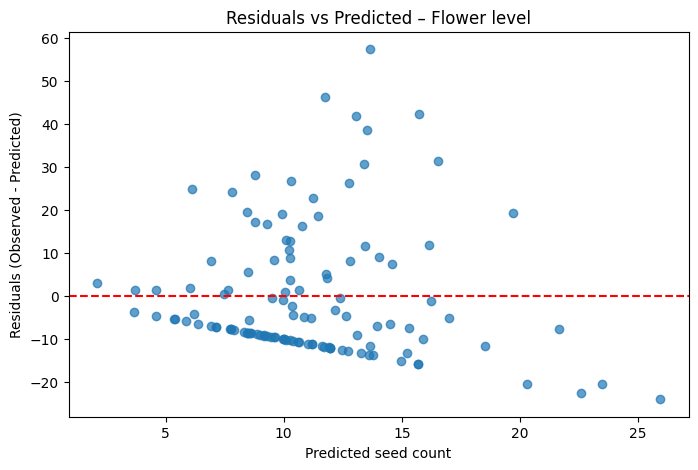

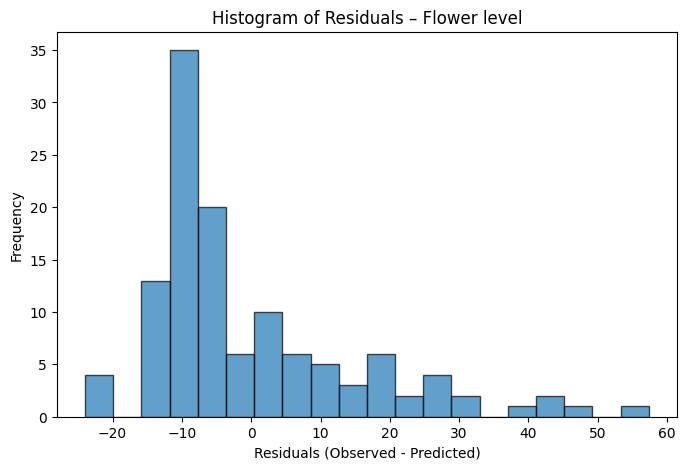

In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = df_net["seed"] - df_net["predicted"]

# Plot residuals vs predicted
plt.figure(figsize=(8,5))
plt.scatter(df_net["predicted"], residuals, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted seed count")
plt.ylabel("Residuals (Observed - Predicted)")
plt.title("Residuals vs Predicted – Flower level")
plt.show()

# Optionally, plot histogram of residuals
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Residuals (Observed - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals – Flower level")
plt.show()


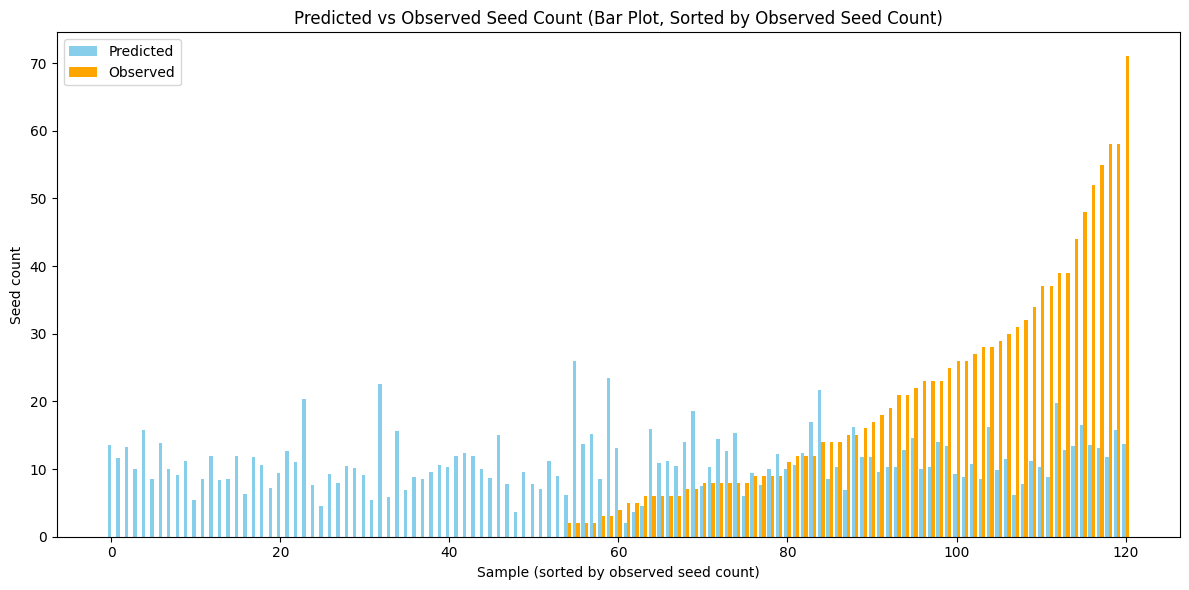

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Sort by observed seed count values
df_sorted = df_net.sort_values("seed").reset_index(drop=True)

plt.figure(figsize=(12, 6))
bar_width = 0.4
indices = range(len(df_sorted))

plt.bar([i - bar_width/2 for i in indices], df_sorted["predicted"], width=bar_width, label="Predicted", color="skyblue")
plt.bar([i + bar_width/2 for i in indices], df_sorted["seed"], width=bar_width, label="Observed", color="orange")

plt.xlabel("Sample (sorted by observed seed count)")
plt.ylabel("Seed count")
plt.title("Predicted vs Observed Seed Count (Bar Plot, Sorted by Observed Seed Count)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import tempfile, os
from IPython.display import Image, display
from rpy2.robjects.packages import importr
dharma = importr("DHARMa")
grdevices  = importr("grDevices")   # R's graphics devices


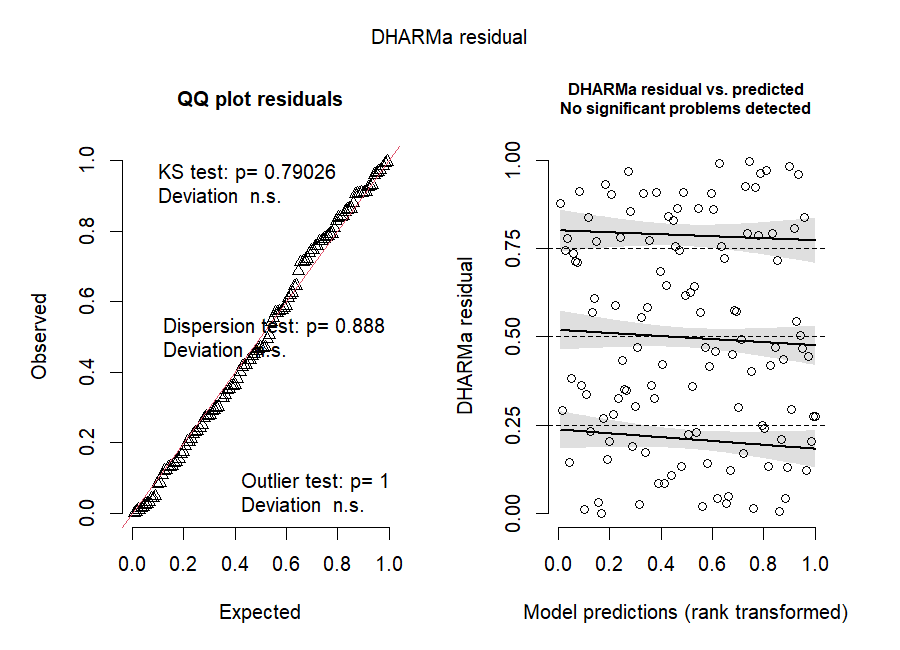

In [ ]:
# ----------------------------------------------------------
tmp = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
png_path = tmp.name
tmp.close()                          # R will write to this path

grdevices.png(png_path,
              width  = 900,          # pixels
              height = 650,
              res    = 120)          # DPI

dharma.plotSimulatedResiduals(sim_res)   # all panels into the device
grdevices.dev_off()                      # IMPORTANT: flush & close

# ----------------------------------------------------------
# 3) Display inside the notebook
# ----------------------------------------------------------
display(Image(filename=png_path))

In [ ]:
def show_dharma_diagnostic(sim_res, width=900, height=650, res=120, display_plot=True, remove_file=False):
    """
    Capture and display DHARMa's 4-panel diagnostic plot for a given simulated residuals object.

    Parameters
    ----------
    sim_res : R object
        The simulated residuals object from DHARMa.
    width : int, optional
        Width of the PNG in pixels (default: 900).
    height : int, optional
        Height of the PNG in pixels (default: 650).
    res : int, optional
        Resolution (DPI) of the PNG (default: 120).
    display_plot : bool, optional
        Whether to display the plot inline (default: True).
    remove_file : bool, optional
        Whether to delete the PNG file after displaying (default: False).

    Returns
    -------
    png_file : str
        Path to the generated PNG file.
    """
    import tempfile, os
    from IPython.display import display, Image
    from rpy2.robjects.packages import importr

    dharma    = importr("DHARMa")
    grdevices = importr("grDevices")

    def capture_r_plot(plot_func, width=900, height=650, res=120, **plot_kwargs):
        tmp = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
        png_path = tmp.name
        tmp.close()
        grdevices.png(filename=png_path, width=width, height=height, res=res)
        plot_func(**plot_kwargs)
        grdevices.dev_off()
        return png_path

    png_file = capture_r_plot(lambda: dharma.plotSimulatedResiduals(sim_res), width=width, height=height, res=res)

    if display_plot:
        display(Image(filename=png_file))

    if remove_file:
        try:
            os.remove(png_file)
        except Exception:
            pass

    return png_file

In [ ]:
# helper to convert df_net once
with localconverter(default_converter + pandas2ri.converter):
    r_df_net = pandas2ri.py2rpy(df_net)

# ------------------------------------------------------------
# 1. Fit Poisson vs Negative-Binomial mixed models
# ------------------------------------------------------------
count_fmla = "seed ~ treatment * (flower_size_std + tunnel_vol_std) + (1|genotype_id)"
zi_fmla    = "~ 1"                 # start with no extra ZI; adapt if needed

# write poisson variable as r


poi_mod = glmmTMB.glmmTMB(Formula(count_fmla),
                          ziformula = Formula("~0"),   # pure Poisson
                          data      = r_df_net,
                          family    = "poisson")

nb_mod  = glmmTMB.glmmTMB(Formula(count_fmla),
                          ziformula = Formula("~0"),
                          data      = r_df_net,
                          family    = glmmTMB.nbinom2)

print("AIC  (Poisson):", stats.AIC(poi_mod)[0])
print("AIC  (NB2)    :", stats.AIC(nb_mod)[0])
print("ΔAIC =", stats.AIC(poi_mod)[0] - stats.AIC(nb_mod)[0])

# Likelihood-ratio test (nested)
lrt = stats.anova(poi_mod, nb_mod)
print("\nLRT Poisson vs NB2\n", lrt)

# ------------------------------------------------------------
# 2. DHARMa dispersion test on Poisson GLMM
# ------------------------------------------------------------
sim_res_poi = dharma.simulateResiduals(poi_mod,
                                       integerResponse = True,
                                       plot = False)

print("\nDHARMa dispersion test (Poisson GLMM)")
print(dharma.testDispersion(sim_res_poi))

# optional: capture the plot like before
# png_path = capture_r_plot(lambda: dharma.plotSimulatedResiduals(sim_res_poi))
# display(Image(filename=png_path))

# ------------------------------------------------------------
# 3. Empirical mean–variance check within each genotype
# ------------------------------------------------------------
mv = (df_net
      .groupby("genotype_id")["seed"]
      .agg(["mean", "var", "count"])
      .reset_index())
mv["var_over_mean"] = mv["var"] / mv["mean"]
print("\nMean–Variance by genotype\n", mv.head())

print("Overall mean var/mean =", mv['var_over_mean'].mean())

AIC  (Poisson): 1837.0208053201147
AIC  (NB2)    : 741.4742225676384
ΔAIC = 1095.5465827524763

LRT Poisson vs NB2
 

DHARMa dispersion test (Poisson GLMM)


Mean–Variance by genotype
   genotype_id  mean    var  count  var_over_mean
0        N006   3.0    NaN      1            NaN
1        N007  15.0    NaN      1            NaN
2        N012  25.4  537.8      5      21.173228
3        N016   0.0    NaN      1            NaN
4        N017   7.0    NaN      1            NaN
Overall mean var/mean = 17.929502830188188


## Two Model

In [ ]:
# --- Step 1: Create the Fruit Hurdle Model ---
# This model predicts the probability of a flower setting fruit (fruit == 1).
# It uses ALL of your data.
print("FITTING MODEL 1: FRUIT HURDLE MODEL")
print("-" * 60)

fruit_formula = "fruit ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std) + (1|genotype_id) + offset(log(mean_fruit_by_group))"
print(f"Formula: {fruit_formula}")
print(f"Family: Binomial (predicting 0 vs 1)")
print(f"Sample size: {len(df_net)} flowers")
print()

# Convert pandas dataframe to R dataframe for the first model
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_net = ro.conversion.py2rpy(df_net)

# Fit the fruit model
fruit_model = glmmTMB.glmmTMB(
    formula=ro.Formula(fruit_formula),
    data=r_df_net,
    family="binomial" # Use binomial for 0/1 outcomes
)

# Print the summary of the fruit model
print(base.summary(fruit_model))


FITTING MODEL 1: FRUIT HURDLE MODEL
------------------------------------------------------------
Formula: fruit ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std) + (1|genotype_id) + offset(log(mean_fruit_by_group))
Family: Binomial (predicting 0 vs 1)
Sample size: 121 flowers




In [ ]:
r_summary = base.summary(fruit_model)
r_summary

<rpy2.robjects.vectors.ListVector object at 0x0000023F6F8FA050> [19]
R classes: ('summary.glmmTMB',)
[FloatSexp..., StrSexpVe..., StrSexpVe..., ListSexpV..., ..., ListSexpV..., FloatSexp..., LangSexpV..., NULLType]
  logLik: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x0000023F74CC5E10> [14]
R classes: ('logLik',)
[-78.097622]
  family: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x0000023F74D08E10> [16]
R classes: ('character',)
['binomial']
  link: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x0000023F7DA39F50> [16]
R classes: ('character',)
['logit']
<rpy2.robjects.vectors.ListVector object at 0x0000023F6F8FA050> [19]
R classes: ('summary.glmmTMB',)
[FloatSexp..., StrSexpVe..., StrSexpVe..., ListSexpV..., ..., ListSexpV..., FloatSexp..., LangSexpV..., NULLType]
...
<rpy2.robjects.vectors.ListVector object at 0x0000023F6F8FA050> [19]
R classes: ('summary.glmmTMB',)
[FloatSexp..., StrSexpVe..., StrSexpVe..., ListSexpV..., ..., ListSexpV..., FloatSexp..., LangSexpV..., NULLType]
  sigma: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x0000023F6F8F89D0> [14]
R classes: ('numeric',)
[174.195244, 199.357359, -78.097622, 156.195244, 112.000000]
  vcov: <class 'rpy2.robjects.language.LangVector'>
  Rlang( (function (formula, data = NULL, family = gaussian(), ziformula = ~0,  )
  varcor: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x0000023F38EC0590> [0]

In [ ]:

# Display the conditional (main) part of the model
cond_matrix = r_summary.rx2("coefficients").rx2("cond")
print("Conditional model coefficients (COUNT part):")
print(cond_matrix)
cond_df = r_matrix_to_dataframe(cond_matrix)

# tidy up column headers if you like
cond_df.columns = ["term", "Estimate", "Std_Error", "z_value", "p_value"]

print(cond_df.head())

ran_df   = _to_df(r_summary.rx2("varcor"))  # random-effects σ²

print("\nFixed effects – COUNT (negative-binomial) part")
display(cond_df)


print("\nRandom-effect variances")
display(ran_df)

Conditional model coefficients (COUNT part):

                 term  Estimate  Std_Error   z_value   p_value
0         (Intercept)  0.408998   0.284169  1.439277  0.150072
1  treatmentTREATMENT  0.706165   0.483351  1.460980  0.144021
2     flower_size_std  0.502811   0.270401  1.859502  0.062956
3      tunnel_vol_std -0.466101   0.288336 -1.616520  0.105982
4         bp_area_std  0.272974   0.272260  1.002621  0.316044

Fixed effects – COUNT (negative-binomial) part


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.408998,0.284169,1.439277,0.150072
1,treatmentTREATMENT,0.706165,0.483351,1.460980,0.144021
2,flower_size_std,0.502811,0.270401,1.859502,0.062956
3,tunnel_vol_std,-0.466101,0.288336,-1.616520,0.105982
4,bp_area_std,0.272974,0.272260,1.002621,0.316044
5,treatmentTREATMENT:flower_size_std,-0.462047,0.433779,-1.065168,0.286800
6,treatmentTREATMENT:tunnel_vol_std,0.079589,0.423027,0.188141,0.850766
7,treatmentTREATMENT:bp_area_std,-0.149202,0.422171,-0.353417,0.723775



Random-effect variances


In [ ]:
# First, create a new dataframe containing only the rows where fruit == 1
df_fruiting = df_net[df_net['fruit'] == 1].copy()
df_fruiting

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,...,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,flower_size_std,tunnel_vol_std,bp_area_std,predicted,mean_seed_by_group,mean_fruit_by_group
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,...,4.279209,8.166,1.0,8.0,3.200088,0.633587,0.228740,15.326396,10.589744,0.500000
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,...,3.040128,7.224,1.0,55.0,1.697706,-0.466135,-0.372518,13.054755,11.767442,0.651163
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,...,4.469580,7.652,1.0,39.0,2.018893,0.802547,-0.099335,12.766181,10.589744,0.500000
6,7,2024-02-07,1,NET,GREEN,N188,188.2,CONTROL,74.1,71.4,...,2.667420,9.572,1.0,21.0,0.651130,-0.796925,1.126160,12.789640,10.589744,0.500000
7,8,2024-02-07,1,NET,GREEN,N188,188.3,CONTROL,78.7,74.8,...,3.854385,7.501,1.0,30.0,1.173533,0.256543,-0.195715,11.464530,10.589744,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,122,2024-03-06,29,NET,BLUE,N012,12.4,TREATMENT,70.4,66.1,...,3.879400,5.038,1.0,52.0,0.092547,0.278744,-1.767795,13.507291,11.767442,0.651163
122,123,2024-03-06,29,NET,BLUE,N012,12.5,TREATMENT,66.9,59.8,...,3.177872,6.673,1.0,12.0,-0.479640,-0.343883,-0.724209,16.983064,11.767442,0.651163
123,124,2024-03-06,29,NET,BLUE,N090,90.1,CONTROL,75.5,60.9,...,1.832787,7.489,1.0,34.0,0.043910,-1.537688,-0.203374,11.228423,10.589744,0.500000
124,125,2024-03-06,29,NET,BLUE,N098,98.1,TREATMENT,70.5,65.2,...,2.556036,10.928,1.0,2.0,0.042727,-0.895782,1.991665,13.640487,11.767442,0.651163


In [ ]:
# --- Step 2: Create the Seed Count Model for Successful Flowers ---
# This model predicts the seed count ONLY for flowers that have fruit.
print("\n\nFITTING MODEL 2: SEED COUNT MODEL (FRUITING FLOWERS ONLY)")
print("-" * 60)

# Define the formula for the seed count model
seed_count_formula = "seed ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std) + (1|genotype_id) + offset(log(mean_seed_by_group))"
print(f"Formula: {seed_count_formula}")
print(f"Family: Truncated Negative Binomial (predicting counts > 0)")
print(f"Sample size: {len(df_fruiting)} flowers")
print()

# Convert the NEW filtered pandas dataframe to an R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  r_df_fruiting = ro.conversion.py2rpy(df_fruiting)

# Fit the seed count model
seed_count_model = glmmTMB.glmmTMB(
    formula=ro.Formula(seed_count_formula),
    data=r_df_fruiting,
    family="truncated_nbinom2" # Use truncated family for counts >= 1
)

# Print the summary of the seed count model
print(base.summary(seed_count_model))




FITTING MODEL 2: SEED COUNT MODEL (FRUITING FLOWERS ONLY)
------------------------------------------------------------
Formula: seed ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std) + (1|genotype_id) + offset(log(mean_seed_by_group))
Family: Truncated Negative Binomial (predicting counts > 0)
Sample size: 67 flowers




In [ ]:
r_summary = base.summary(seed_count_model)

# Display the conditional (main) part of the model
cond_matrix = r_summary.rx2("coefficients").rx2("cond")
print("Conditional model coefficients (COUNT part):")
print(cond_matrix)
cond_df = r_matrix_to_dataframe(cond_matrix)

# tidy up column headers if you like
cond_df.columns = ["term", "Estimate", "Std_Error", "z_value", "p_value"]

print(cond_df.head())

ran_df   = _to_df(r_summary.rx2("varcor"))  # random-effects σ²

print("\nFixed effects – COUNT (negative-binomial) part")
display(cond_df)


print("\nRandom-effect variances")
display(ran_df)

Conditional model coefficients (COUNT part):

                 term  Estimate  Std_Error   z_value   p_value
0         (Intercept)  0.708325   0.172748  4.100325  0.000041
1  treatmentTREATMENT -0.269606   0.249199 -1.081892  0.279300
2     flower_size_std -0.037457   0.151810 -0.246738  0.805111
3      tunnel_vol_std  0.101353   0.188634  0.537297  0.591062
4         bp_area_std -0.029560   0.156680 -0.188662  0.850358

Fixed effects – COUNT (negative-binomial) part


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.708325,0.172748,4.100325,0.000041
1,treatmentTREATMENT,-0.269606,0.249199,-1.081892,0.279300
2,flower_size_std,-0.037457,0.151810,-0.246738,0.805111
3,tunnel_vol_std,0.101353,0.188634,0.537297,0.591062
4,bp_area_std,-0.029560,0.156680,-0.188662,0.850358
5,treatmentTREATMENT:flower_size_std,-0.101493,0.218422,-0.464663,0.642173
6,treatmentTREATMENT:tunnel_vol_std,-0.447018,0.254457,-1.756749,0.078961
7,treatmentTREATMENT:bp_area_std,-0.154459,0.211131,-0.731581,0.464424



Random-effect variances


## 3 Models

In [ ]:
# ---
# MODEL SET 1: MAIN EFFECTS (Your original two-step model)
# ---
print("MODEL SET 1: MAIN EFFECTS")
print("=" * 60)

# Model 1a: Fruit Hurdle
fruit_formula_main = "fruit ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std) + (1|genotype_id)"
fruit_model_main = glmmTMB.glmmTMB(ro.Formula(fruit_formula_main), data=r_df_net, family="binomial")
print("## --- 1a: Fruit Hurdle (Main Effects) --- ##")
print(base.summary(fruit_model_main))

# Model 1b: Seed Count
seed_formula_main = "seed ~ treatment * (flower_size_std + tunnel_vol_std + bp_area_std) + (1|genotype_id) + offset(log(mean_seed_by_group))"
seed_model_main = glmmTMB.glmmTMB(ro.Formula(seed_formula_main), data=r_df_fruiting, family="truncated_nbinom2")
print("\n## --- 1b: Seed Count (Main Effects) --- ##")
print(base.summary(seed_model_main))


# ---
# MODEL SET 2: FLORAL TRAIT INTERACTIONS
# This tests if the effect of one trait depends on another (e.g., flower_size:tunnel_vol)
# ---
print("\n\nMODEL SET 2: FLORAL TRAIT INTERACTIONS")
print("=" * 60)

# The (a+b+c)^2 syntax automatically creates all main effects and two-way interactions
interaction_term = "(flower_size_std + tunnel_vol_std + bp_area_std)^2"

# Model 2a: Fruit Hurdle with Interactions
fruit_formula_inter = f"fruit ~ treatment * {interaction_term} + (1|genotype_id)"
fruit_model_inter = glmmTMB.glmmTMB(ro.Formula(fruit_formula_inter), data=r_df_net, family="binomial")
print("## --- 2a: Fruit Hurdle (Interactions) --- ##")
print(base.summary(fruit_model_inter))

# Model 2b: Seed Count with Interactions
seed_formula_inter = f"seed ~ treatment * {interaction_term} + (1|genotype_id) + offset(log(mean_seed_by_group))"
seed_model_inter = glmmTMB.glmmTMB(ro.Formula(seed_formula_inter), data=r_df_fruiting, family="truncated_nbinom2")
print("\n## --- 2b: Seed Count (Interactions) --- ##")
print(base.summary(seed_model_inter))


# ---
# MODEL SET 3: QUADRATIC EFFECTS (BALANCING SELECTION)
# This tests if intermediate trait values are optimal.
# We use I(variable^2) to include the squared term in the R formula.
# ---
print("\n\nMODEL SET 3: QUADRATIC EFFECTS")
print("=" * 60)

quadratic_terms = ("flower_size_std + I(flower_size_std^2) + "
                   "tunnel_vol_std + I(tunnel_vol_std^2) + "
                   "bp_area_std + I(bp_area_std^2)")

# Model 3a: Fruit Hurdle with Quadratic Terms
fruit_formula_quad = f"fruit ~ treatment * ({quadratic_terms}) + (1|genotype_id)"
fruit_model_quad = glmmTMB.glmmTMB(ro.Formula(fruit_formula_quad), data=r_df_net, family="binomial")
print("## --- 3a: Fruit Hurdle (Quadratic Effects) --- ##")
print(base.summary(fruit_model_quad))

# Model 3b: Seed Count with Quadratic Terms
seed_formula_quad = f"seed ~ treatment * ({quadratic_terms}) + (1|genotype_id) + offset(log(mean_seed_by_group))"
seed_model_quad = glmmTMB.glmmTMB(ro.Formula(seed_formula_quad), data=r_df_fruiting, family="truncated_nbinom2")
print("\n## --- 3b: Seed Count (Quadratic Effects) --- ##")
print(base.summary(seed_model_quad))

MODEL SET 1: MAIN EFFECTS
## --- 1a: Fruit Hurdle (Main Effects) --- ##


## --- 1b: Seed Count (Main Effects) --- ##



MODEL SET 2: FLORAL TRAIT INTERACTIONS
## --- 2a: Fruit Hurdle (Interactions) --- ##


## --- 2b: Seed Count (Interactions) --- ##



MODEL SET 3: QUADRATIC EFFECTS
## --- 3a: Fruit Hurdle (Quadratic Effects) --- ##


## --- 3b: Seed Count (Quadratic Effects) --- ##



In [ ]:
# Print coefficients for each model in Model Set 2 and Model Set 3

def display_model_summary(r_summary):
    # Display the conditional (main) part of the model
    cond_matrix = r_summary.rx2("coefficients").rx2("cond")
    print("Conditional model coefficients (COUNT part):")
    print(cond_matrix)
    cond_df = r_matrix_to_dataframe(cond_matrix)

    # tidy up column headers if you like
    cond_df.columns = ["term", "Estimate", "Std_Error", "z_value", "p_value"]

    print(cond_df.head())

    ran_df   = _to_df(r_summary.rx2("varcor"))  # random-effects σ²

    print("\nFixed effects – COUNT (negative-binomial) part")
    display(cond_df)

    print("\nRandom-effect variances")
    display(ran_df)



In [ ]:
print("\n\n--- Coefficients: 2a Fruit Hurdle (Interactions) ---")
display_model_summary(base.summary(fruit_model_inter))

print("\n\n--- Coefficients: 2b Seed Count (Interactions) ---")
display_model_summary(base.summary(seed_model_inter))



--- Coefficients: 2a Fruit Hurdle (Interactions) ---
Conditional model coefficients (COUNT part):

                 term  Estimate  Std_Error   z_value   p_value
0         (Intercept) -0.387184   0.319347 -1.212423  0.225350
1  treatmentTREATMENT  1.082381   0.592270  1.827514  0.067622
2     flower_size_std  0.429936   0.304315  1.412796  0.157716
3      tunnel_vol_std -0.748233   0.381052 -1.963599  0.049577
4         bp_area_std  0.132250   0.360152  0.367206  0.713465

Fixed effects – COUNT (negative-binomial) part


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),-0.387184,0.319347,-1.212423,0.225350
1,treatmentTREATMENT,1.082381,0.592270,1.827514,0.067622
2,flower_size_std,0.429936,0.304315,1.412796,0.157716
3,tunnel_vol_std,-0.748233,0.381052,-1.963599,0.049577
4,bp_area_std,0.132250,0.360152,0.367206,0.713465
5,flower_size_std:tunnel_vol_std,0.417945,0.305849,1.366507,0.171780
6,flower_size_std:bp_area_std,0.349883,0.436721,0.801159,0.423040
7,tunnel_vol_std:bp_area_std,0.298967,0.434800,0.687598,0.491706
8,treatmentTREATMENT:flower_size_std,-0.093904,0.534384,-0.175724,0.860511
9,treatmentTREATMENT:tunnel_vol_std,-0.330465,0.706306,-0.467878,0.639872



Random-effect variances




--- Coefficients: 2b Seed Count (Interactions) ---
Conditional model coefficients (COUNT part):

                 term  Estimate  Std_Error   z_value   p_value
0         (Intercept)  0.590381   0.215892  2.734605  0.006246
1  treatmentTREATMENT -0.464787   0.335228 -1.386479  0.165601
2     flower_size_std -0.172727   0.175245 -0.985635  0.324312
3      tunnel_vol_std -0.060340   0.221045 -0.272978  0.784870
4         bp_area_std -0.194689   0.209422 -0.929651  0.352552

Fixed effects – COUNT (negative-binomial) part


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.590381,0.215892,2.734605,0.006246
1,treatmentTREATMENT,-0.464787,0.335228,-1.386479,0.165601
2,flower_size_std,-0.172727,0.175245,-0.985635,0.324312
3,tunnel_vol_std,-0.060340,0.221045,-0.272978,0.784870
4,bp_area_std,-0.194689,0.209422,-0.929651,0.352552
5,flower_size_std:tunnel_vol_std,0.286592,0.201736,1.420629,0.155425
6,flower_size_std:bp_area_std,0.262452,0.227332,1.154485,0.248301
7,tunnel_vol_std:bp_area_std,-0.178261,0.259941,-0.685773,0.492856
8,treatmentTREATMENT:flower_size_std,0.127651,0.248507,0.513670,0.607482
9,treatmentTREATMENT:tunnel_vol_std,-0.021135,0.328735,-0.064292,0.948738



Random-effect variances


In [ ]:
print("\n\n--- Coefficients: 3a Fruit Hurdle (Quadratic Effects) ---")
display_model_summary(base.summary(fruit_model_quad))

print("\n\n--- Coefficients: 3b Seed Count (Quadratic Effects) ---")
display_model_summary(base.summary(seed_model_quad))



--- Coefficients: 3a Fruit Hurdle (Quadratic Effects) ---
Conditional model coefficients (COUNT part):

                   term  Estimate  Std_Error   z_value   p_value
0           (Intercept) -0.342841   0.393166 -0.872000  0.383208
1    treatmentTREATMENT -0.095184   0.748619 -0.127146  0.898824
2       flower_size_std  0.044595   0.417284  0.106870  0.914892
3  I(flower_size_std^2)  0.298034   0.216514  1.376509  0.168664
4        tunnel_vol_std -0.425358   0.370445 -1.148236  0.250871

Fixed effects – COUNT (negative-binomial) part


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),-0.342841,0.393166,-0.872000,0.383208
1,treatmentTREATMENT,-0.095184,0.748619,-0.127146,0.898824
2,flower_size_std,0.044595,0.417284,0.106870,0.914892
3,I(flower_size_std^2),0.298034,0.216514,1.376509,0.168664
4,tunnel_vol_std,-0.425358,0.370445,-1.148236,0.250871
5,I(tunnel_vol_std^2),-0.016966,0.200935,-0.084437,0.932709
6,bp_area_std,0.358195,0.329573,1.086844,0.277106
7,I(bp_area_std^2),-0.077158,0.220469,-0.349972,0.726360
8,treatmentTREATMENT:flower_size_std,-1.350782,0.916567,-1.473741,0.140551
9,treatmentTREATMENT:I(flower_size_std^2),0.470053,0.490270,0.958763,0.337678



Random-effect variances




--- Coefficients: 3b Seed Count (Quadratic Effects) ---
Conditional model coefficients (COUNT part):

                   term  Estimate  Std_Error   z_value   p_value
0           (Intercept)  0.768257   0.261867  2.933764  0.003349
1    treatmentTREATMENT -0.304590   0.390582 -0.779838  0.435486
2       flower_size_std  0.111155   0.228797  0.485822  0.627094
3  I(flower_size_std^2) -0.077784   0.083379 -0.932901  0.350871
4        tunnel_vol_std  0.090209   0.197951  0.455713  0.648596

Fixed effects – COUNT (negative-binomial) part


,term,Estimate,Std_Error,z_value,p_value
0,(Intercept),0.768257,0.261867,2.933764,0.003349
1,treatmentTREATMENT,-0.304590,0.390582,-0.779838,0.435486
2,flower_size_std,0.111155,0.228797,0.485822,0.627094
3,I(flower_size_std^2),-0.077784,0.083379,-0.932901,0.350871
4,tunnel_vol_std,0.090209,0.197951,0.455713,0.648596
5,I(tunnel_vol_std^2),0.057383,0.184545,0.310944,0.755844
6,bp_area_std,0.090776,0.216201,0.419870,0.674581
7,I(bp_area_std^2),-0.128705,0.152409,-0.844473,0.398405
8,treatmentTREATMENT:flower_size_std,-0.060734,0.310611,-0.195532,0.844976
9,treatmentTREATMENT:I(flower_size_std^2),-0.039708,0.148593,-0.267226,0.789295



Random-effect variances


## Continue

In [ ]:
# Bayesian ZINB Model with PyMC
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:
# Build the Bayesian ZINB model
print("BUILDING BAYESIAN ZINB MODEL:")
print("-" * 30)

with pm.Model() as zinb_model:
    print("Setting up model structure...")
    
    # PRIORS FOR COUNT MODEL (μ parameter)
    # Intercept for log(μ)
    mu_intercept = pm.Normal("mu_intercept", mu=np.log(mean_seeds), sigma=1)
    
    # Coefficients for predictors affecting count
    mu_beta_treat = pm.Normal("mu_beta_treatment", mu=0, sigma=0.5) 
    mu_beta_size = pm.Normal("mu_beta_flower_size", mu=0, sigma=0.3)
    mu_beta_vol = pm.Normal("mu_beta_tunnel_vol", mu=0, sigma=0.3)
    mu_beta_area = pm.Normal("mu_beta_bp_area", mu=0, sigma=0.3)
    
    # Linear predictor for μ (log link)
    mu_linear = (mu_intercept + 
                 mu_beta_treat * treatment +
                 mu_beta_size * flower_size +
                 mu_beta_vol * tunnel_vol +
                 mu_beta_area * bp_area)
    
    # Transform to positive μ
    mu = pm.math.exp(mu_linear)
    
    # PRIORS FOR ZERO-INFLATION MODEL (ψ parameter)
    # Intercept for logit(ψ)
    psi_intercept = pm.Normal("psi_intercept", mu=0, sigma=1)
    
    # Coefficients for predictors affecting zero-inflation
    psi_beta_treat = pm.Normal("psi_beta_treatment", mu=0, sigma=0.5)
    psi_beta_size = pm.Normal("psi_beta_flower_size", mu=0, sigma=0.3)
    psi_beta_vol = pm.Normal("psi_beta_tunnel_vol", mu=0, sigma=0.3)
    psi_beta_area = pm.Normal("psi_beta_bp_area", mu=0, sigma=0.3)
    
    # Linear predictor for ψ (logit link)
    psi_linear = (psi_intercept +
                  psi_beta_treat * treatment +
                  psi_beta_size * flower_size +
                  psi_beta_vol * tunnel_vol +
                  psi_beta_area * bp_area)
    
    # Transform to probability (0, 1)
    psi = pm.math.invlogit(psi_linear)
    
    # OVERDISPERSION PARAMETER (α)
    # Prior for alpha (dispersion parameter)
    alpha = pm.Exponential("alpha", lam=1.0)
    
    # LIKELIHOOD: Zero-Inflated Negative Binomial
    # psi = proportion of NB component (1-psi = proportion of structural zeros)
    # Note: PyMC parametrization is different from some sources
    likelihood = pm.ZeroInflatedNegativeBinomial(
        "seed_count",
        psi=1-psi,  # Flip because PyMC uses psi as NB proportion, not zero proportion
        mu=mu,
        alpha=alpha,
        observed=seed_counts
    )
    
    print("Model structure:")
    print("- Count model: log(μ) ~ intercept  + treatment + flower_characteristics")
    print("- Zero-inflation: logit(ψ) ~ intercept  + treatment + flower_characteristics")
    print("- Overdispersion: α ~ Exponential(1)")
    print("- Likelihood: ZINB(psi=1-ψ, μ, α)")
    print()


# Print model summary
print("PRIOR SUMMARY:")
print("-" * 15)
print(zinb_model)

BUILDING BAYESIAN ZINB MODEL:
------------------------------
Setting up model structure...
Model structure:
- Count model: log(μ) ~ intercept  + treatment + flower_characteristics
- Zero-inflation: logit(ψ) ~ intercept  + treatment + flower_characteristics
- Overdispersion: α ~ Exponential(1)
- Likelihood: ZINB(psi=1-ψ, μ, α)

PRIOR SUMMARY:
---------------


### Two Models

#### Netanya

In [ ]:
import polars as pl
df_net_r = pl.DataFrame(df_net)
df_net_r

S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower Size (cm^2),tunnel_length,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,flower_size_std,tunnel_vol_std,bp_area_std
i64,str,i64,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""2024-02-07""",1,"""NET""","""BLUE""","""N119""",119.1,"""CONTROL""",100.6,81.5,1.234356,81.989,34.1,14.1,8.9,4.279209,8.166,1.0,8.0,3.200088,0.633587,0.22874
2,"""2024-02-07""",1,"""NET""","""BROWN""","""N185""",185.1,"""TREATMENT""",84.0,77.2,1.088083,64.848,33.6,11.6,7.8,3.040128,7.224,1.0,55.0,1.697706,-0.466135,-0.372518
3,"""2024-02-07""",1,"""NET""","""RED""","""N186""",186.1,"""CONTROL""",94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.46958,7.652,1.0,39.0,2.018893,0.802547,-0.099335
4,"""2024-02-07""",1,"""NET""","""RED""","""N186""",186.2,"""CONTROL""",91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.61016,7.958,0.0,0.0,1.667861,-0.847745,0.095978
5,"""2024-02-07""",1,"""NET""","""GREEN""","""N187""",187.1,"""CONTROL""",95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0,1.940325,0.440722,-1.373339
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
124,"""2024-03-06""",29,"""NET""","""BLUE""","""N090""",90.1,"""CONTROL""",75.5,60.9,1.239737,45.9795,36.3,9.9,5.1,1.832787,7.489,1.0,34.0,0.04391,-1.537688,-0.203374
125,"""2024-03-06""",29,"""NET""","""BLUE""","""N098""",98.1,"""TREATMENT""",70.5,65.2,1.081288,45.966,34.3,10.8,6.9,2.556036,10.928,1.0,2.0,0.042727,-0.895782,1.991665
126,"""2024-03-06""",29,"""NET""","""BLUE""","""N103""",103.1,"""TREATMENT""",56.7,54.1,1.048059,30.6747,31.6,10.1,6.2,1.978792,11.095,1.0,39.0,-1.297532,-1.408104,2.098258


In [ ]:
formula = "fruit ~ flower_size_std * treatment + tunnel_vol_std * treatment + bp_area_std * treatment + (1|genotype_id)"
log_regress = glmer(formula, data=df_net_r, family='binomial')
log_regress.fit()

In [ ]:
log_regress.summary()

GT(_tbl_data=shape: (11, 10)
┌────────────────┬────────────────┬───────────┬───────────┬───┬───────────┬──────┬─────────┬───────┐
│ rfx            ┆ param          ┆ estimate  ┆ conf_low  ┆ … ┆ z_stat    ┆ df   ┆ p_value ┆ stars │
│ ---            ┆ ---            ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---  ┆ ---     ┆ ---   │
│ str            ┆ str            ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64  ┆ str     ┆ str   │
╞════════════════╪════════════════╪═══════════╪═══════════╪═══╪═══════════╪══════╪═════════╪═══════╡
│ genotype_id-sd ┆ (Intercept)    ┆ 0.0       ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ null           ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ Fixed Effects: ┆ null           ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ (Intercept)    ┆ -0.284149 ┆ -0.841111 ┆ … ┆ -0.999929 ┆ inf  ┆ 0.3173  ┆       │
│ null           ┆ flower_size_st ┆ 0.502811  ┆ -0.027165 ┆ … ┆ 1.859503  ┆ inf  ┆ 0.06296 ┆ .     │
│                ┆ d              ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ …              ┆ …              ┆ …         ┆ …         ┆ … ┆ …         ┆ …    ┆ …       ┆ …     │
│ null           ┆ tunnel_vol_std ┆ -0.466101 ┆ -1.031228 ┆ … ┆ -1.61652  ┆ inf  ┆ 0.106   ┆       │
│ null           ┆ bp_area_std    ┆ 0.272974  ┆ -0.260646 ┆ … ┆ 1.002621  ┆ inf  ┆ 0.316   ┆       │
│ null           ┆ flower_size_st ┆ -0.462047 ┆ -1.312238 ┆ … ┆ -1.065167 ┆ inf  ┆ 0.2868  ┆       │
│                ┆ d:treatmentTRE ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ AT…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ treatmentTREAT ┆ 0.079589  ┆ -0.749529 ┆ … ┆ 0.188141  ┆ inf  ┆ 0.8508  ┆       │
│                ┆ MENT:tunnel_vo ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ l_…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ treatmentTREAT ┆ -0.149202 ┆ -0.976641 ┆ … ┆ -0.353418 ┆ inf  ┆ 0.7238  ┆       │
│                ┆ MENT:bp_area_s ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ td             ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
└────────────────┴────────────────┴───────────┴───────────┴───┴───────────┴──────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x0000023F74591C10>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='z_stat', type=<ColInfoTypeEnum.default: 1>, column_label='Z-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000023F61A52000>, _spanners=Spanners([]), _heading=Heading(title='Formula: glmer(fruit~flower_size_std*treatment+tunnel_vol_std*treatment+bp_area_std*treatment+(1|genotype_id))', subtitle=Md(text='Family: *bin

#### KUR

In [ ]:
import polars as pl
df_kur = df[df['population'] == 'KUR']
df_kur_r = pl.DataFrame(df_kur)
df_kur_r

S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower Size (cm^2),tunnel_length,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed,flower_size_std,tunnel_vol_std,bp_area_std
i64,str,i64,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
132,"""2024-02-08""",2,"""KUR""","""BROWN""","""K211""",211.1,"""CONTROL""",74.8,61.2,1.222222,45.7776,27.5,13.1,9.7,3.494425,7.462,0.0,0.0,0.026214,-0.062933,-0.220608
133,"""2024-02-08""",2,"""KUR""","""Yellow""","""K212""",212.1,"""CONTROL""",81.3,64.6,1.258514,52.5198,31.0,11.3,9.8,3.43294,7.169,1.0,8.0,0.617158,-0.117503,-0.407623
134,"""2024-02-08""",2,"""KUR""","""Yellow""","""K212""",212.2,"""CONTROL""",78.2,69.8,1.120344,54.5836,30.1,12.4,6.2,2.314088,6.742,1.0,22.0,0.798047,-1.110518,-0.680168
135,"""2024-02-08""",2,"""KUR""","""Yellow""","""K212""",212.3,"""CONTROL""",72.9,70.3,1.036984,51.2487,30.1,15.5,10.1,4.712155,9.647,0.0,0.0,0.505748,1.01784,1.174031
136,"""2024-02-08""",2,"""KUR""","""Yellow""","""K213""",213.1,"""CONTROL""",63.8,54.2,1.177122,34.5796,28.7,13.8,9.4,3.722964,5.505,0.0,0.0,-0.955273,0.139903,-1.469719
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
295,"""2024-03-07""",30,"""KUR""","""RED""","""K221""",221.4,"""CONTROL""",66.8,54.7,1.221207,36.5396,31.8,11.9,7.8,2.951676,7.885,0.0,0.0,-0.783482,-0.544639,0.049384
299,"""2024-03-13""",36,"""KUR""","""BLUE""","""K204""",204.2,"""CONTROL""",70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.91346,5.452,0.0,0.0,-0.337439,-0.578557,-1.503547
300,"""2024-03-13""",36,"""KUR""","""Brown""","""K159""",159.5,"""CONTROL""",42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0,-2.591118,-1.062357,0.709364


In [ ]:
formula = "fruit ~ flower_size_std + tunnel_vol_std + bp_area_std + (1|genotype_id)"
formula = "fruit ~ flower_size_std + tunnel_vol_std + bp_area_std + I(flower_size_std ** 2) + I(tunnel_vol_std ** 2) + I(bp_area_std ** 2) + (1|genotype_id)"
log_regress = glmer(formula, data=df_kur_r, family='binomial')
log_regress.fit()

In [ ]:
log_regress.summary()

GT(_tbl_data=shape: (10, 10)
┌────────────────┬────────────────┬───────────┬───────────┬───┬───────────┬──────┬─────────┬───────┐
│ rfx            ┆ param          ┆ estimate  ┆ conf_low  ┆ … ┆ z_stat    ┆ df   ┆ p_value ┆ stars │
│ ---            ┆ ---            ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---  ┆ ---     ┆ ---   │
│ str            ┆ str            ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64  ┆ str     ┆ str   │
╞════════════════╪════════════════╪═══════════╪═══════════╪═══╪═══════════╪══════╪═════════╪═══════╡
│ genotype_id-sd ┆ (Intercept)    ┆ 0.559998  ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ null           ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ Fixed Effects: ┆ null           ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ (Intercept)    ┆ -0.047273 ┆ -0.604223 ┆ … ┆ -0.166359 ┆ inf  ┆ 0.8679  ┆       │
│ null           ┆ flower_size_st ┆ 0.567716  ┆ -0.22852  ┆ … ┆ 1.397454  ┆ inf  ┆ 0.1623  ┆       │
│                ┆ d              ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ tunnel_vol_std ┆ -0.021296 ┆ -0.421302 ┆ … ┆ -0.104347 ┆ inf  ┆ 0.9169  ┆       │
│ null           ┆ bp_area_std    ┆ 0.002592  ┆ -0.358131 ┆ … ┆ 0.014086  ┆ inf  ┆ 0.9888  ┆       │
│ null           ┆ I(flower_size_ ┆ 0.33268   ┆ -0.226272 ┆ … ┆ 1.166541  ┆ inf  ┆ 0.2434  ┆       │
│                ┆ std^2)         ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ I(tunnel_vol_s ┆ -0.064761 ┆ -0.320137 ┆ … ┆ -0.49703  ┆ inf  ┆ 0.6192  ┆       │
│                ┆ td^2)          ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ I(bp_area_std^ ┆ -0.041876 ┆ -0.229468 ┆ … ┆ -0.437526 ┆ inf  ┆ 0.6617  ┆       │
│                ┆ 2)             ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
└────────────────┴────────────────┴───────────┴───────────┴───┴───────────┴──────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x0000023F746968A0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='z_stat', type=<ColInfoTypeEnum.default: 1>, column_label='Z-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000023F746F50D0>, _spanners=Spanners([]), _heading=Heading(title='Formula: glmer(fruit~flower_size_std+tunnel_vol_std+bp_area_std+I(flower_size_std**2)+I(tunnel_vol_std**2)+I(bp_area_std**2)+(1|genotype_id))', subtitle=Md(text='Family: *binomial (link: *default*)*  \n            Number of observations: *165*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *-111*  \n            AIC: *239* | BIC: *263*  \n            Residual error: *1.0*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 **

## POisson and NB doesn't work for ZI

In [ ]:
df_net

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,...,fruit,seed,total_flowers,flower_size_std,tunnel_vol_std,bp_area_std,total_flowers_std,mean_seed_by_group,mean_fruit_by_group,predicted
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,...,1.0,8.0,1,2.482352,0.455473,0.152174,-1.278188,10.589744,0.500000,14.221134
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,...,1.0,55.0,1,1.022948,-0.624810,-0.486499,-1.278188,11.767442,0.651163,19.161756
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,...,1.0,39.0,3,1.334947,0.621447,-0.196316,-0.539950,10.589744,0.500000,14.921007
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,...,0.0,0.0,3,0.993957,-0.999675,0.011151,-0.539950,10.589744,0.500000,7.726230
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,...,0.0,0.0,5,1.258627,0.266017,-1.549597,0.198287,10.589744,0.500000,3.834697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,2024-03-06,29,NET,BLUE,N090,90.1,CONTROL,75.5,60.9,...,1.0,34.0,1,-0.583538,-1.677422,-0.306830,-1.278188,10.589744,0.500000,16.875103
124,125,2024-03-06,29,NET,BLUE,N098,98.1,TREATMENT,70.5,65.2,...,1.0,2.0,1,-0.584687,-1.046862,2.024800,-1.278188,11.767442,0.651163,12.145408
125,126,2024-03-06,29,NET,BLUE,N103,103.1,TREATMENT,56.7,54.1,...,1.0,39.0,1,-1.886606,-1.550128,2.138026,-1.278188,11.767442,0.651163,40.155595
126,127,2024-03-06,29,NET,BLUE,N199,199.2,CONTROL,75.0,53.5,...,0.0,0.0,2,-1.081996,-0.898670,0.766439,-0.909069,10.589744,0.500000,9.878995


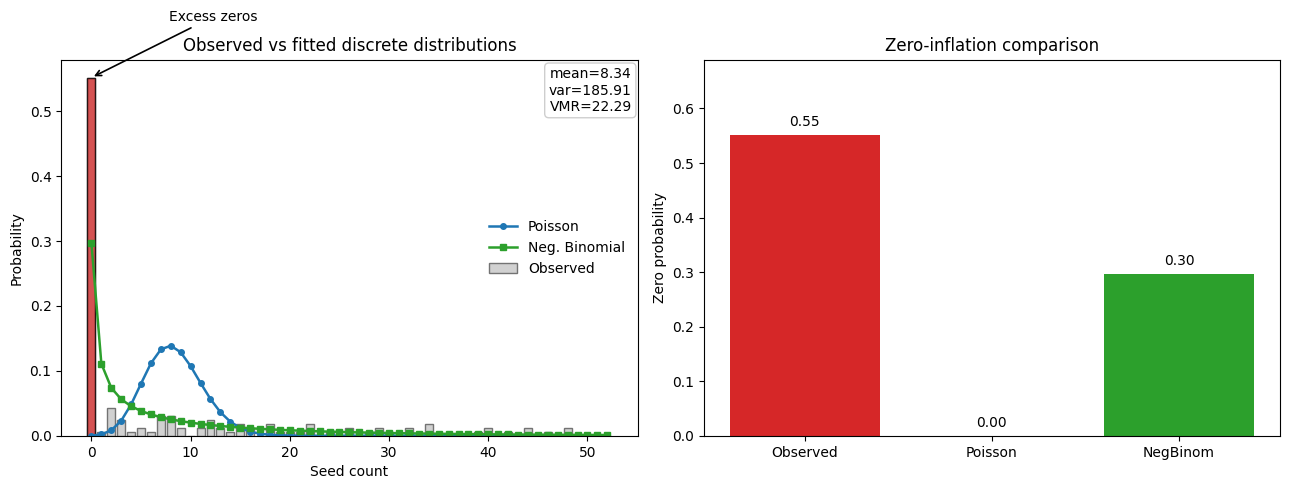

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom
from pathlib import Path

# Build seed-count array
seed_counts = df_net[df_net['treatment']=='CONTROL']['seed'].dropna().astype(int).values
seed_counts = df_net[df_net['treatment']=='TREATMENT']['seed'].dropna().astype(int).values
seed_counts = df_kur['seed'].dropna().astype(int).values
# Moments
mu = float(np.mean(seed_counts))
var = float(np.var(seed_counts))  # population variance to match earlier use
vmr = (var / mu) if mu > 0 else np.nan

# Discrete support for plotting
k_max = int(np.percentile(seed_counts, 99))
k_max = max(10, min(int(np.max(seed_counts)), k_max))
k = np.arange(0, k_max + 1, dtype=int)

# Observed PMF
obs_counts = pd.Series(seed_counts).value_counts().sort_index()
obs_pmf = obs_counts.reindex(k, fill_value=0).to_numpy() / seed_counts.size

# Fit Negative Binomial (method of moments)
# Guard against underdispersion: force slight overdispersion to compute parameters
var_adj = var if var > mu + 1e-9 else mu + 1e-9
r = (mu ** 2) / (var_adj - mu)  # number of successes (shape)
p = r / (r + mu)               # success probability

# Model PMFs
pmf_poisson = poisson.pmf(k, mu)
pmf_nbinom = nbinom.pmf(k, r, p)

# Zero probabilities
obs_zero = float((seed_counts == 0).mean())
p0_poisson = float(poisson.pmf(0, mu))
p0_nbinom = float(nbinom.pmf(0, r, p))

# Figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Left: observed vs fitted PMFs
ax1.bar(k, obs_pmf, color='0.82', edgecolor='0.45', label='Observed')
ax1.plot(k, pmf_poisson, 'o-', color='#1f77b4', lw=1.8, ms=4, label='Poisson')
ax1.plot(k, pmf_nbinom, 's-', color='#2ca02c', lw=1.8, ms=4, label='Neg. Binomial')
# Highlight zero bar
ax1.bar([0], [obs_pmf[0]], color='#d62728', edgecolor='black', alpha=0.75)
ax1.set_xlabel('Seed count')
ax1.set_ylabel('Probability')
ax1.set_title('Observed vs fitted discrete distributions')
ax1.legend(frameon=False)
# Annotate excess zeros if applicable
if obs_pmf[0] > max(pmf_poisson[0], pmf_nbinom[0]):
    ax1.annotate('Excess zeros', xy=(0, obs_pmf[0]), xytext=(k_max * 0.15, obs_pmf[0] * 1.15),
                 arrowprops=dict(arrowstyle='->', lw=1.2), ha='left', va='bottom')
# Add VMR box
ax1.text(0.99, 0.98, f'mean={mu:.2f}\nvar={var:.2f}\nVMR={vmr:.2f}',
         transform=ax1.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='0.8', alpha=0.95))

# Right: zero-inflation comparison
labels = ['Observed', 'Poisson', 'NegBinom']
rates = [obs_zero, p0_poisson, p0_nbinom]
colors = ['#d62728', '#1f77b4', '#2ca02c']
ax2.bar(labels, rates, color=colors)
ax2.set_ylim(0, max(rates) * 1.25)
for i, v in enumerate(rates):
    ax2.text(i, v + max(rates) * 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)
ax2.set_ylabel('Zero probability')
ax2.set_title('Zero-inflation comparison')

# fig.suptitle("Zero inflation: Poisson and NegBinom are not modeling the seed counts variable", y=1.02, fontsize=13)
fig.tight_layout()

# Save figure next to notebooks folder into plots
out_path = Path('../plots/seed_zero_inflation.png')
out_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(out_path, dpi=200, bbox_inches='tight')
plt.show()


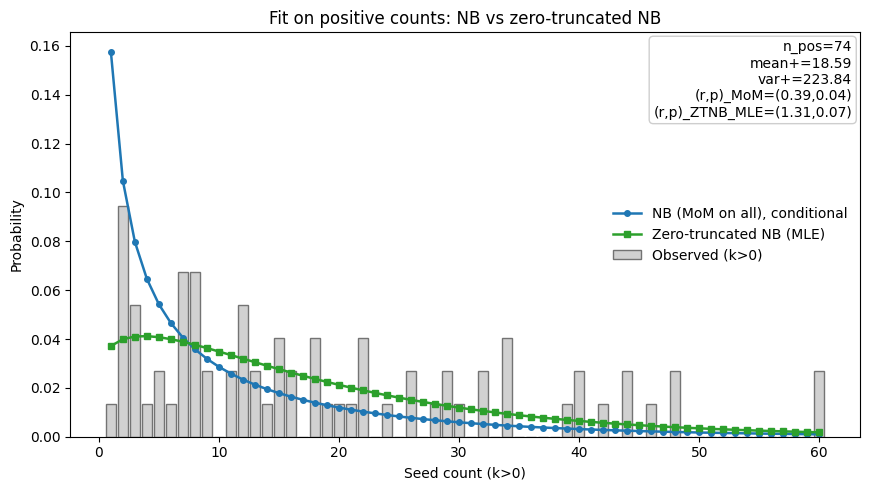

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.optimize import minimize
from pathlib import Path

# Data: remove zeros
all_counts = df_kur['seed'].dropna().astype(int).values
pos_counts = all_counts[all_counts > 0]
if pos_counts.size == 0:
    raise ValueError('No positive seed counts after removing zeros.')

# Support for plotting (positive counts only)
k_max = int(np.percentile(pos_counts, 99))
k_max = max(10, min(int(np.max(pos_counts)), k_max))
k = np.arange(1, k_max + 1, dtype=int)

# Observed PMF on positives
obs_counts_pos = pd.Series(pos_counts).value_counts().sort_index()
obs_pmf_pos = obs_counts_pos.reindex(k, fill_value=0).to_numpy() / pos_counts.size

# Helper: MoM NB fit on full data (untruncated), then condition on >0
mu_full = float(np.mean(all_counts))
var_full = float(np.var(all_counts))
var_full_adj = var_full if var_full > mu_full + 1e-9 else mu_full + 1e-9
r_mom = (mu_full ** 2) / (var_full_adj - mu_full)
p_mom = r_mom / (r_mom + mu_full)
# Conditional NB pmf given >0
pmf_nb_cond_mom = nbinom.pmf(k, r_mom, p_mom) / (1.0 - (p_mom ** r_mom))

# Zero-truncated NB MLE on positives
# Parametrization: r = exp(a) > 0, p = sigmoid(b) in (0,1)

def ztnb_nll(params):
    a, b = params
    r = np.exp(a)
    p = 1.0 / (1.0 + np.exp(-b))
    # log-likelihood for zero-truncated NB: sum log(NB(k)) - n * log(1 - NB(0))
    log_nb0 = r * np.log(p)
    log_den = np.log1p(-np.exp(log_nb0))  # log(1 - p**r)
    ll = np.sum(nbinom.logpmf(pos_counts, r, p)) - pos_counts.size * log_den
    return -ll

# Initialization from MoM on positives (unconditional moment formulas)
mu_pos = float(np.mean(pos_counts))
var_pos = float(np.var(pos_counts))
var_pos_adj = var_pos if var_pos > mu_pos + 1e-9 else mu_pos + 1e-9
r0 = (mu_pos ** 2) / (var_pos_adj - mu_pos)
p0 = r0 / (r0 + mu_pos)

x0 = np.array([np.log(max(r0, 1e-3)), np.log(p0 / (1 - p0))])
res = minimize(ztnb_nll, x0=x0, method='L-BFGS-B')
if not res.success:
    print('Warning: ZTNB MLE did not fully converge:', res.message)

a_hat, b_hat = res.x
r_mle = float(np.exp(a_hat))
p_mle = float(1.0 / (1.0 + np.exp(-b_hat)))
pmf_ztnb = nbinom.pmf(k, r_mle, p_mle) / (1.0 - (p_mle ** r_mle))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8.8, 5.0))
ax.bar(k, obs_pmf_pos, color='0.82', edgecolor='0.45', label='Observed (k>0)')
ax.plot(k, pmf_nb_cond_mom, 'o-', color='#1f77b4', lw=1.8, ms=4, label='NB (MoM on all), conditional')
ax.plot(k, pmf_ztnb, 's-', color='#2ca02c', lw=1.8, ms=4, label='Zero-truncated NB (MLE)')
ax.set_xlabel('Seed count (k>0)')
ax.set_ylabel('Probability')
ax.set_title('Fit on positive counts: NB vs zero-truncated NB')
ax.legend(frameon=False)

# Annotations: summary stats
ax.text(0.99, 0.98,
        f"n_pos={pos_counts.size}\nmean+={mu_pos:.2f}\nvar+={var_pos:.2f}\n(r,p)_MoM=({r_mom:.2f},{p_mom:.2f})\n(r,p)_ZTNB_MLE=({r_mle:.2f},{p_mle:.2f})",
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='0.8', alpha=0.95))

fig.tight_layout()

# Save figure
out_path = Path('../plots/seed_positive_nb_fit.png')
out_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(out_path, dpi=200, bbox_inches='tight')
plt.show()


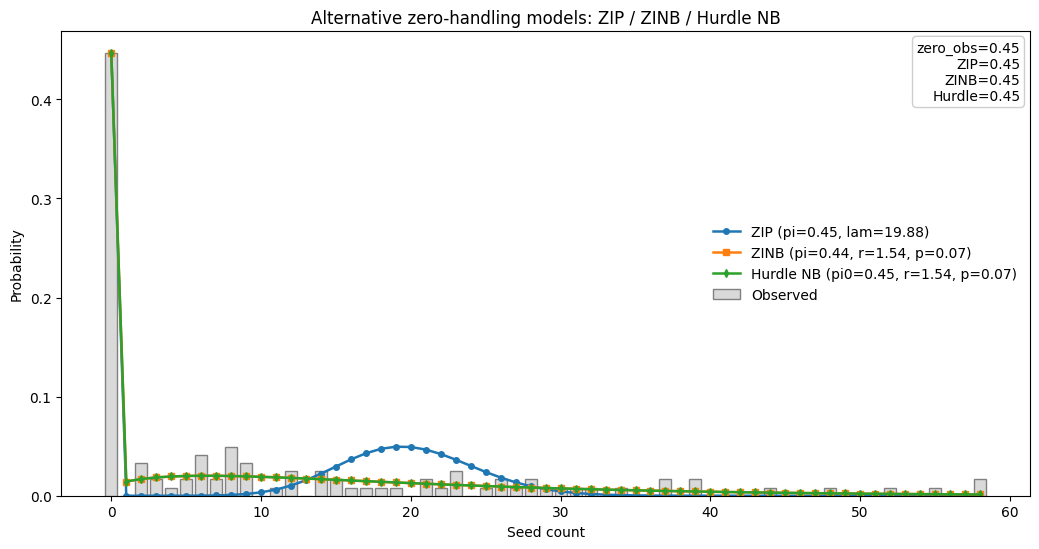

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom
from scipy.optimize import minimize
from scipy.special import gammaln
from pathlib import Path

# Data
x = df_net['seed'].dropna().astype(int).values
n = x.size
if n == 0:
    raise ValueError('No seed count data found.')

# Observed PMF support (include zeros)
k_max = int(np.percentile(x, 99))
k_max = max(10, min(int(np.max(x)), k_max))
k = np.arange(0, k_max + 1, dtype=int)
obs_counts = pd.Series(x).value_counts().sort_index()
obs_pmf = obs_counts.reindex(k, fill_value=0).to_numpy() / n
obs_zero = float((x == 0).mean())

# Moments for inits
mu = float(np.mean(x))
var = float(np.var(x))
var_adj = var if var > mu + 1e-9 else mu + 1e-9
r_mom = (mu ** 2) / (var_adj - mu)
p_mom = r_mom / (r_mom + mu)

# Helpers
sigmoid = lambda t: 1.0 / (1.0 + np.exp(-t))
logit = lambda p: np.log(p) - np.log1p(-p)

# -----------------------------
# ZIP: Zero-Inflated Poisson
# -----------------------------

def zip_nll(par):
    a, b = par
    lam = np.exp(a)
    pi = sigmoid(b)
    is_zero = (x == 0)
    # log P(0) = log(pi + (1-pi)*exp(-lam))
    log_p0 = np.logaddexp(np.log(pi), np.log1p(-pi) - lam)
    # log P(k>0) = log(1-pi) + log Poisson(k; lam)
    log_pk_pos = np.log1p(-pi) + (-lam + x[~is_zero] * np.log(lam) - gammaln(x[~is_zero] + 1))
    ll = is_zero.sum() * log_p0 + np.sum(log_pk_pos)
    return -ll

# ZIP init
lam0 = max(mu, 1e-6)
exp_neg_mu = np.exp(-lam0)
pi0_zip = (obs_zero - exp_neg_mu) / (1 - exp_neg_mu)
pi0_zip = float(np.clip(pi0_zip, 1e-6, 1 - 1e-6))
res_zip = minimize(zip_nll, x0=np.array([np.log(lam0), logit(pi0_zip)]), method='L-BFGS-B')
if not res_zip.success:
    print('Warning: ZIP MLE did not fully converge:', res_zip.message)
lam_zip = float(np.exp(res_zip.x[0]))
pi_zip = float(sigmoid(res_zip.x[1]))
pmf_zip = np.zeros_like(k, dtype=float)
pmf_zip[0] = pi_zip + (1 - pi_zip) * np.exp(-lam_zip)
pmf_zip[1:] = (1 - pi_zip) * poisson.pmf(k[1:], lam_zip)

# -----------------------------
# ZINB: Zero-Inflated Negative Binomial
# -----------------------------

def zinb_nll(par):
    a, b, c = par
    r = np.exp(a)
    p = sigmoid(b)
    pi = sigmoid(c)
    is_zero = (x == 0)
    log_nb0 = r * np.log(p)  # nbinom.logpmf(0, r, p)
    # log P(0) = logsumexp(log(pi), log(1-pi) + log_nb0)
    log_p0 = np.logaddexp(np.log(pi), np.log1p(-pi) + log_nb0)
    ll0 = is_zero.sum() * log_p0
    # log P(k>0) = log(1-pi) + log NB(k)
    ll_pos = np.sum(np.log1p(-pi) + nbinom.logpmf(x[~is_zero], r, p))
    return -(ll0 + ll_pos)

# ZINB init from MoM + zero rate
nb0 = p_mom ** r_mom
pi0_zinb = (obs_zero - nb0) / (1 - nb0)
pi0_zinb = float(np.clip(pi0_zinb, 1e-6, 1 - 1e-6))
res_zinb = minimize(
    zinb_nll,
    x0=np.array([np.log(max(r_mom, 1e-3)), logit(np.clip(p_mom, 1e-6, 1 - 1e-6)), logit(pi0_zinb)]),
    method='L-BFGS-B'
)
if not res_zinb.success:
    print('Warning: ZINB MLE did not fully converge:', res_zinb.message)
r_zinb = float(np.exp(res_zinb.x[0]))
p_zinb = float(sigmoid(res_zinb.x[1]))
pi_zinb = float(sigmoid(res_zinb.x[2]))
pmf_zinb = np.zeros_like(k, dtype=float)
pmf_zinb[0] = pi_zinb + (1 - pi_zinb) * (p_zinb ** r_zinb)
pmf_zinb[1:] = (1 - pi_zinb) * nbinom.pmf(k[1:], r_zinb, p_zinb)

# -----------------------------
# Hurdle NB: Pr(0)=pi0, Pr(k>0)=(1-pi0)*NB(k)/(1-NB(0))
# -----------------------------

def hnb_nll(par):
    a, b, c = par
    r = np.exp(a)
    p = sigmoid(b)
    pi0 = sigmoid(c)
    is_zero = (x == 0)
    log_nb0 = r * np.log(p)
    log_den = np.log1p(-np.exp(log_nb0))  # log(1 - NB0)
    ll0 = is_zero.sum() * np.log(pi0)
    ll_pos = np.sum(np.log1p(-pi0) + nbinom.logpmf(x[~is_zero], r, p) - log_den)
    return -(ll0 + ll_pos)

# Hurdle init: pi0 from observed zeros, NB from positives
x_pos = x[x > 0]
mu_pos = float(np.mean(x_pos)) if x_pos.size else 1.0
var_pos = float(np.var(x_pos)) if x_pos.size else mu_pos + 1.0
var_pos_adj = var_pos if var_pos > mu_pos + 1e-9 else mu_pos + 1e-9
r0_pos = (mu_pos ** 2) / (var_pos_adj - mu_pos)
p0_pos = r0_pos / (r0_pos + mu_pos)
res_hnb = minimize(
    hnb_nll,
    x0=np.array([
        np.log(max(r0_pos, 1e-3)),
        logit(np.clip(p0_pos, 1e-6, 1 - 1e-6)),
        logit(np.clip(obs_zero, 1e-6, 1 - 1e-6))
    ]),
    method='L-BFGS-B'
)
if not res_hnb.success:
    print('Warning: Hurdle NB MLE did not fully converge:', res_hnb.message)
r_hnb = float(np.exp(res_hnb.x[0]))
p_hnb = float(sigmoid(res_hnb.x[1]))
pi0_hnb = float(sigmoid(res_hnb.x[2]))
nb0_hnb = p_hnb ** r_hnb
pmf_hnb = np.zeros_like(k, dtype=float)
pmf_hnb[0] = pi0_hnb
pmf_hnb[1:] = (1 - pi0_hnb) * nbinom.pmf(k[1:], r_hnb, p_hnb) / (1 - nb0_hnb)

# Plot comparison
fig, ax = plt.subplots(1, 1, figsize=(10.5, 5.6))
ax.bar(k, obs_pmf, color='0.85', edgecolor='0.5', label='Observed')
ax.plot(k, pmf_zip, 'o-', ms=4, lw=1.8, label=f'ZIP (pi={pi_zip:.2f}, lam={lam_zip:.2f})')
ax.plot(k, pmf_zinb, 's-', ms=4, lw=1.8, label=f'ZINB (pi={pi_zinb:.2f}, r={r_zinb:.2f}, p={p_zinb:.2f})')
ax.plot(k, pmf_hnb, 'd-', ms=4, lw=1.8, label=f'Hurdle NB (pi0={pi0_hnb:.2f}, r={r_hnb:.2f}, p={p_hnb:.2f})')
ax.set_xlabel('Seed count')
ax.set_ylabel('Probability')
ax.set_title('Alternative zero-handling models: ZIP / ZINB / Hurdle NB')
ax.legend(frameon=False)

# Zero probabilities summary
z_zip = pmf_zip[0]
z_zinb = pmf_zinb[0]
z_hnb = pmf_hnb[0]
ax.text(0.99, 0.98,
        f"zero_obs={obs_zero:.2f}\nZIP={z_zip:.2f}\nZINB={z_zinb:.2f}\nHurdle={z_hnb:.2f}",
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='0.8', alpha=0.95))

fig.tight_layout()
# Save
out_path = Path('../plots/seed_alt_zero_models.png')
out_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(out_path, dpi=200, bbox_inches='tight')
plt.show()
